In [1]:
import os
thread_limit = 16

# Limit threads BEFORE importing numpy
# so I don't crash tolva
os.environ["OMP_NUM_THREADS"] = str(thread_limit)
os.environ["OPENBLAS_NUM_THREADS"] = str(thread_limit)
os.environ["MKL_NUM_THREADS"] = str(thread_limit)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread_limit)
os.environ["NUMEXPR_NUM_THREADS"] = str(thread_limit)

In [2]:
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import scanpy as sc
from matplotlib_venn import venn2
import scrublet as scr
import pandas as pd
from pybiomart import Server
from upsetty import Upset
from tqdm import tqdm
from scipy import sparse
import multiprocessing
import json
from itertools import product
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

In [3]:
%matplotlib inline

In [4]:
# Where data will stored
outdir = "/mnt/data1/10XvParse/Analysis_3/"
fasta_folder = "FASTA/Processed/"
sample_folder = "FASTA/Sampled/"
sra_folder = "SRA/"
tmp_folder = "tmp/"

In [5]:
def make_dir(directory_name, outdir = ""):
    path = outdir+directory_name
    try:
        os.makedirs(path)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [6]:
make_dir(sample_folder, outdir)

Directory 'FASTA/Sampled/' already exists.


In [7]:
names = ['10x','polyT', 'randO', 'parse']
sample_names = ['H1', 'H2']

In [8]:
# How much to draw per sample. This is the number of H1 randO reads
min_counts = 89200166 

# Downsample

In [ ]:
# Subsample reads using seqtk based on min_counts which is set above
def subSample(iter):
    name = iter[0]
    sample_name = iter[1]
    path = outdir + fasta_folder + name + "_" + sample_name
    out = outdir + sample_folder + name + "_" + sample_name
    print(path)
    !seqtk sample -s 42 {path+"_1.fasta.gz"} {min_counts} | pigz -p 8 > {out+"_1.fasta.gz"}
    print("Starting",name,sample_name,"second read subsampling")
    !seqtk sample -s 42 {path+"_2.fasta.gz"} {min_counts} | pigz -p 8 > {out+"_2.fasta.gz"}
    print("Finished",name,sample_name)

with multiprocessing.Pool(processes=1) as pool:
    pool.map(subSample,product(names,sample_names))
    print("done")

/mnt/data1/10XvParse/Analysis_3/FASTA/Processed/10x_H1


Starting 10x H1 second read subsampling
Finished 10x H1
/mnt/data1/10XvParse/Analysis_3/FASTA/Processed/10x_H2
Starting 10x H2 second read subsampling


In [10]:
# Align subsampled reads to genome using kallisto
def align(iter):
    name = iter[0][0]
    tech = iter[0][1]
    sample_name = iter[1]
    path = outdir + sample_folder + name + "_" + sample_name
    out = outdir + "sample_" + name + "_" + sample_name + "_out"

    if name == 'parse':
        !kb count --overwrite --h5ad -r parse_extraction/replace.txt \
            -i index.idx -g t2g.txt -x {tech} -o {out} \
            {path+"_1.fasta.gz"} {path+"_2.fasta.gz"}
    else:
        !kb count --overwrite --h5ad \
            -i index.idx -g t2g.txt -x {tech} -o {out} \
            {path+"_1.fasta.gz"} {path+"_2.fasta.gz"}

    print("Finished",name,sample_name)

with multiprocessing.Pool(processes=2) as pool:
    iter = product(zip(names,
                   ['10XV3', "SPLIT-SEQ", "SPLIT-SEQ", "SPLIT-SEQ"]),
                   sample_names)
    pool.map(align,iter)
    print("done")

[2025-08-29 09:48:27,919]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/sample_10x_H2_out from
[2025-08-29 09:48:27,919]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Sampled/10x_H2_1.fasta.gz
[2025-08-29 09:48:27,920]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Sampled/10x_H2_2.fasta.gz
[2025-08-29 09:48:27,914]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/sample_10x_H1_out from
[2025-08-29 09:48:27,914]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Sampled/10x_H1_1.fasta.gz
[2025-08-29 09:48:27,914]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Sampled/10x_H1_2.fasta.gz
[2025-08-29 09:55:27,336]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/sample_10x_H2_out/output.bus to /mnt/data1/10XvParse/Analysis_3/sample_10x_H2_out/tmp/output.s.bus
[2025-08-29 09:55:39,366]    INFO [count] Sorting BUS file /mnt/data

In [9]:
# Load anndata object and begin initial processing
def initProcessing(data_name, sample_name = None, data_title = None, modified = False):
    s_string = ""
    m_string = ""
    if sample_name:
        s_string = "_" + sample_name
    if modified:
        m_string = "_modified"

    dir = f"{outdir}sample_{data_name}{s_string}_out/"
    counts_dir = f"{dir}counts_unfiltered{m_string}/"

    # Read in h5ad file from kb-python alignment
    data = anndata.read_h5ad(f"{counts_dir}adata.h5ad")
    
    # Switch gene ids with gene names
    data.var["gene_id"] = data.var.index.tolist()
    gene_names = []
    with open(f"{counts_dir}cells_x_genes.genes.names.txt", 'r') as file:
        for line in file:
            gene_names.append(line.strip())
    data.var_names = gene_names

    # Add some metadata
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100

    # Add unstructured metadata
    data.uns['name'] = data_name
    if data_title:
        data.uns['title'] = data_title
    
    with open(f"{dir}run_info.json", 'r') as f:
        run_info = json.load(f)
        data.uns['n_processed' + s_string] = run_info['n_processed']
        data.uns['n_aligned' + s_string] = run_info['n_pseudoaligned']
    data.uns['n_raw_counts' + s_string] = data.X.sum() 

    # Just ensure that there are no zero genes or cells
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

    return data

# Concatentate samples (expects two) into one anndata object
def concatSamples(data_name, sample_names, data_title = None, modified=False):
    # Load and process sample anndata objects
    sample_datasets = []
    for sample_name in sample_names:
        sample_data = initProcessing(data_name, sample_name, data_title, modified)
        sample_datasets.append(sample_data)
    
    # concatentate objects
    data = anndata.concat(sample_datasets, 
                          axis='obs', 
                          fill_value=0, 
                          uns_merge='first',
                          join='outer', 
                          label='sample', 
                          merge='first',
                          keys=sample_names, 
                          index_unique='-')
    data.var = pd.merge(sample_datasets[0].var, sample_datasets[1].var, 
                        how='outer', left_index=True, right_index=True, 
                        suffixes=('_' + sample_names[0], '_' + sample_names[1]))
    data.var['gene_id_'+sample_names[0]] = data.var['gene_id_'+sample_names[0]].fillna(data.var['gene_id_'+sample_names[1]])
    data.var.drop('gene_id_'+sample_names[1],axis=1, inplace=True)
    data.var.rename(columns={'gene_id_'+sample_names[0]:'gene_id'},inplace=True)
    data.var['n_cells'] = sample_datasets[0].var['n_cells'].add(sample_datasets[1].var['n_cells'], fill_value=0)
    data.var['percent_counts'] = sample_datasets[0].var['percent_counts'].add(sample_datasets[1].var['percent_counts'], fill_value=0)
    data.var.fillna(0)
    
    return data

In [10]:
data_10x = concatSamples('10x', sample_names, '10X Genomics')
data_polyT = concatSamples('polyT', sample_names, "Parse 3\'")
data_randO = concatSamples('randO', sample_names, "Parse Random Oligo")
data_parse = concatSamples('parse', sample_names, "Parse", modified=True)

raw_datasets = [data_10x, data_polyT, data_randO, data_parse]

# Population Upsampling Estimation

In [11]:
# Find the projected number of unique transcripts to be found using each method if sampling were to continue
# Using PreSeq (Daley and Smith 2013) based off of the recommendation from this paper: https://www.biorxiv.org/content/10.1101/2024.10.09.615408v1.full.pdf

def upsample(data):
    filename = f"counts/{data.uns['name']}_counts.txt"
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(filename, "w") as f:
        counts = data.X.sum(axis=0).A1
        for count in counts:
            f.write(f"{int(count)}\n")
    !preseq lc_extrap -o {fileout} -V {filename}
    return

with multiprocessing.Pool(processes=4) as pool:
    pool.map(upsample,raw_datasets)
    print("done")


done


In [14]:
for data in raw_datasets:    
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(fileout, "r") as f:
        rows = []
        first_line = f.readline()
        for line in f:
            rows.append(list(map(float,line.split())))
    data.uns['pred_upsample'] = np.array(rows)

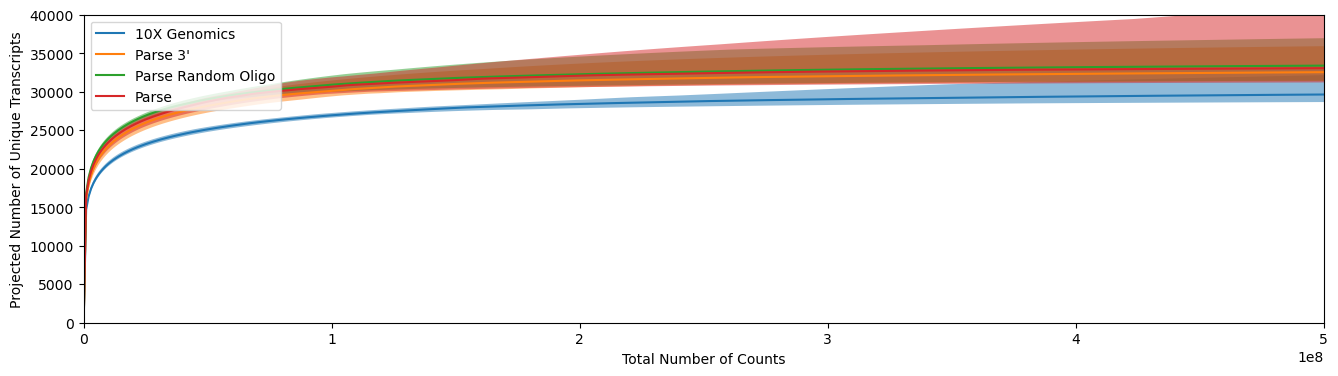

In [15]:
plt.figure(figsize=(16, 4))
for data in raw_datasets:
    pred = data.uns['pred_upsample']
    plt.plot(pred[:, 0], pred[:, 1], label=data.uns['title'])
    plt.fill_between(pred[:, 0], pred[:,2], pred[:,3], alpha=0.5)

plt.legend(loc='upper left')
plt.xlim(0, 5e8)
plt.ylim(0, 4e4)
plt.xlabel('Total Number of Counts')
plt.ylabel('Projected Number of Unique Transcripts')
plt.show()

# Quality Control Comparison

In [67]:
# Scatter plot of genes detected vs. UMI counts
def scatter_reads(ax, data):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title'] + " Reads")

# filter based off of UMI threshold (specified by min_counts)
def refilter(raw_data, min_counts):
    data = raw_data.copy()
    sc.pp.filter_cells(data, min_counts=min_counts)
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    for sample in sample_names:
        X = data.X[(data.obs['sample']==sample).tolist()]
        data.var['n_cells_'+sample] = X.astype(bool).sum(axis=0).A1
        data.var['percent_counts_'+sample] = X.sum(axis=0).A1/X.sum() * 100 
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100

    return data

# Knee plot with threshold axes
def knee_plot(ax, raw_data, cutoff = 20):
    knee = np.sort((np.array(raw_data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(raw_data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {raw_data.uns['title']}")
    data = refilter(raw_data, knee[num_cells])
    
    return data


# Scatter plot for mitochondrial percentage
def mito_scatter(ax, data):
    sc.pl.scatter(data, x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(data.uns['title'])
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")

# Generates violin plots of selected cell metadata
def violin_plots(ax_col, data, groups):
    for i, group in enumerate(groups):
        sc.pl.violin(data, group, ax=ax_col[i], stripplot=False, show=False)
        ax_col[i].set_xticks([])

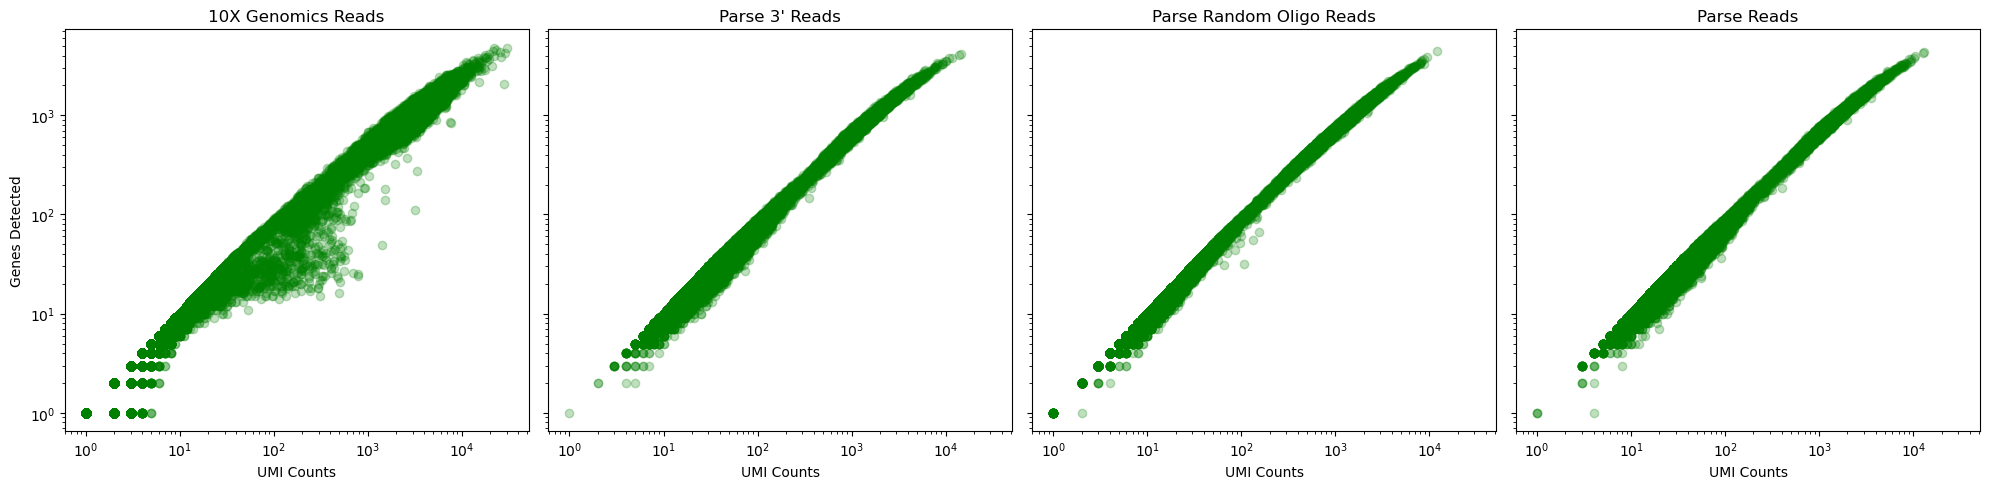

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)

for i, data in enumerate(raw_datasets):
    scatter_reads(ax[i], data)

ax[0].set_ylabel("Genes Detected")

plt.tight_layout()
plt.show()

In [69]:
# Retrieve gene annotations from ensemble
def queryBiotype(dataset):
    # Query Ensembl for biotypes
    type_result = dataset.query(attributes=[
        'external_gene_name',
        'ensembl_gene_id_version',
        'transcript_biotype'])

    # Clean column names
    type_result.columns = ['gene_name', 'gene_id', 'gene_type']

    # From biotypes to bool cols
    type_result['is_lnc'] = (type_result['gene_type'] == 'lncRNA')
    type_result['is_pc'] = (type_result['gene_type'] == 'protein_coding')
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    type_result['is_mito'] = type_result['gene_name'].str.startswith("MT")
    # ribosomal genes
    type_result['is_ribo'] = type_result['gene_name'].str.startswith(("RPS", "RPL"))

    type_result.drop('gene_type', axis=1, inplace=True)
    return type_result

def queryLength(dataset):
    # Query Ensembl for approximate transcript lengths
    length_result = dataset.query(attributes=[
        'external_gene_name',
        'ensembl_gene_id_version', 
        'ensembl_exon_id',
        'exon_chrom_start',
        'exon_chrom_end'])

    # Clean column names
    length_result.columns = ['gene_name','gene_id', 'exon_id', 'exon_start', 'exon_end']
    l_df = length_result.copy()

    # Drop duplicates to avoid counting shared exons multiple times
    l_df.drop_duplicates(subset=['gene_name','gene_id', 'exon_start', 'exon_end'], inplace=True)

    # Compute exon lengths
    l_df['exon_length'] = l_df['exon_end'] - l_df['exon_start'] + 1

    # Sum exon lengths per gene
    gene_lengths = l_df.groupby(['gene_id','gene_name'])['exon_length'].sum().reset_index()
    gene_lengths.rename(columns={'exon_length': 'gene_length'}, inplace=True)

    return gene_lengths

def queryGC(dataset):
    # Query Ensemble for Gene GC Content
    gc_result = dataset.query(attributes=[
    'ensembl_transcript_id_version',
    'external_gene_name',
    'ensembl_gene_id_version',
    'percentage_gene_gc_content'])

    # Clean column names
    gc_result.columns = ['transcript_id', 'gene_name', 'gene_id', 'gc_content']
    # Drop duplicates to avoid counting shared exons multiple times
    gc_result.drop_duplicates(subset=['gene_name','gene_id','transcript_id','gc_content'], inplace=True)
    gc_result.drop('transcript_id', axis=1, inplace=True)

    # average gc_content per trancript
    gc_content = gc_result.groupby(['gene_id','gene_name'])['gc_content'].mean().reset_index()

    return gc_content
    

def queryEnsembl(datasets, path, force = False):
    if os.path.exists(path) and not force:
        gene_info = pd.read_csv(path, index_col = [0])
    else:
        # Connect to server
        server = Server(host='http://ensembl.org')
        dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                        .datasets['hsapiens_gene_ensembl']

        type_result = queryBiotype(dataset)
        length_result = queryLength(dataset)
        gc_result = queryGC(dataset)

        gene_info = pd.merge(length_result, type_result, on=['gene_name','gene_id'])
        gene_info = pd.merge(gene_info, gc_result, on=['gene_name','gene_id'])
            
        gene_info.drop_duplicates(subset = ['gene_name', 'gene_id'], inplace=True)
        gene_info.to_csv(path)
        
    return gene_info

In [70]:
# Path to save gene metadata so don't need to query Ensembl 
# more than once
gene_info_path = "gene_attributes.csv"
gene_info = queryEnsembl(raw_datasets, gene_info_path) 

In [71]:
# Add cell metrics to anndata object given Ensembl gene metadata
def add_cell_metrics(data, gene_info):
    # retrieve gene metadata
    lnc_result = gene_info["gene_id"][gene_info['is_lnc']].tolist()
    pc_result = gene_info["gene_id"][gene_info['is_pc']].tolist()
    gene_lengths = gene_info[['gene_id', 'gene_length']].drop_duplicates()
    gc_content = gene_info[['gene_id', 'gc_content']].drop_duplicates()

    gene_ids = set(data.var["gene_id"].tolist())
    lncRNA_genes = gene_ids.intersection(set(lnc_result))
    pc_genes = gene_ids.intersection(set(pc_result))
    
    # Identify lncRNA genes
    data.var["is_lnc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["gene_id"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

    # Identify protein-coding genes
    data.var["is_pc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["gene_id"].isin(list(pc_genes)), ["is_pc"]] = True

    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    data.var["is_mito"] = data.var_names.str.startswith("MT")
    # ribosomal genes
    data.var["is_ribo"] = data.var_names.str.startswith(("RPS", "RPL"))

    pc_counts = data[:, data.var['is_pc']].X.sum(axis=1)
    mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
    ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
    lnc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

    # Calculate total counts per cell
    total_counts = data.X.sum(axis=1)

    # Calculate percent mitochondrial and ribosomal gene expression per cell
    data.obs['percent_pc'] = np.array(pc_counts / total_counts * 100).flatten()
    data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
    data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
    data.obs['percent_lnc'] = np.array(lnc_counts / total_counts * 100).flatten()

    # Calculate gene lengths based on exon lengths
    index = data.var.index
    if not 'gene_length' in data.var.columns:
        data.var = data.var.merge(gene_lengths,how='left',on=['gene_id']).fillna(1)
    if not 'gc_content' in data.var.columns:
        data.var = data.var.merge(gc_content,how='left',on=['gene_id']).fillna(0)
    data.var.set_index(index,inplace=True)

In [72]:
for data in raw_datasets:
    add_cell_metrics(data, gene_info)

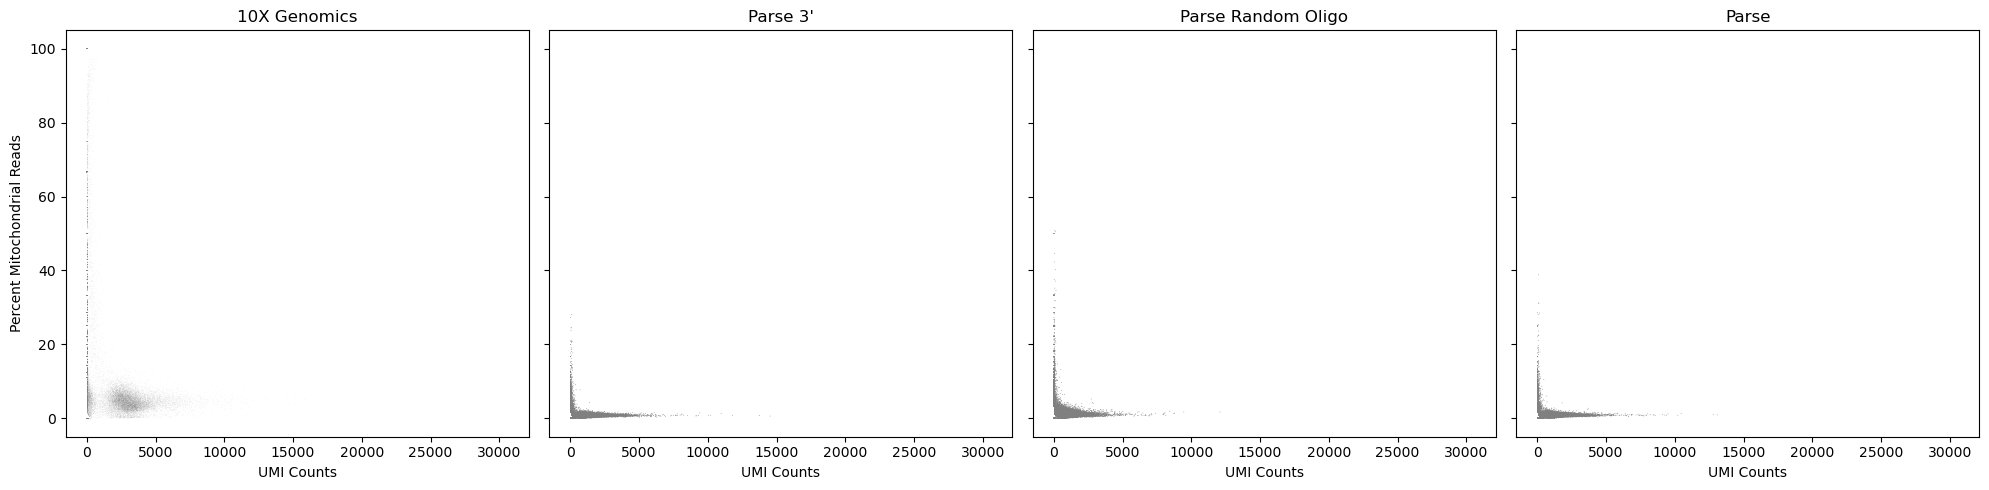

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
for i, data in enumerate(raw_datasets):
    mito_scatter(ax[i], data)

ax[0].set_ylabel("Percent Mitochondrial Reads")

plt.tight_layout()
plt.show()

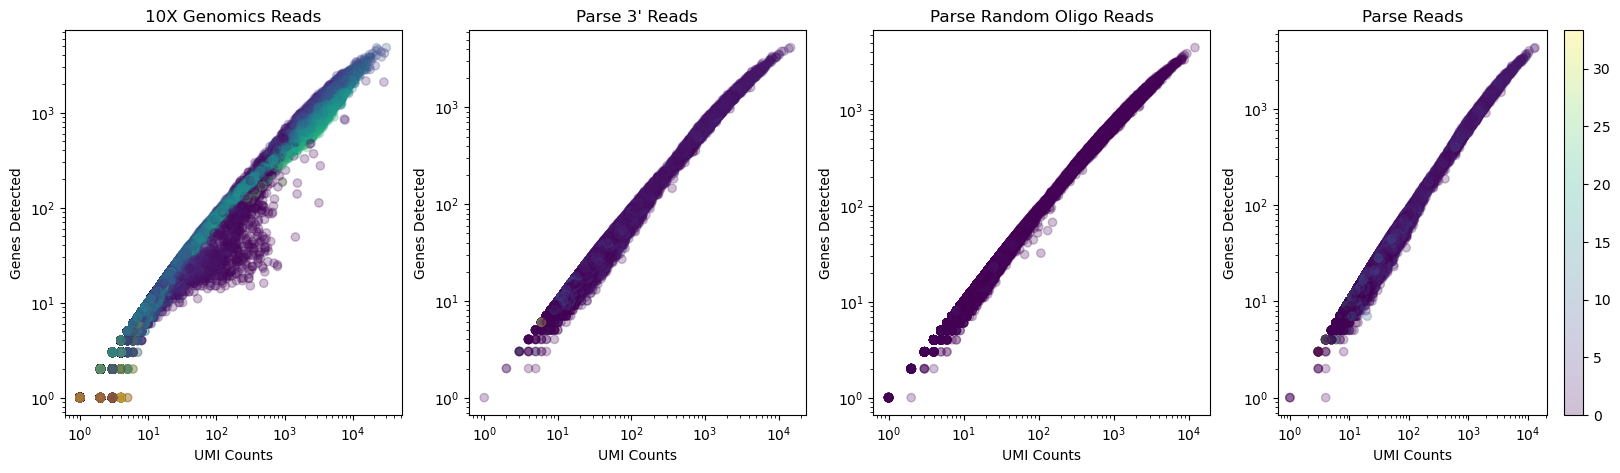

In [74]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs,raw_datasets):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ribo_content = data.obs['percent_ribo'].tolist()

    im = ax.scatter(x, y, c=ribo_content, cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

In [75]:
def get_mean_distance(data, ribo_thresh = None, distance = cosine_distances):
    if ribo_thresh:
        data = data[data.obs['percent_ribo'] < ribo_thresh]
    mean_cell = np.asarray(data.X.mean(axis=0))
    dist = distance(data.X, mean_cell)
    return data, dist

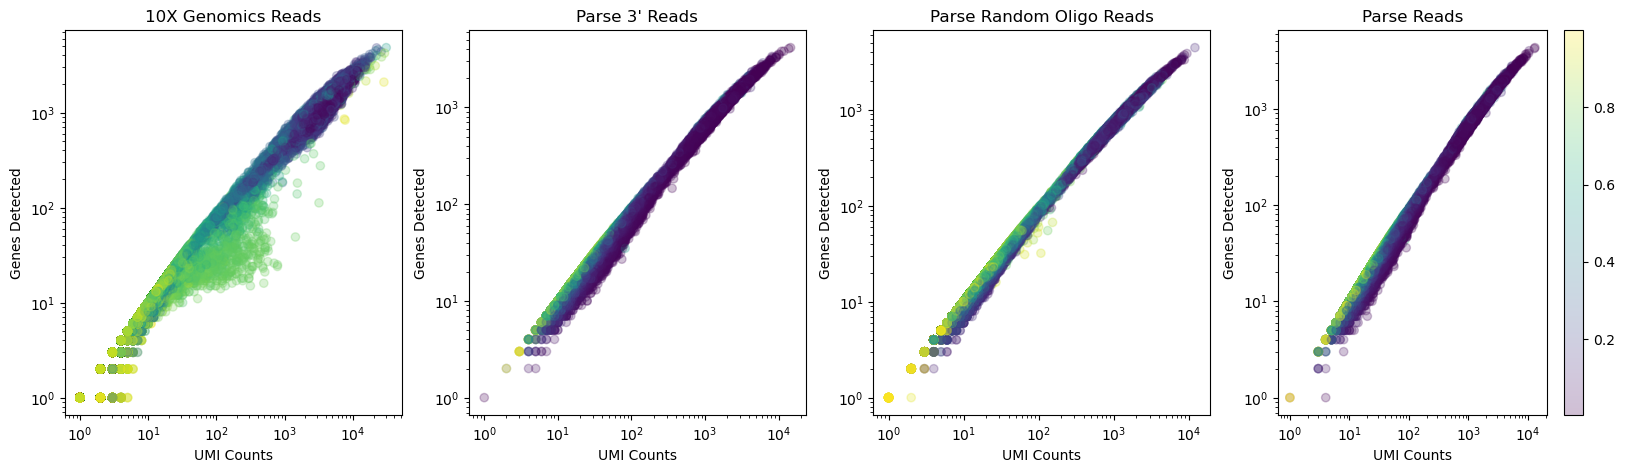

In [76]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, raw_datasets):
    filtered_data, dist = get_mean_distance(data)
    x = np.asarray(filtered_data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(filtered_data.X>0, axis=1))[:,0]

    im = ax.scatter(x, y, c=dist, cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

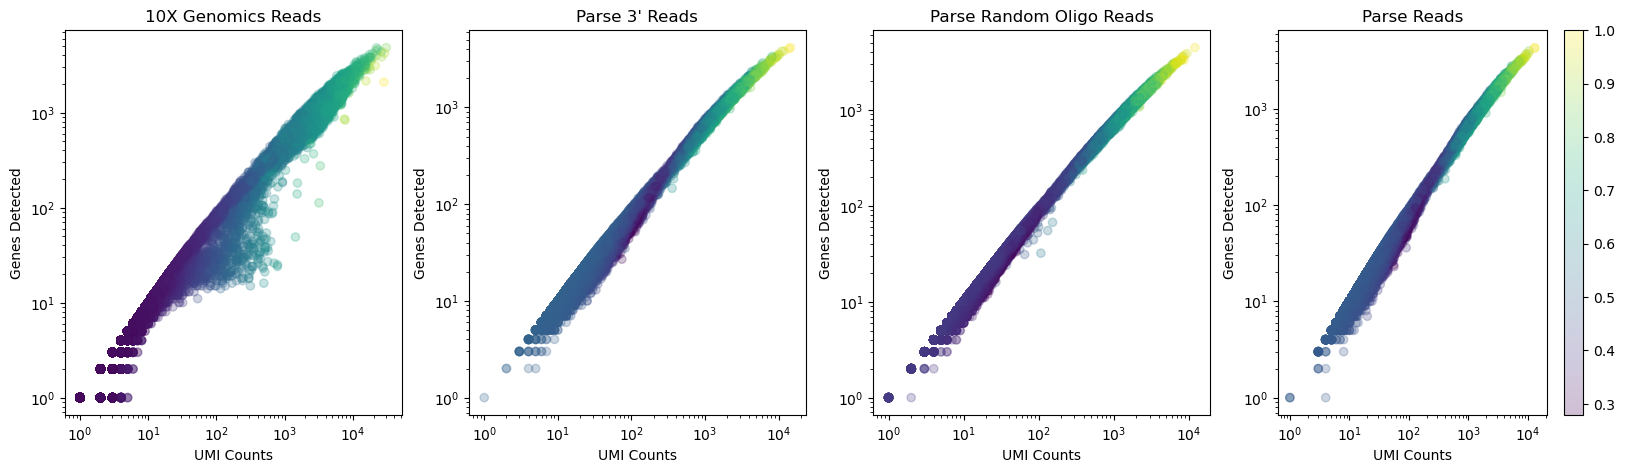

In [77]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, raw_datasets):
    filtered_data, dist = get_mean_distance(data, distance = euclidean_distances)
    dist = np.log(dist) / np.max(np.log(dist))
    x = np.asarray(filtered_data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(filtered_data.X>0, axis=1))[:,0]

    im = ax.scatter(x, y, c=dist, cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

17,083 cells passed the 421 UMI threshold for 10X Genomics
17,042 cells passed the 384 UMI threshold for Parse 3'
17,040 cells passed the 251 UMI threshold for Parse Random Oligo
16,948 cells passed the 437 UMI threshold for Parse


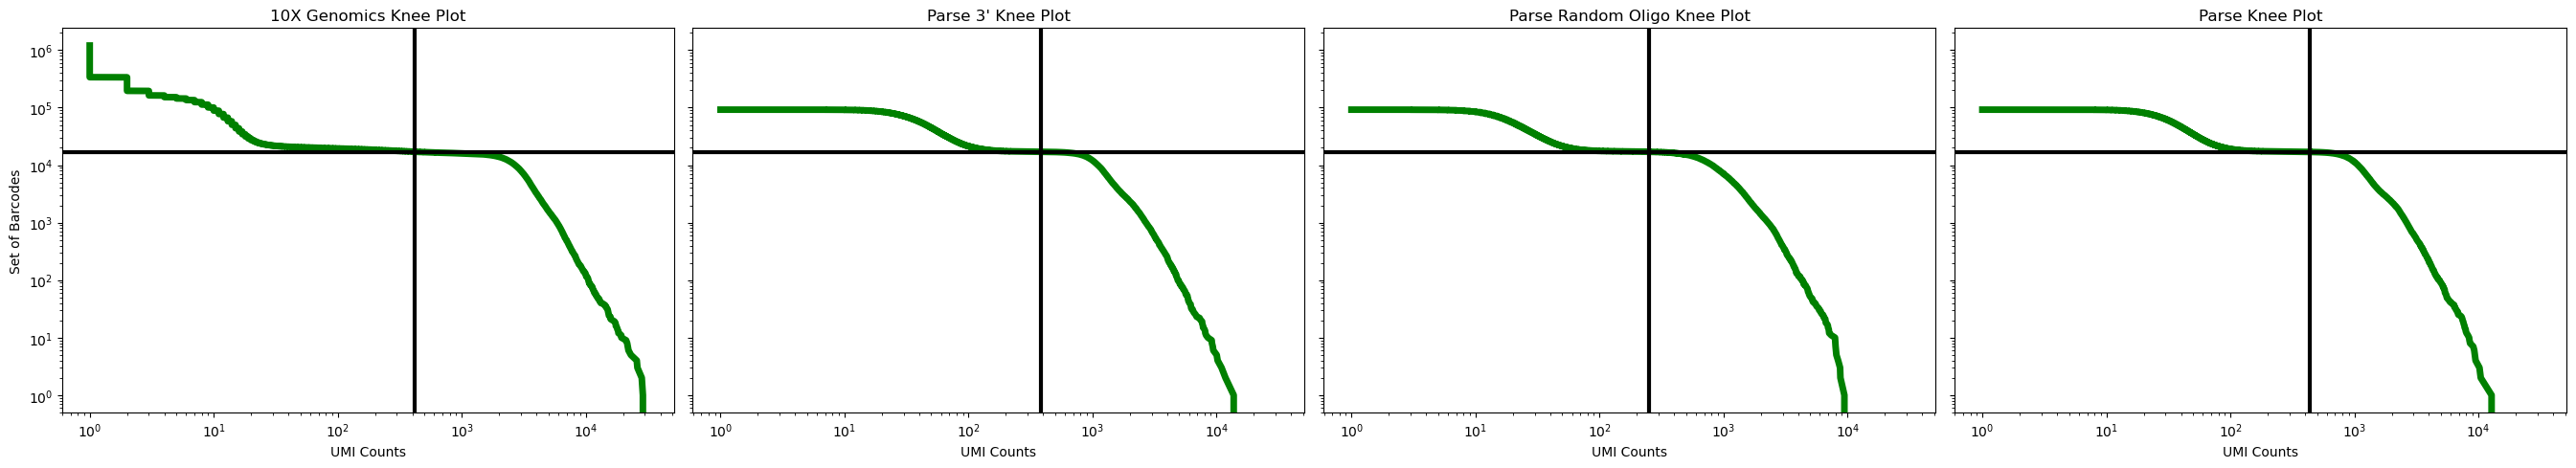

In [78]:
fig, ax = plt.subplots(1, 4, figsize=(27,5), sharey=True,sharex=True)

cutoffs = [421, 384, 251, 437]

datasets = []
for i, (data, cutoff) in enumerate(zip(raw_datasets, cutoffs)):
    datasets.append(knee_plot(ax[i], data, cutoff=cutoff))

ax[0].set_ylabel("Set of Barcodes")

plt.tight_layout()
plt.show()

In [79]:
def updateGeneInfo(gene_info, datasets, path):
    for data in datasets:
        gene_info = gene_info.merge(data.var[['gene_id','n_cells','percent_counts']], on = ['gene_id'], how = 'left')
        gene_info.rename(columns={'n_cells':data.uns['name']+'_n_cells', 
                                'percent_counts':data.uns['name']+'_percent_counts'}, 
                                inplace=True)
    gene_info = gene_info.dropna(subset = ['10x_n_cells', 'polyT_n_cells', 'randO_n_cells', 'parse_n_cells'], how = 'all')
    gene_info = gene_info.fillna(0)
    gene_info.to_csv(path)
    return gene_info

full_gene_info_path = 'gene_comparisons.csv'
gene_info = updateGeneInfo(gene_info, datasets, full_gene_info_path)

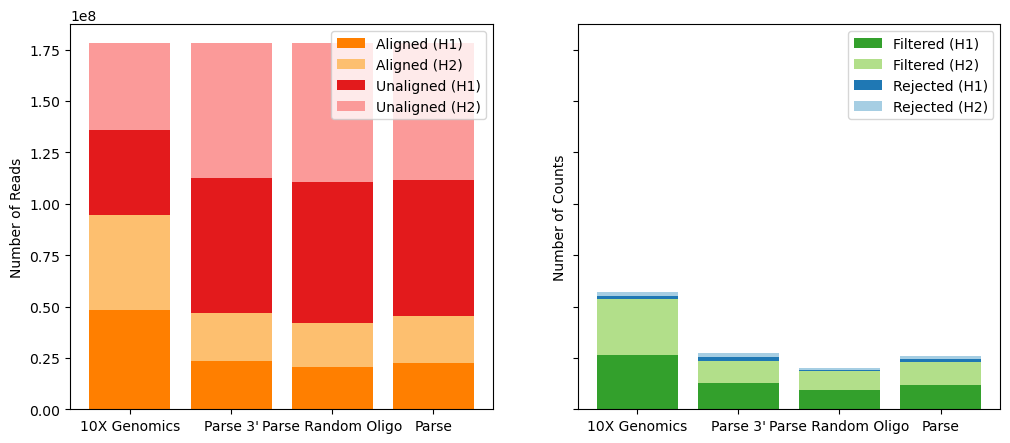

In [80]:
fig, axs = plt.subplots(1,2, figsize = (12,5), sharey=True)

processed = []
aligned = []
filtered_counts = []
counts = []
for sample_name in sample_names:
    processed.append([data.uns['n_processed_'+sample_name] for data in datasets])
    aligned.append([data.uns['n_aligned_'+sample_name] for data in datasets])
    counts.append([data.uns['n_raw_counts_'+sample_name] for data in datasets])
    filtered_counts.append([data.X[(data.obs['sample'] == sample_name).tolist(),:].sum() for data in datasets])
labels = [data.uns['title'] for data in datasets]
aligned = np.array(aligned)
unaligned = np.array(processed) - aligned
filtered_counts = np.array(filtered_counts)
rejected_counts = np.array(counts) - filtered_counts

colors = plt.cm.Paired(np.linspace(0,1,12))
colors = colors[:8][::-1]

bottom = np.zeros(len(datasets))
j=0
for i, sample_name in enumerate(sample_names):
    axs[0].bar(labels, aligned[i], bottom = bottom, label = f"Aligned ({sample_name})", color = colors[j])
    bottom += aligned[i]
    j+=1
for i, sample_name in enumerate(sample_names):
    axs[0].bar(labels, unaligned[i], bottom = bottom, label = f"Unaligned ({sample_name})", color = colors[j])
    bottom += unaligned[i]
    j+=1
axs[0].set_ylabel('Number of Reads')
axs[0].legend()

bottom = np.zeros(len(datasets))
for i, sample_name in enumerate(sample_names):
    axs[1].bar(labels, filtered_counts[i], bottom = bottom, label = f"Filtered ({sample_name})", color = colors[j])
    bottom += filtered_counts[i]
    j+=1
for i, sample_name in enumerate(sample_names):
    axs[1].bar(labels, rejected_counts[i], bottom = bottom, label = f"Rejected ({sample_name})", color = colors[j])
    bottom += rejected_counts[i]
    j+=1
axs[1].set_ylabel('Number of Counts')
axs[1].legend()

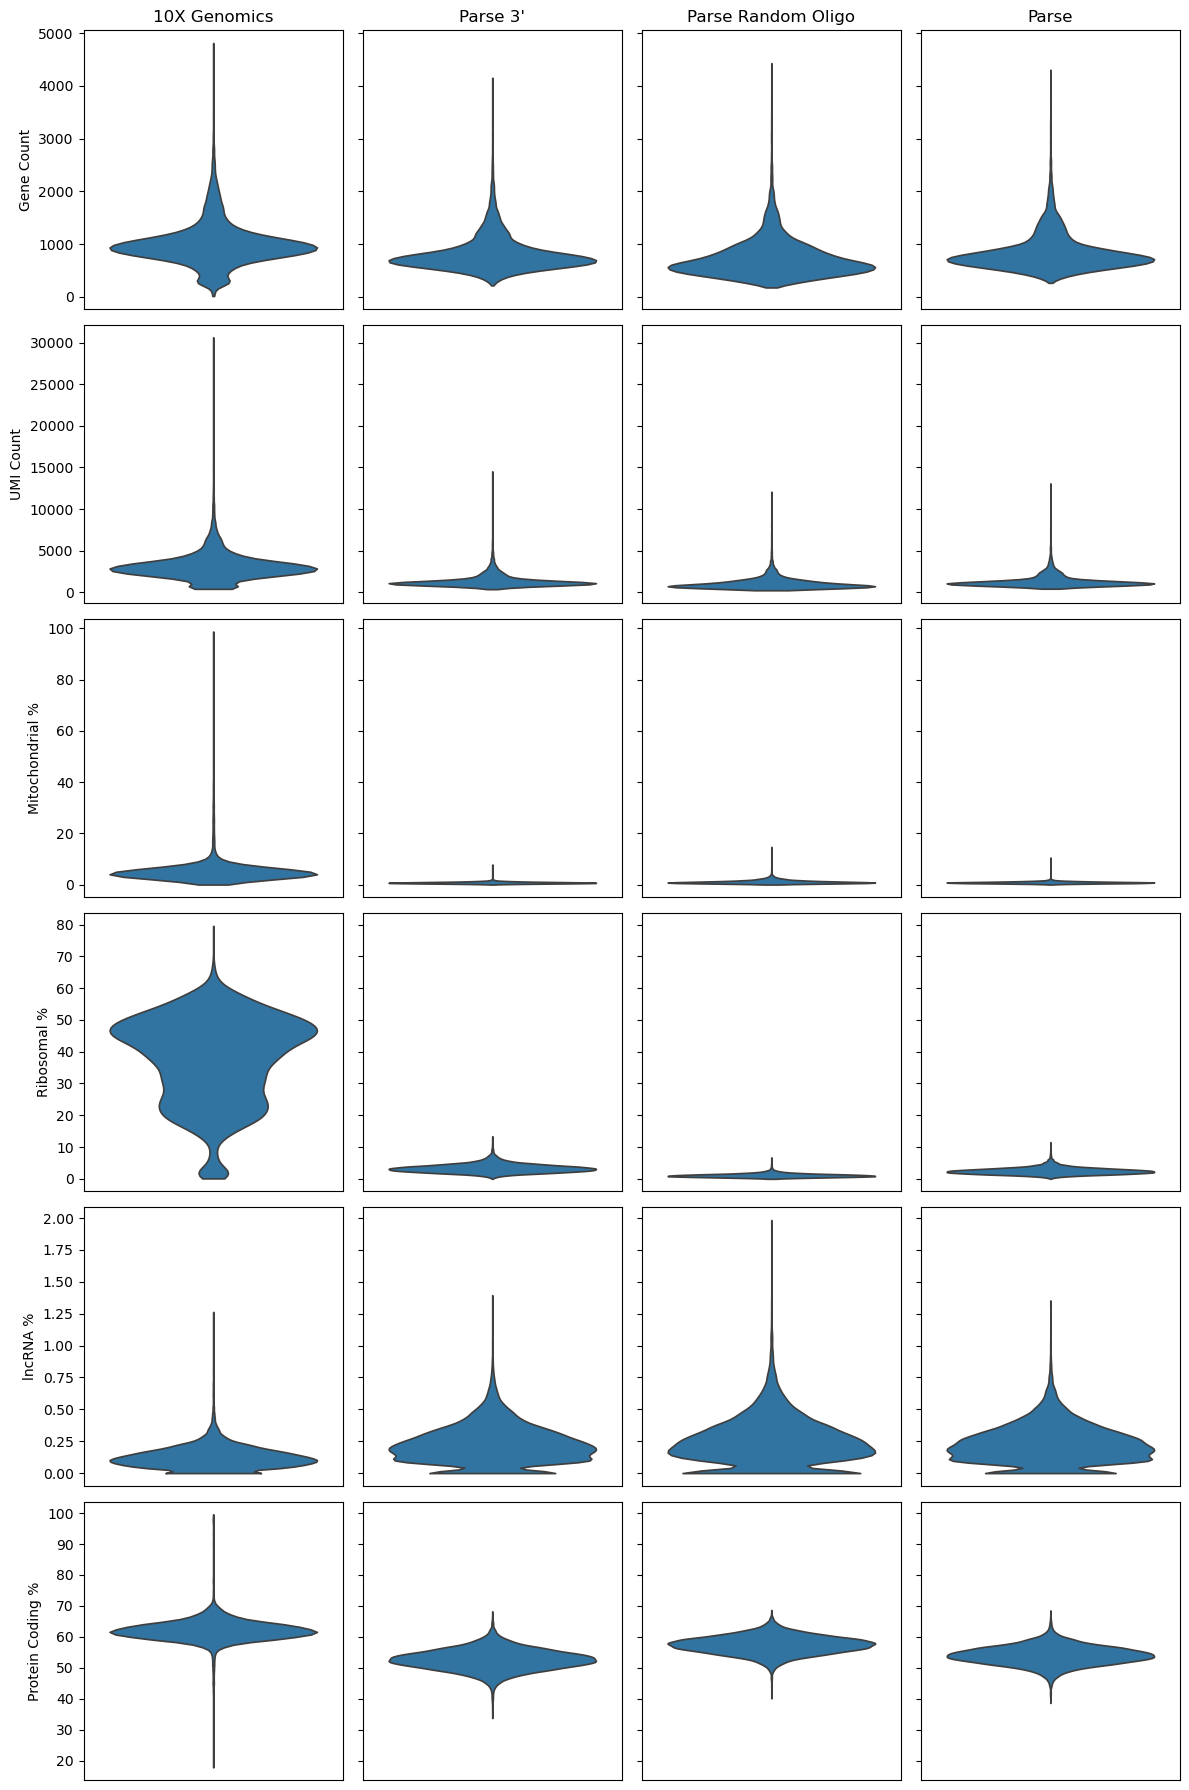

In [81]:
groups = ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc', 'percent_pc']
group_names = ['Gene Count', 'UMI Count', 'Mitochondrial %', 'Ribosomal %', 'lncRNA %', 'Protein Coding %']

fig, ax = plt.subplots(len(groups), 4, figsize=(12,18), sharey='row')
for i, data in enumerate(datasets):
    violin_plots(ax[:, i], data, groups)

for i, group in enumerate(group_names):
    ax[i,0].set_ylabel(group)

for i, data in enumerate(datasets):
    ax[0,i].set_title(data.uns['title'])

plt.tight_layout()
plt.show()

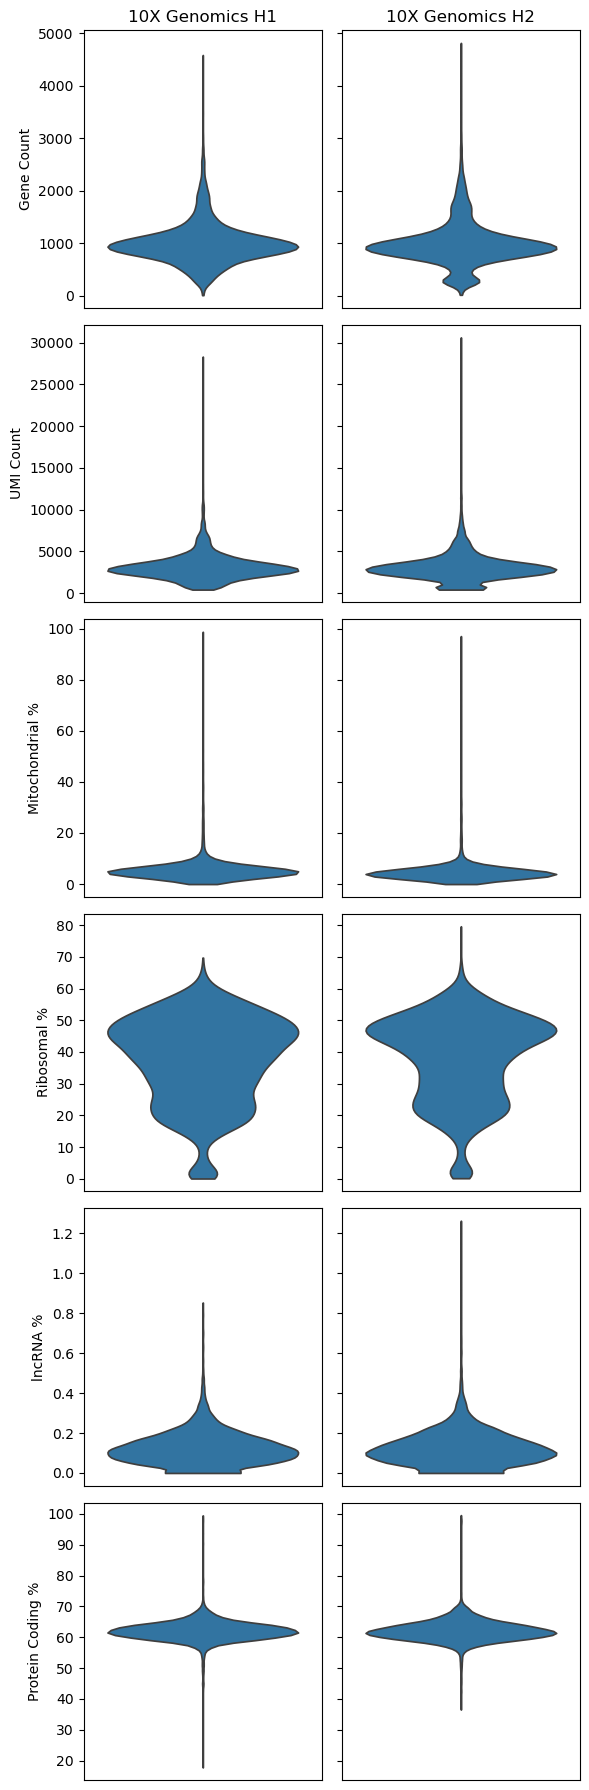

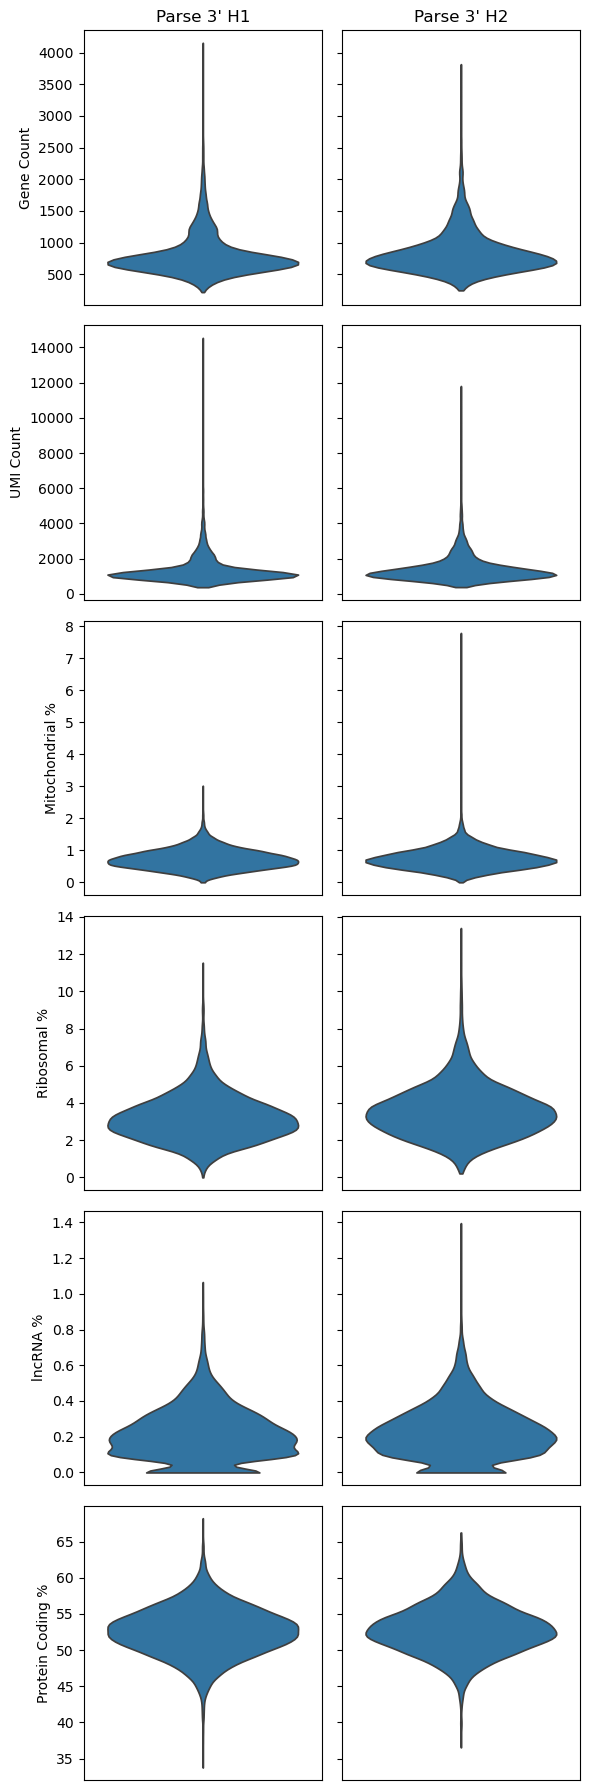

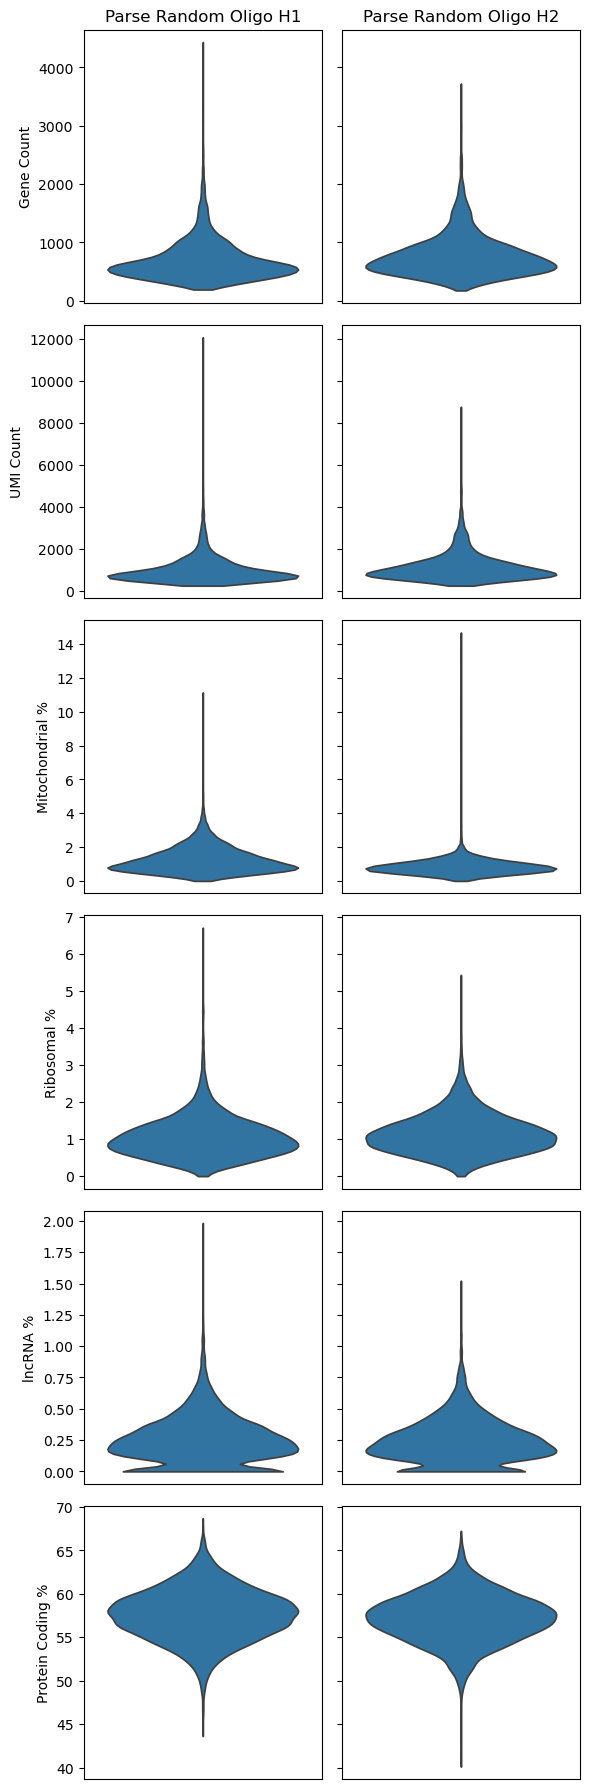

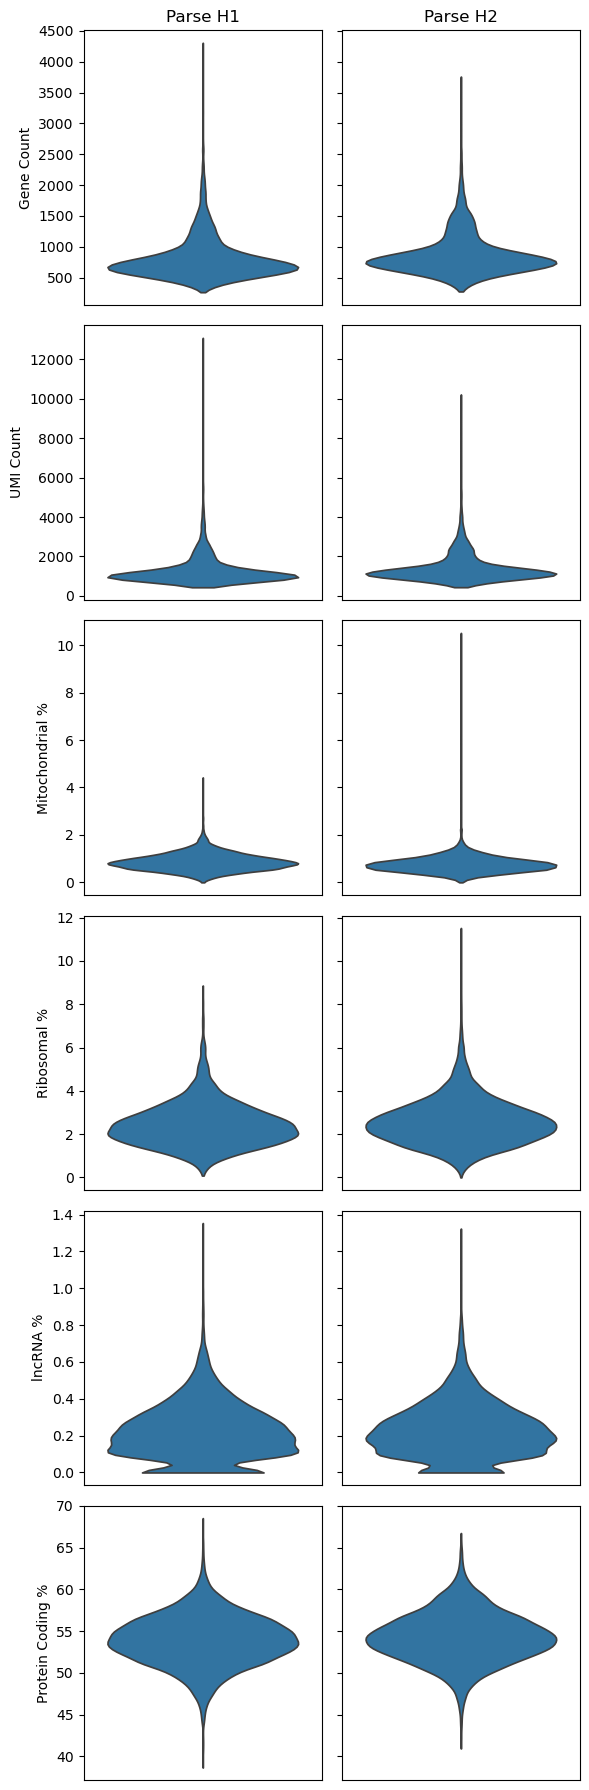

In [82]:
for data in datasets:
    fig, ax = plt.subplots(len(groups), 2, figsize=(6,18), sharey='row')

    for i, sample_name in enumerate(sample_names):
        violin_plots(ax[:, i], data[data.obs['sample'] == sample_name], groups)

    for i, group in enumerate(group_names):
        ax[i,0].set_ylabel(group)

    for i, sample_name in enumerate(sample_names):
        ax[0,i].set_title(data.uns['title'] + ' ' + sample_name)

    plt.tight_layout()
    plt.show()

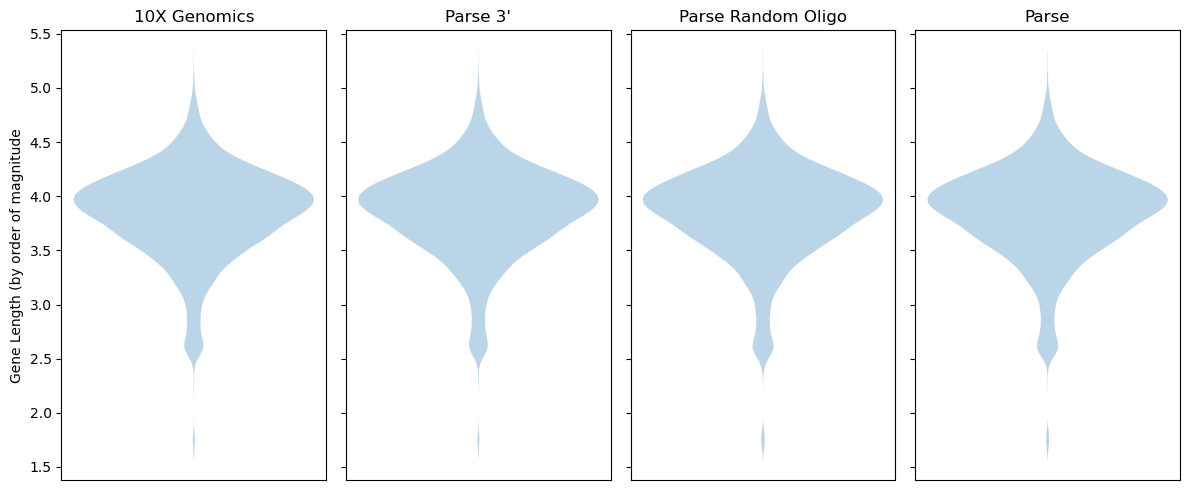

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(12,5), sharey='row')
for i, data in enumerate(datasets):
    lengths = data.var['gene_length'][data.var['gene_length']>1]
    ax[i].violinplot(np.log10(lengths),showextrema=False)
    ax[i].set_title(data.uns['title'])
    ax[i].set_xticks([])

ax[0].set_ylabel('Gene Length (by order of magnitude')


plt.tight_layout()
plt.show()

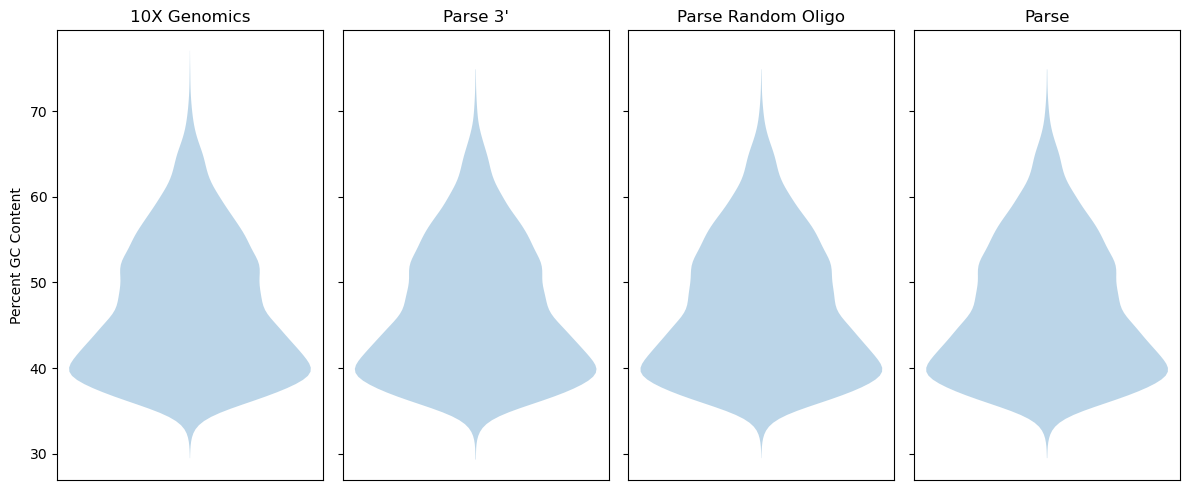

In [84]:
fig, ax = plt.subplots(1, 4, figsize=(12,5), sharey='row')
for i, data in enumerate(datasets):
    gcs = data.var.loc[data.var['gc_content']>0,'gc_content']
    ax[i].violinplot(gcs,showextrema=False)
    ax[i].set_title(data.uns['title'])
    ax[i].set_xticks([])

ax[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

# Doublet Detection Comparison

In [85]:
# Detect doublets Scrublet (by sample is optional)
def doublet_detection(data, sample = None):
    if sample:
        X = data[(data.obs['sample'] == sample).tolist()].X
    scrub = scr.Scrublet(X, random_state = 42)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    if sample:
        data.obs.loc[(data.obs['sample'] == sample).tolist(), 'doublet_score'] = doublet_scores
        data.obs.loc[(data.obs['sample'] == sample).tolist(),'predicted_doublet'] = predicted_doublets
    else:
        data.obs['doublet_score'] = doublet_scores
        data.obs['predicted_doublet'] = predicted_doublets

    return data, scrub

scrubs = []
for data in datasets:
    data.obs['doublet_score'] = np.nan
    data.obs['predicted_doublet'] = False
for data, sample in product(datasets, sample_names):
    data, scrub = doublet_detection(data, sample)
    scrubs.append(scrub)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 37.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.3%
Elapsed time: 8.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 43.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.5%
Elapsed time: 8.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 8.2 seconds
Preprocessing...
Simulating double

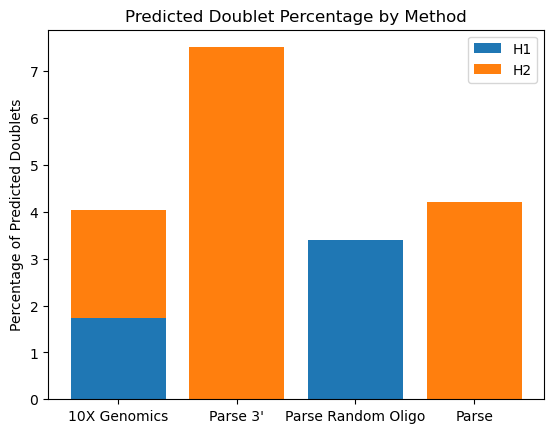

In [86]:
bottom = np.zeros(len(datasets))
titles = [data.uns['title'] for data in datasets]

for sample_name in sample_names:
    percent_doublets = []
    for data in datasets:
        subset = data.obs['predicted_doublet'][data.obs['sample'] == sample_name]
        percent_doublets.append(subset.sum()/len(data.obs) * 100)
    plt.bar(titles, percent_doublets, bottom = bottom)
    bottom = percent_doublets
plt.ylabel('Percentage of Predicted Doublets')
plt.title('Predicted Doublet Percentage by Method')
plt.legend(labels=sample_names)

plt.show()

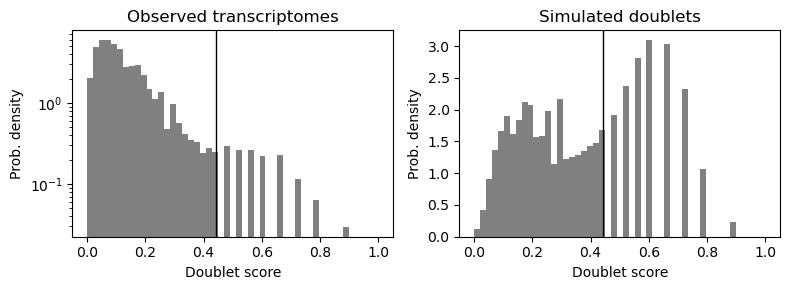

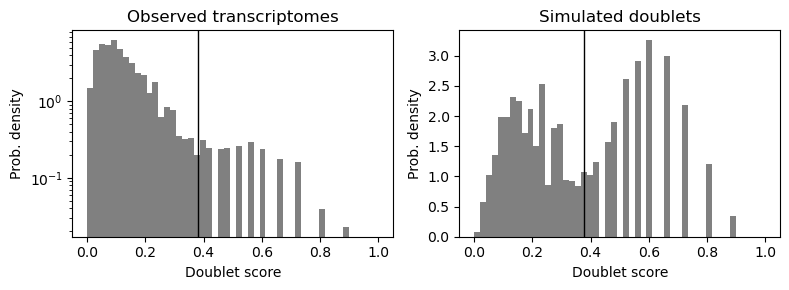

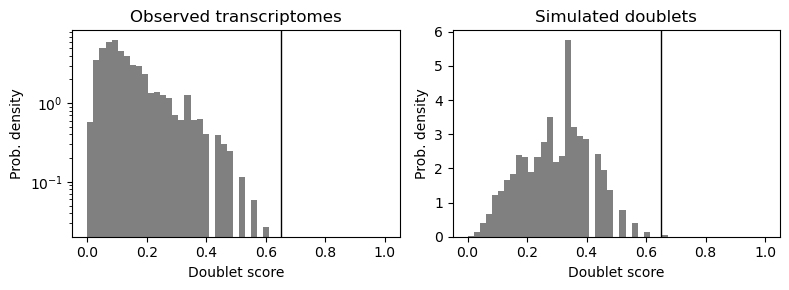

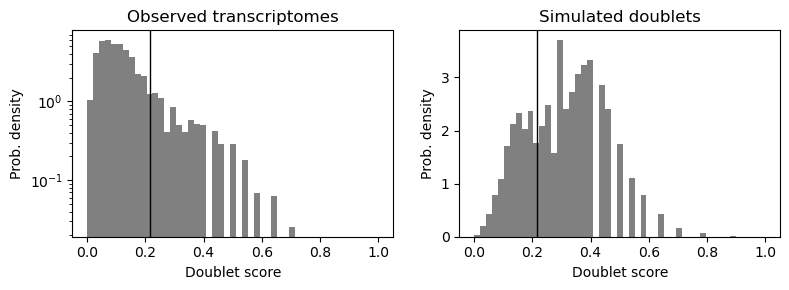

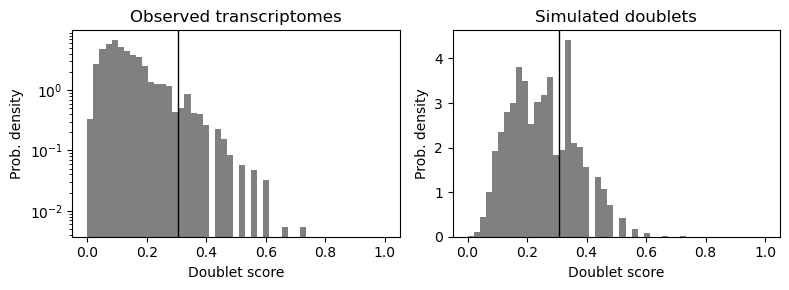

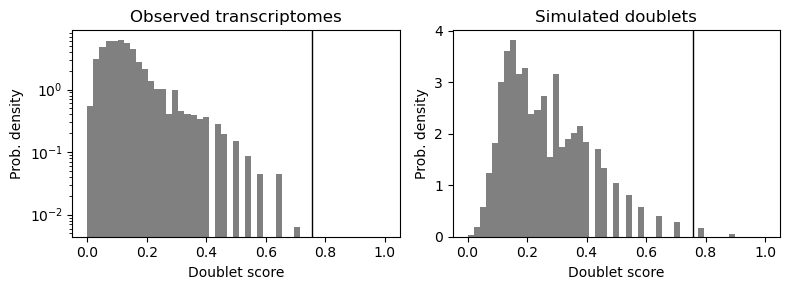

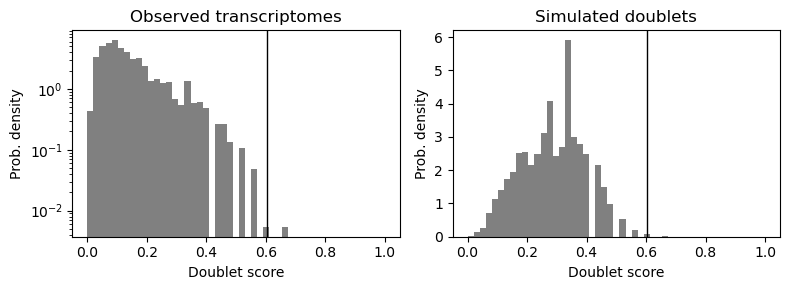

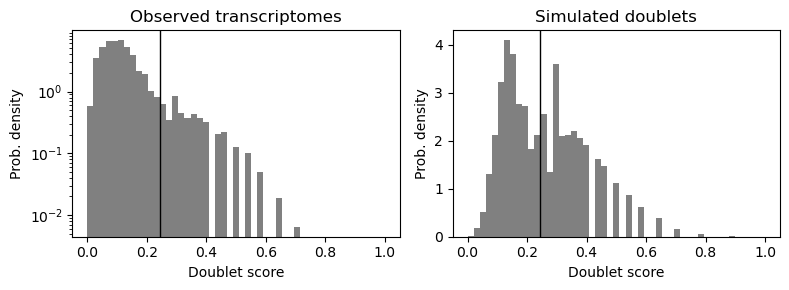

In [87]:
# Should see two peaks separated by threshold
for scrub in scrubs:
    scrub.plot_histogram()

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/

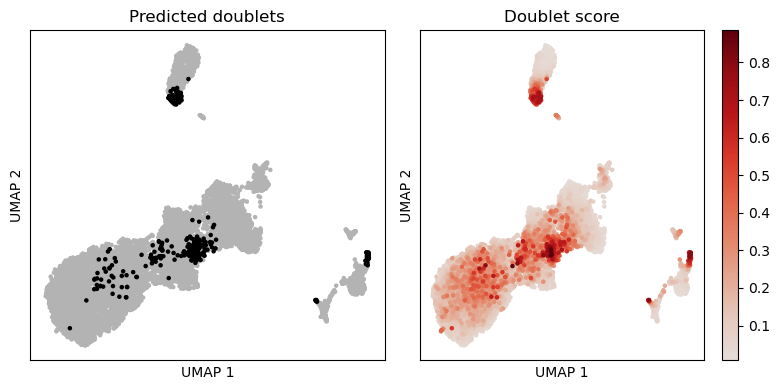

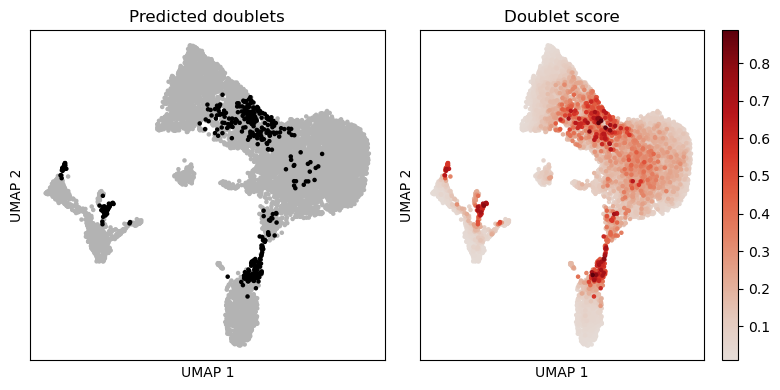

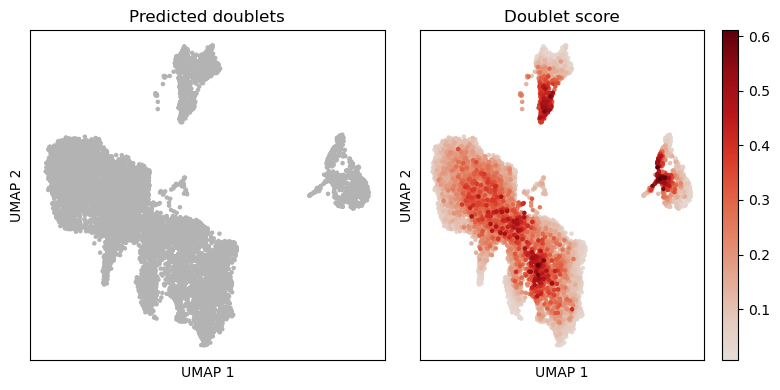

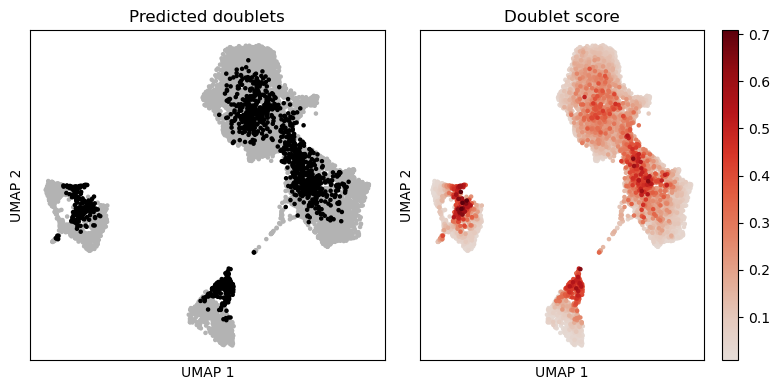

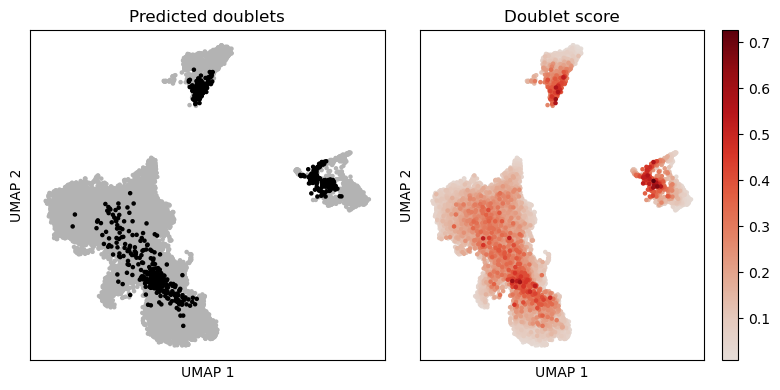

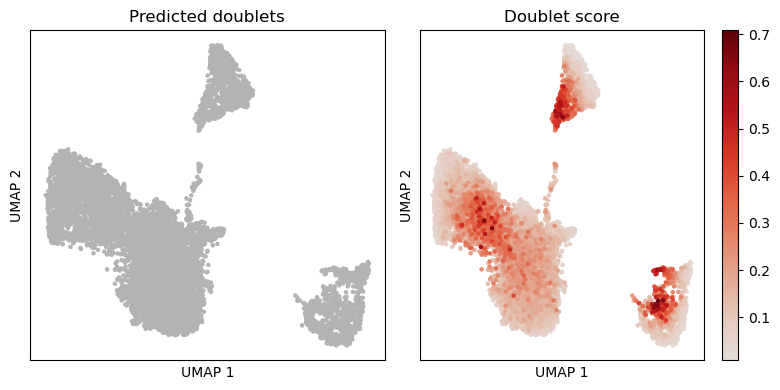

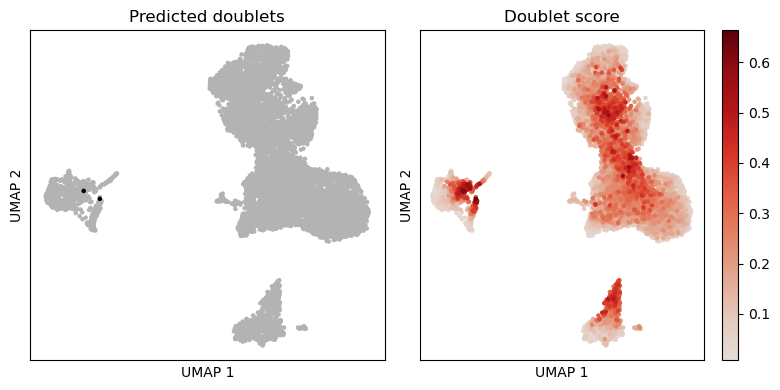

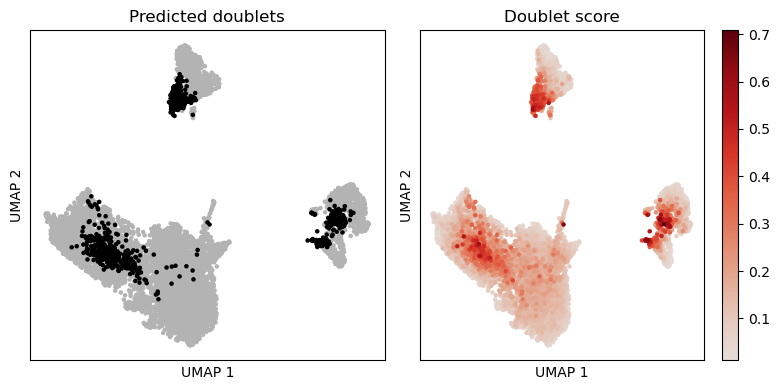

In [88]:
# Should see clustering of doublets
for scrub in scrubs:
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3)) 
    scrub.plot_embedding('UMAP', order_points=True)

# Read/Gene Comparisons

In [89]:
# Marker genes for PBMCs from www.biocompare.com
T_marker_names = ['CD3D', 'CD3G','CD3E', 'CD4', 'CD8A', 'CD8B']
T_markers = ['ENSG00000167286.12', 'ENSG00000160654.11', 
             'ENSG00000198851.10', 'ENSG00000010610.10', 
             'ENSG00000153563.17', 'ENSG00000172116.23']

B_marker_names = ['CD19', 'CD24', 'CD40', 'CD72']
B_markers = ['ENSG00000177455.15', 'ENSG00000272398.6'
             'ENSG00000101017.15', 'ENSG00000137101.14']

NK_marker_names = ['FCGR3A', 'FCGR3B', 'NCAM1']
NK_markers = ['ENSG00000203747.13', 'ENSG00000162747.13', 'ENSG00000149294.18']

monocyte_marker_names = ['CD14'] # and CD16
monocyte_markers = ['ENSG00000170458.15']

markers = T_markers + B_markers + NK_markers + monocyte_markers
marker_names = T_marker_names + B_marker_names + NK_marker_names + monocyte_marker_names

In [90]:
# Displays violin plots of the distributions of 
# of the specified marker genes by cell
def marker_genes(ax, data, markers, by_sample = None):
    gene_dist = []
    for gene in markers:
        gene_percent = np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100)
        gene_dist.append(gene_percent)

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(markers) + 1), markers)
    ax.set_ylabel("")

    if by_sample:
        title = f"{data.uns['title']} {by_sample}"
    else:
        title = data.uns['title']
    ax.set_title(title + " PBMC Marker Genes")

# Displays violin plots of the distributions of the top 10 expressed gene/transcripts
# (by number of cells expressed in) by cell (by sample is optional)
def top_gene_cell_expression(ax, data, by_sample = None):
    s_string = ""
    title = data.uns['title']
    if by_sample:
        data = data[data.obs['sample'] == by_sample]
        title = f"{data.uns['title']} {by_sample}"
        s_string = f"_{by_sample}"

    genes = data.var
    top_genes = genes.sort_values(by=f"n_cells{s_string}",ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")

    ax.set_title(title + " Top 10 Genes by Cell Expression")

# Displays violin plots of the distributions of the top 10 (by total counts) expressed 
# gene/transcripts by cell (by sample is optional)
def top_gene_counts(ax, data, by_sample = None):
    s_string = ""
    title = data.uns['title']
    if by_sample:
        data = data[data.obs['sample'] == by_sample]
        title = f"{data.uns['title']} {by_sample}"
        s_string = f"_{by_sample}"

    genes = data.var
    top_genes = genes.sort_values(by=f"percent_counts{s_string}",ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(title + " Top 10 Genes by Total Counts")

# Compares the gene count percentages between two methods (by sample is optional)
def compare_genes(data_x, data_y, by_sample_x = None, by_sample_y = None):
    sx_string = ""
    if by_sample_x:
        data_x = data_x[data_x.obs['sample'] == by_sample_x]
        sx_string = f"_{by_sample_x}"

    sy_string = ""
    if by_sample_y:
        data_y = data_y[data_y.obs['sample'] == by_sample_y]
        sy_string = f"_{by_sample_y}"

    x_var = data_x.var.reset_index(names='gene_name')
    x_var.drop('n_cells', axis=1,inplace=True)

    y_var = data_y.var.reset_index(names='gene_name')
    y_var.drop('n_cells',axis=1,inplace=True)

    shared_data = pd.merge(x_var, y_var, on=['gene_name','gene_id','gene_length', 'gc_content'], how='outer')
    shared_data.fillna(0,inplace=True)

    for col in ['is_lnc','is_mito','is_ribo','is_pc']:
        shared_data[col] = shared_data[col+"_x"] | shared_data[col+"_y"]
        shared_data.drop(col+"_x",axis=1,inplace=True)
        shared_data.drop(col+"_y",axis=1,inplace=True)

    # Fit linear regression model
    model = sm.OLS(shared_data[f"percent_counts{sy_string}_y"], shared_data[f"percent_counts{sx_string}_x"]).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0] + 1e-10  # add small value to avoid log(0) issues

    # Calculate point density
    xy = np.vstack([shared_data[f"percent_counts{sx_string}_x"].to_numpy().flatten(), shared_data[f"percent_counts{sy_string}_y"].to_numpy().flatten()])
    shared_data['point_density'] = gaussian_kde(xy)(xy)

    return shared_data

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def scatter_genes(ax, shared_data, data_x, data_y, c_column, by_sample_x = None, by_sample_y = None, xlim = None, ylim = None, norm = None):
    sx_string = ""
    x_title = data_x.uns['title']
    if by_sample_x:
        x_title = f"{data_x.uns['title']} {by_sample_x}"
        sx_string = f"_{by_sample_x}"

    sy_string = ""
    y_title = data_y.uns['title']
    if by_sample_y:
        y_title = f"{data_y.uns['title']} {by_sample_y}"
        sy_string = f"_{by_sample_y}"
    
    x_percent = shared_data[f"percent_counts{sx_string}_x"]
    y_percent = shared_data[f"percent_counts{sy_string}_y"]

    plot = ax.scatter(x_percent, 
                y_percent, 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data[c_column], 
                cmap='viridis')
    
    ax.set_xlabel(x_title + ' Gene Percent Count')
    ax.set_ylabel(y_title + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    return plot

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def cat_scatter_genes(ax, shared_data, data_x, data_y, color, by_sample_x = None, by_sample_y = None, label=None, xlim = None, ylim = None):
    sx_string = ""
    x_title = data_x.uns['title']
    if by_sample_x:
        x_title = f"{data_x.uns['title']} {by_sample_x}"
        sx_string = f"_{by_sample_x}"

    sy_string = ""
    y_title = data_y.uns['title']
    if by_sample_y:
        y_title = f"{data_y.uns['title']} {by_sample_y}"
        sy_string = f"_{by_sample_y}"

    x_percent = shared_data[f"percent_counts{sx_string}_x"]
    y_percent = shared_data[f"percent_counts{sy_string}_y"]

    plot = ax.scatter(x_percent, 
                y_percent, 
                s=50,
                alpha=0.5, 
                c=color,
                label=label)
    
    ax.set_xlabel(x_title + ' Gene Percent Count')
    ax.set_ylabel(y_title + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    return plot

# Displays correlation of percent counts from the output of compare_genes on the plot 
# given by ax
def show_correlation(ax, shared_data, by_sample_x = None, by_sample_y = None):
    sx_string = ""
    if by_sample_x:
        sx_string = f"_{by_sample_x}"

    sy_string = ""
    if by_sample_y:
        sy_string = f"_{by_sample_y}"

    # Data on which to calculate correlatoin
    x_percent = shared_data[f"percent_counts{sx_string}_x"]
    y_percent = shared_data[f"percent_counts{sy_string}_y"]

    #Calculate correlation
    pearson_r = pearsonr(x_percent, y_percent).correlation
    spearman_r = spearmanr(x_percent, y_percent).correlation
    
    x_mean = x_percent.mean()
    y_mean = y_percent.mean()
    x_std = x_percent.std()
    y_std = y_percent.std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)    

    ax.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=1.5)  # y=x line

    # Add plot annotations
    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return

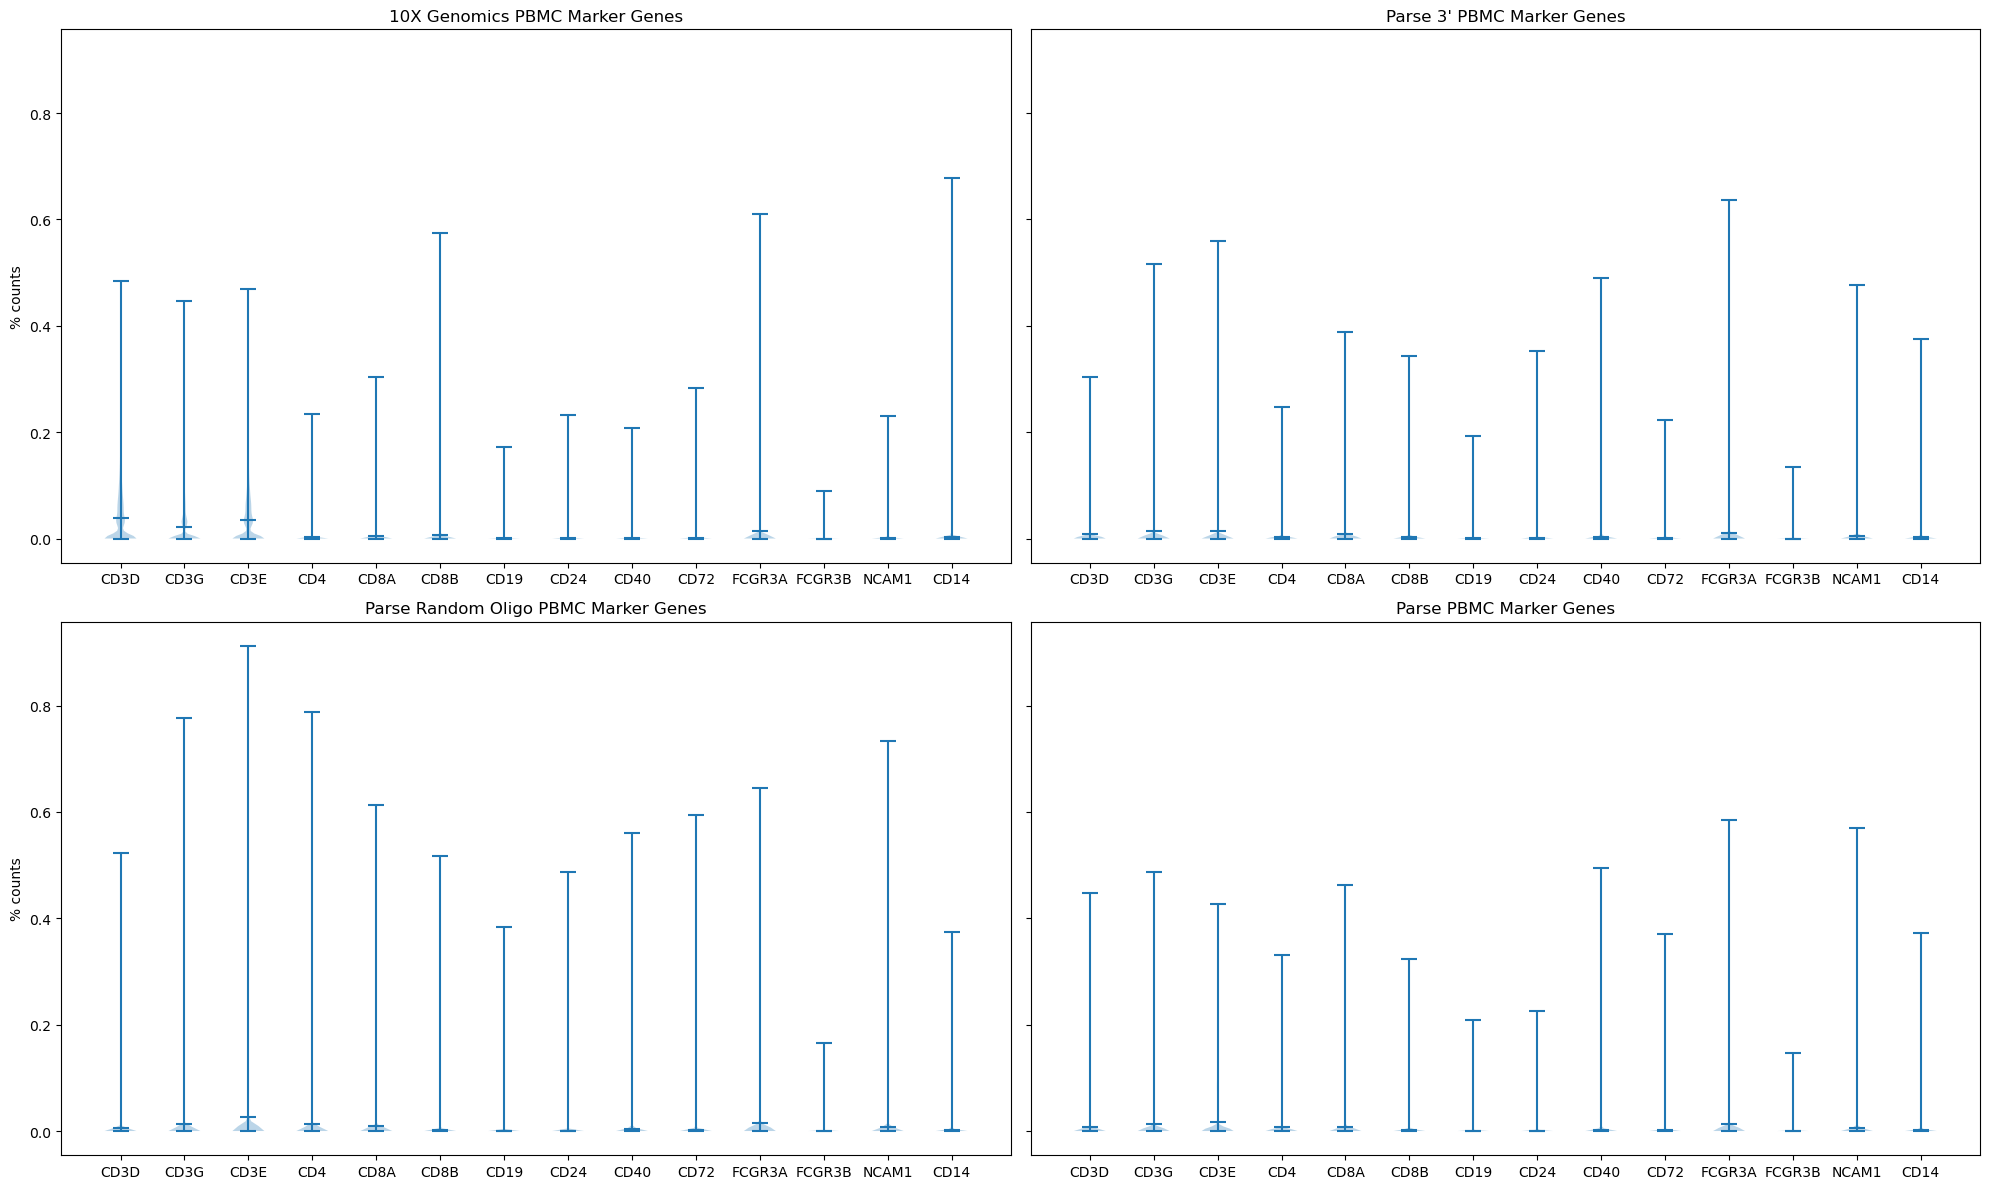

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(20,12), sharey=True)
ax = ax.flatten()

for i, data in enumerate(datasets):
    marker_genes(ax[i], data, marker_names)

ax[0].set_ylabel("% counts")
ax[2].set_ylabel("% counts")

plt.tight_layout()
plt.show()

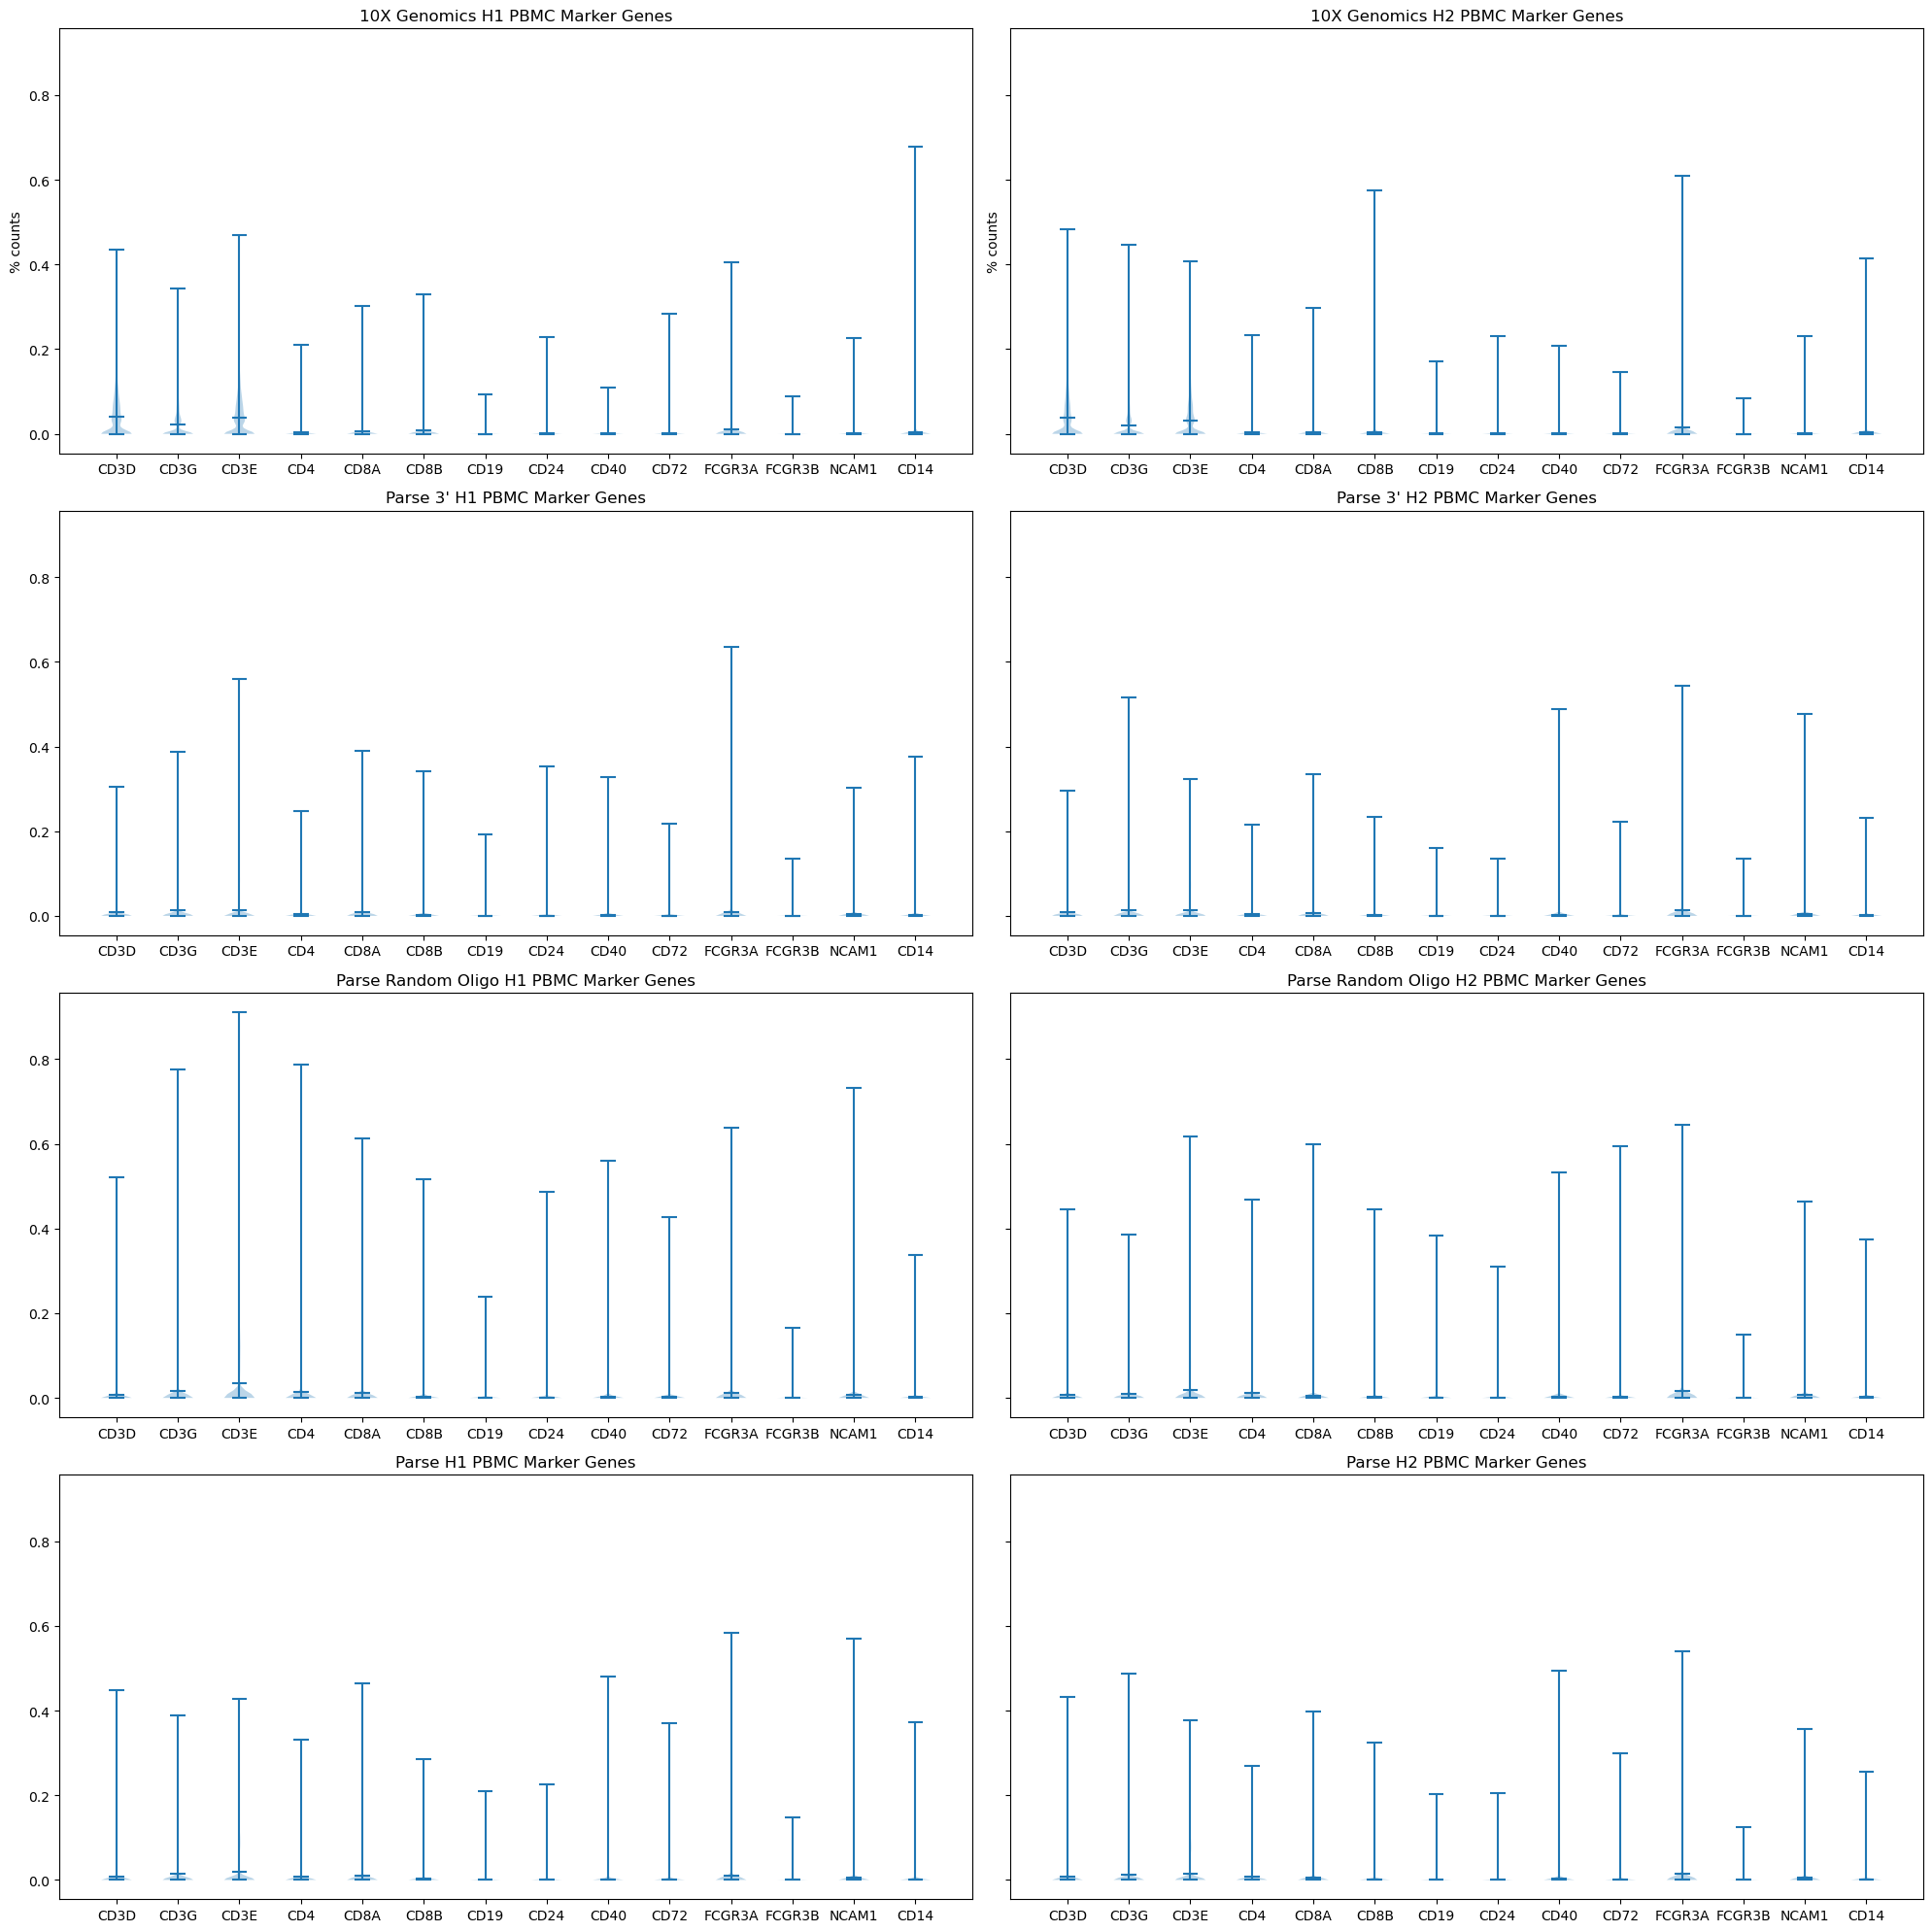

In [92]:
fig, ax = plt.subplots(4, 2, figsize=(20,20), sharey=True)

for i, data in enumerate(datasets):
    for j, sample_name in enumerate(sample_names):
        marker_genes(ax[i,j], data[data.obs['sample']==sample_name], marker_names)
        ax[i,j].set_title(f"{data.uns['title']} {sample_name} PBMC Marker Genes")
        ax[0,j].set_ylabel("% counts")

plt.tight_layout()
plt.show()

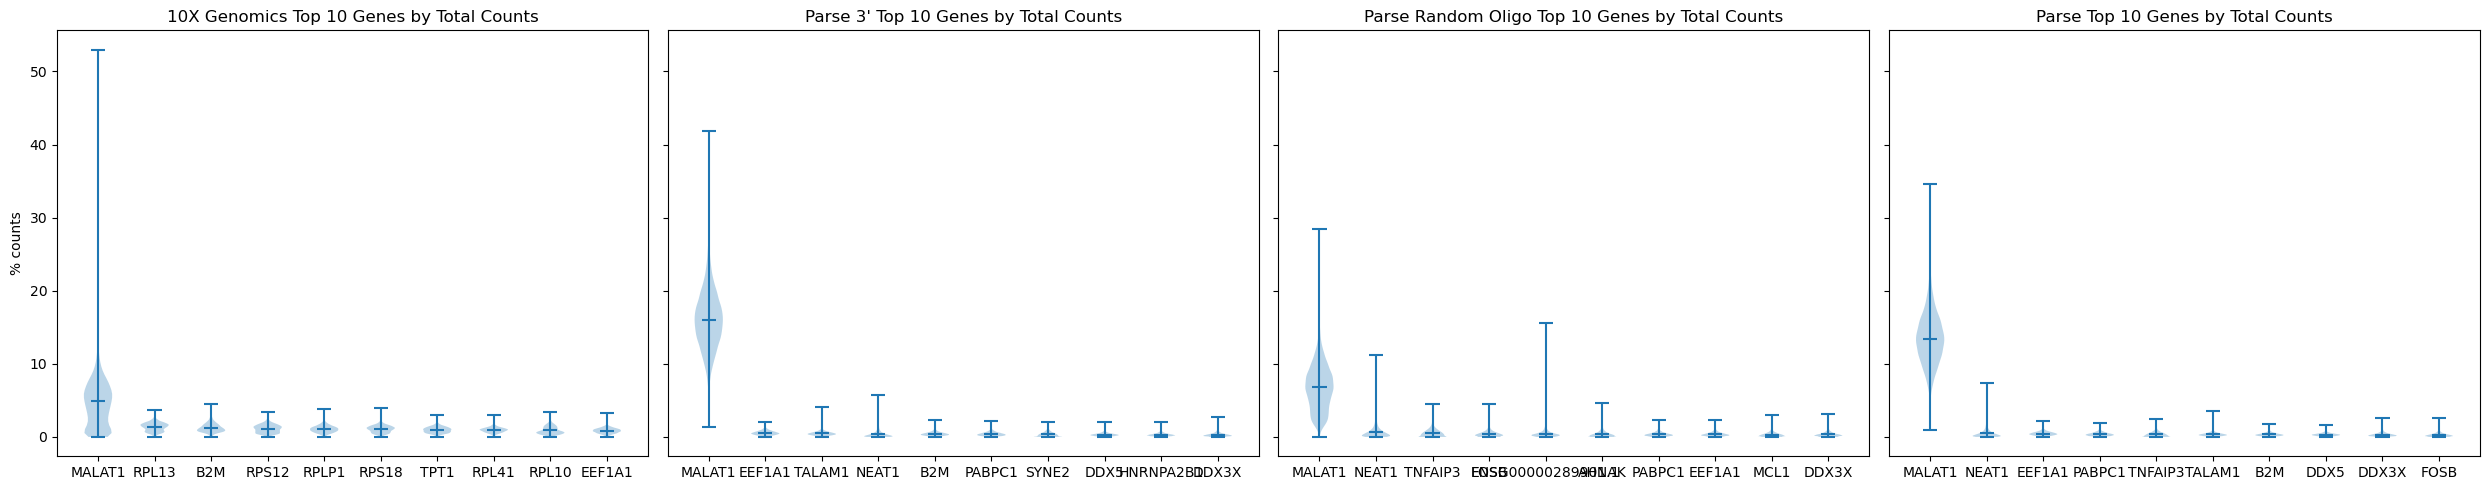

In [93]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    top_gene_counts(ax[i], data)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

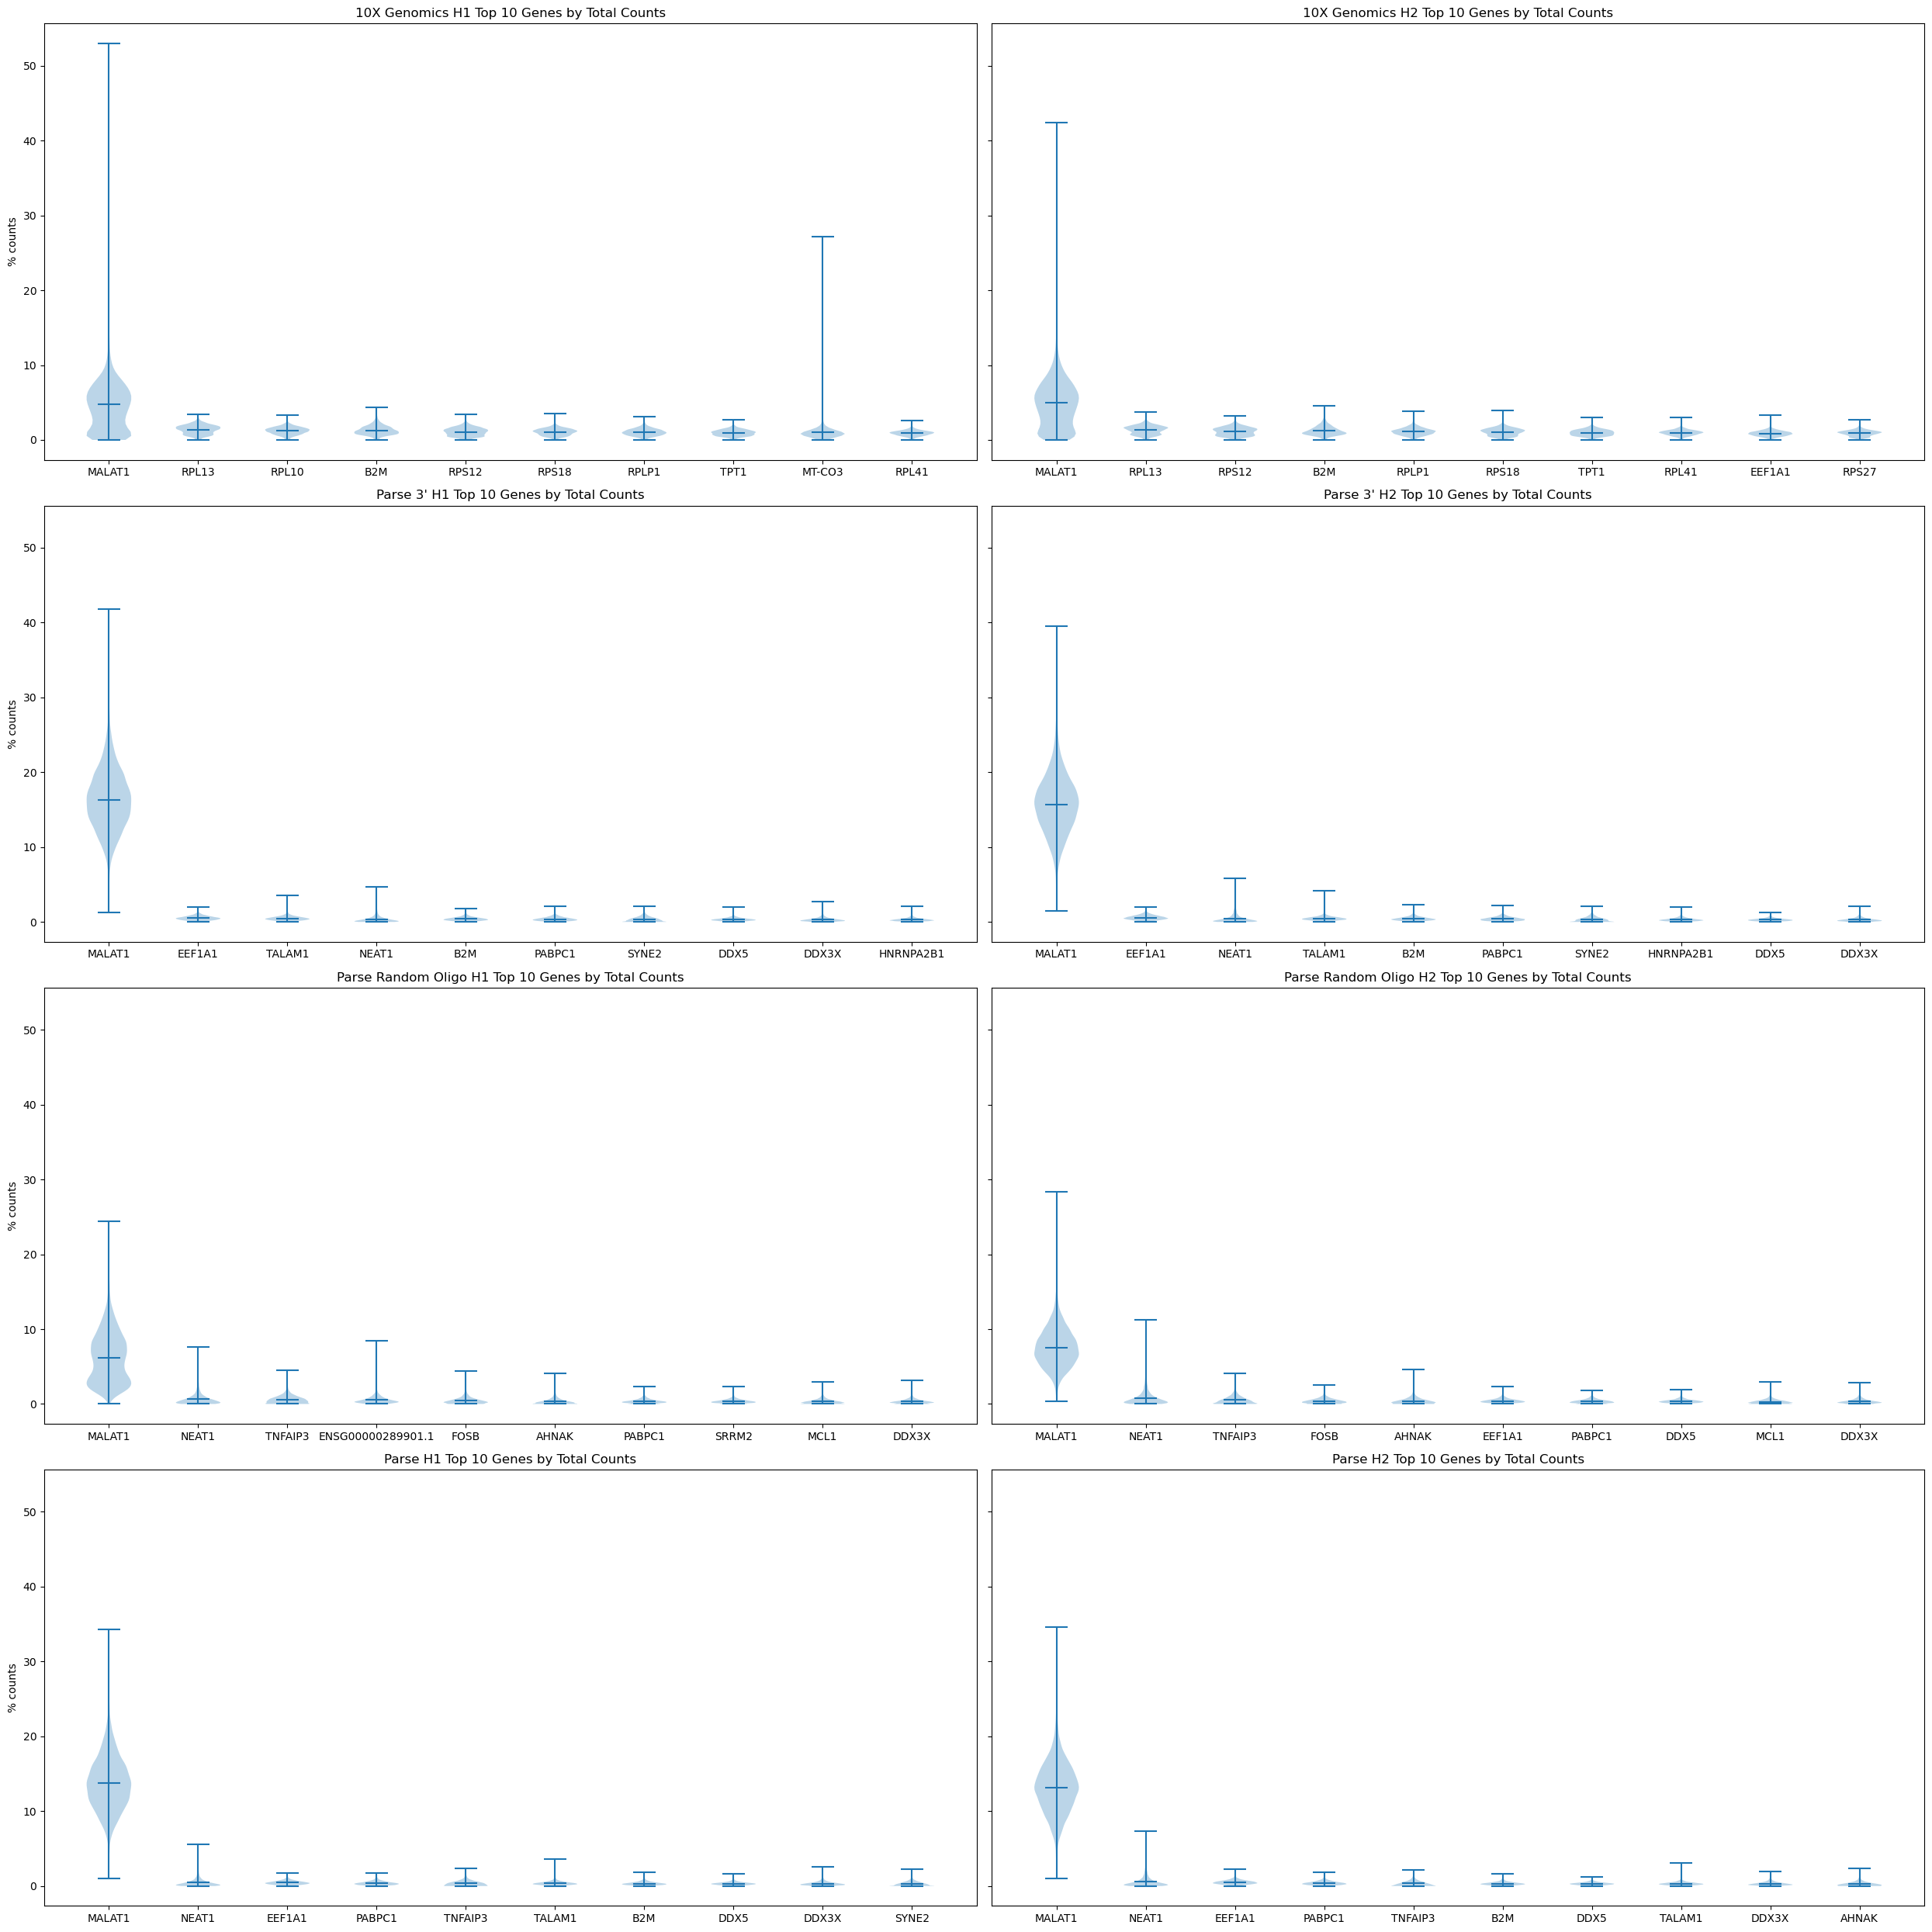

In [94]:
fig, ax = plt.subplots(4, 2, figsize=(25,25), sharey=True)

for i, data in enumerate(datasets):
    for j, sample_name in enumerate(sample_names):
        top_gene_counts(ax[i,j], data, by_sample = sample_name)
        ax[i,j].set_title(f"{data.uns['title']} {sample_name} Top 10 Genes by Total Counts")
        ax[i,0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

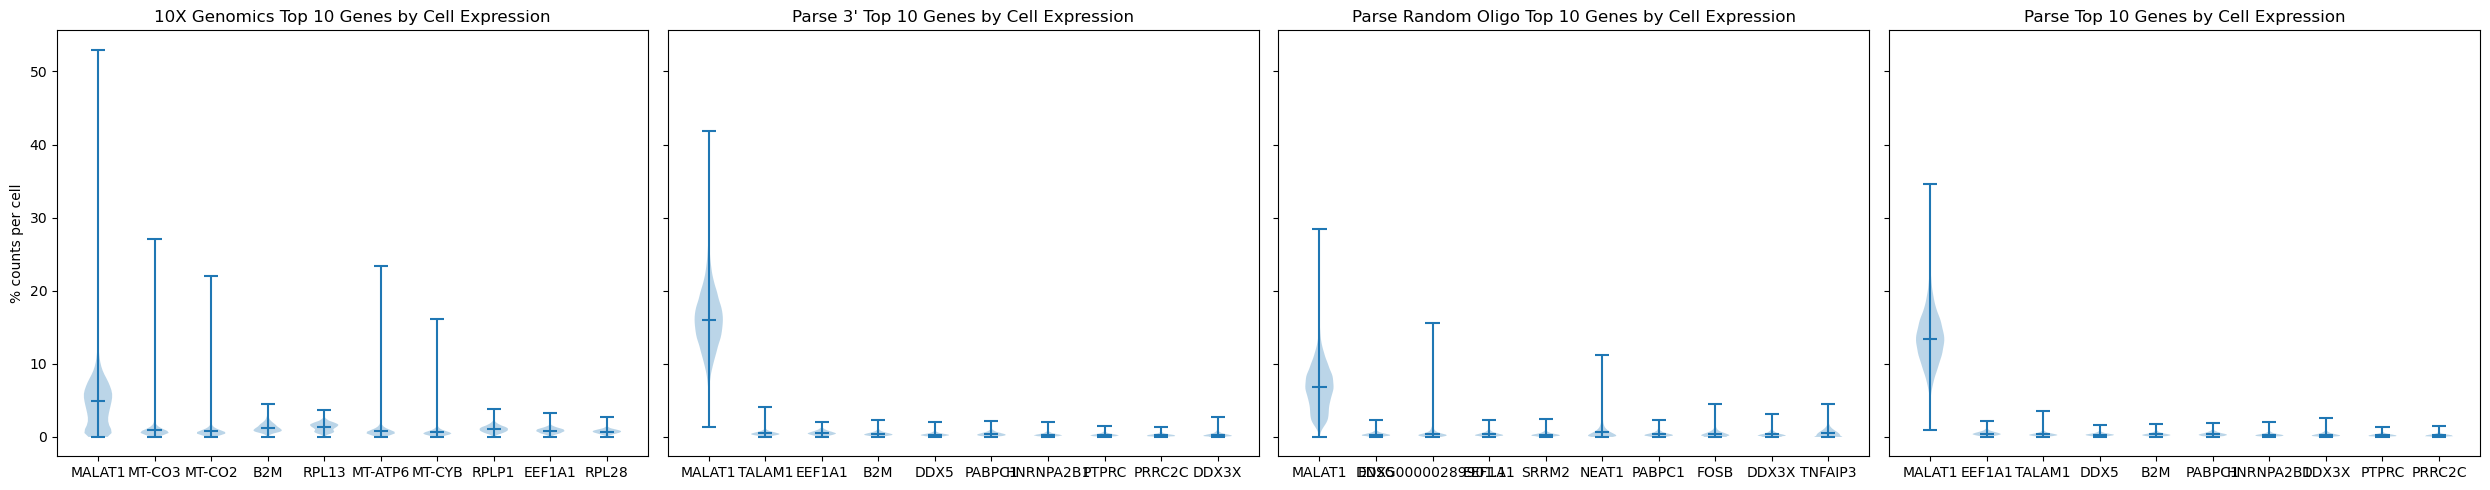

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
for i, data in enumerate(datasets):
    top_gene_cell_expression(ax[i], data)

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

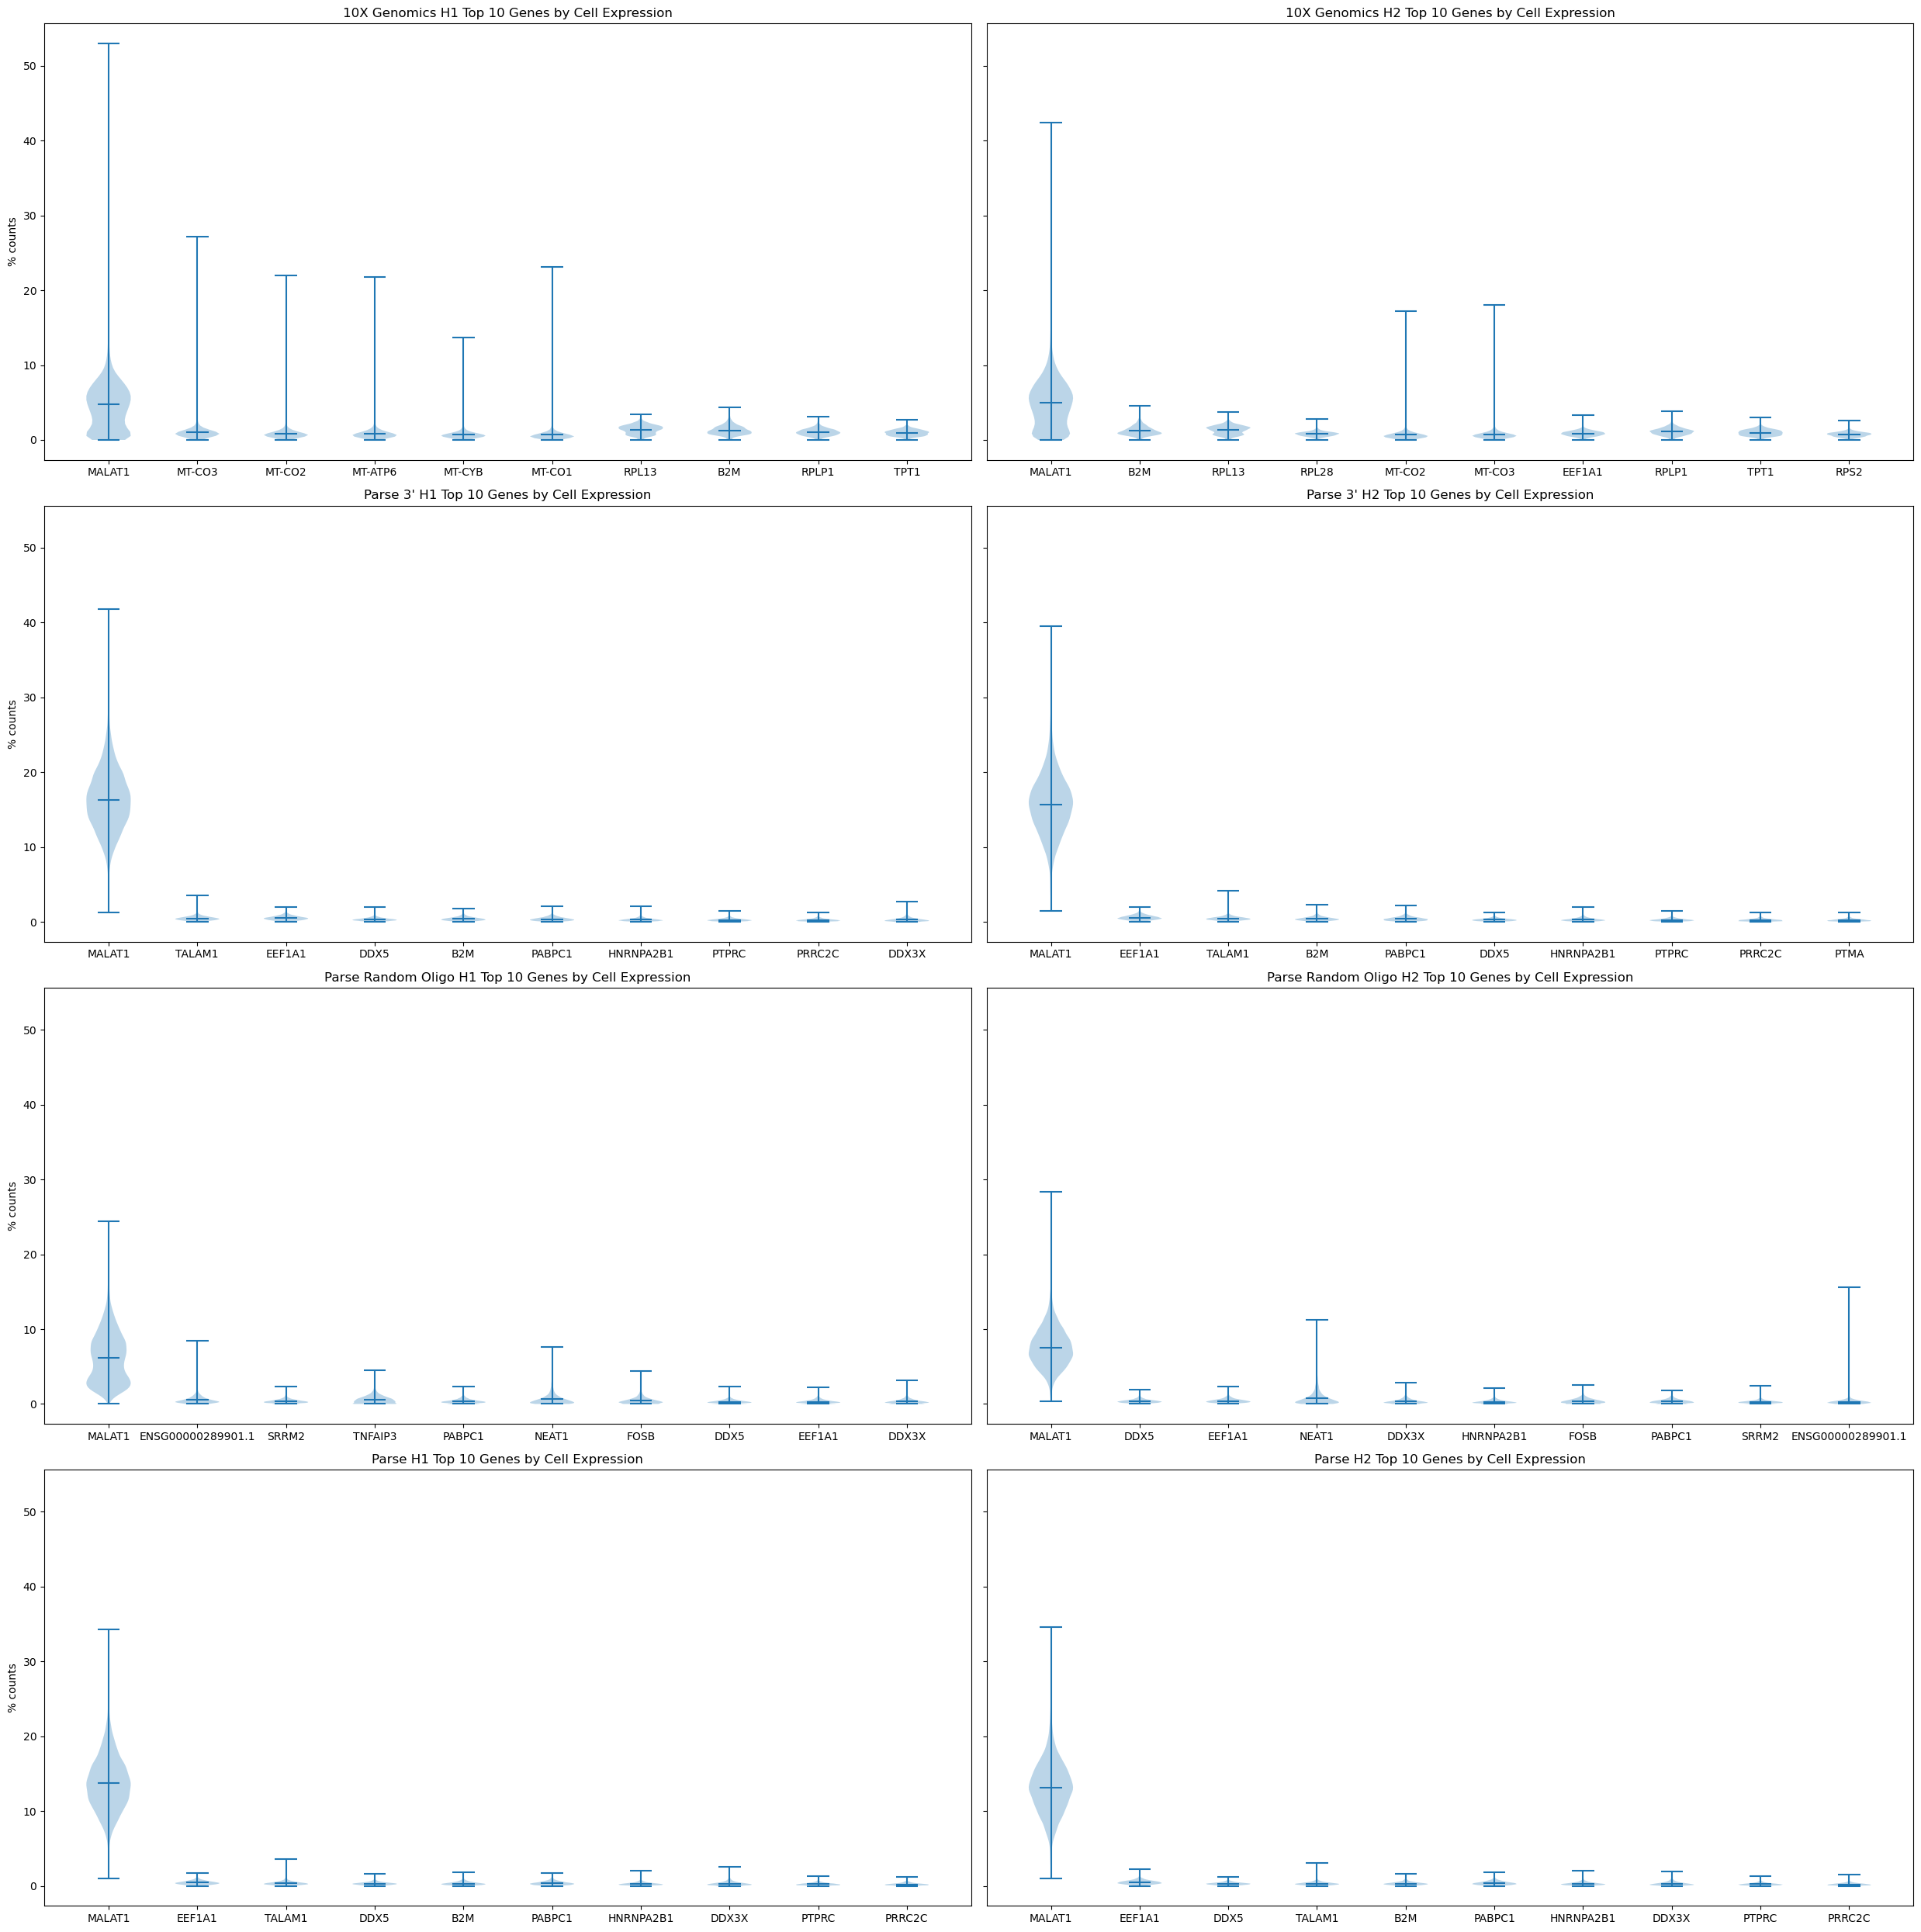

In [96]:
fig, ax = plt.subplots(4, 2, figsize=(25,25), sharey=True, sharex=False)

for i, data in enumerate(datasets):
    for j, sample_name in enumerate(sample_names):
        top_gene_cell_expression(ax[i,j], data, by_sample = sample_name)
        ax[i,j].set_title(f"{data.uns['title']} {sample_name} Top 10 Genes by Cell Expression")
        ax[i,0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

In [97]:
# Generate scatter plot comparing two samples from the same method
def compareSamples(datasets, lim):
    compare_dfs = []
    comparisons = []
    for data in datasets:
        compare_dfs.append(compare_genes(data, data, by_sample_x = sample_names[0], by_sample_y = sample_names[1]))
        comparisons.append([data, data])

    fig, axs = plt.subplots(1, 4, figsize = (25, 5))

    c_values = []
    for df in compare_dfs:
        c_values.extend(df['point_density'].tolist())
    norm = LogNorm(min(c_values), max(c_values))

    for ax, df , pair in zip(axs, compare_dfs, comparisons):
        plot = scatter_genes(ax, 
                            df, 
                            pair[0],
                            pair[1], 
                            'point_density', 
                            by_sample_x=sample_names[0],
                            by_sample_y=sample_names[1],
                            xlim=lim, 
                            ylim=lim, 
                            norm=norm)
        show_correlation(ax,df,
                        by_sample_x=sample_names[0],
                        by_sample_y=sample_names[1])

    fig.colorbar(plot, label = "Density")

    plt.tight_layout()
    plt.show()

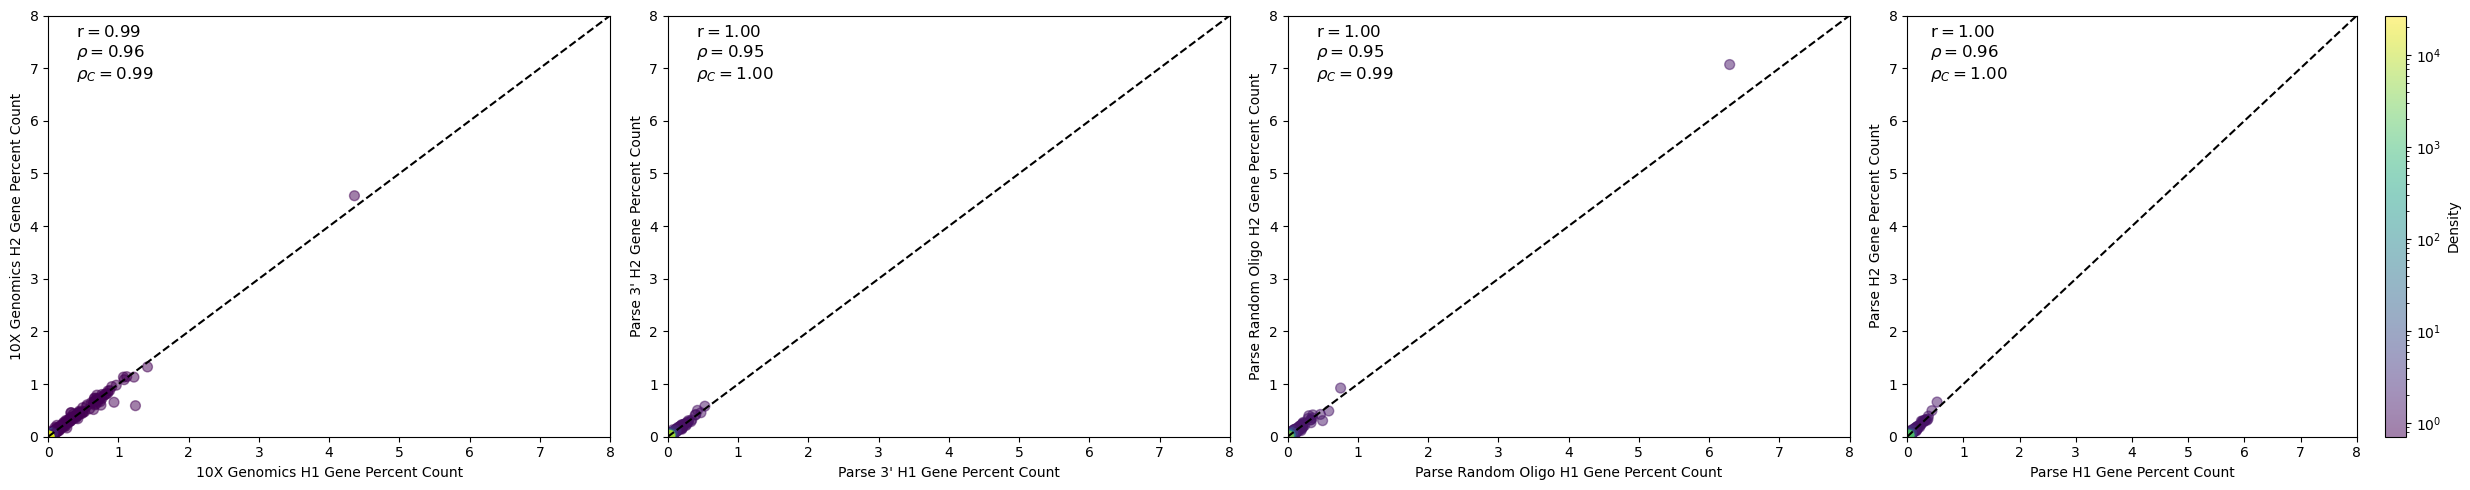

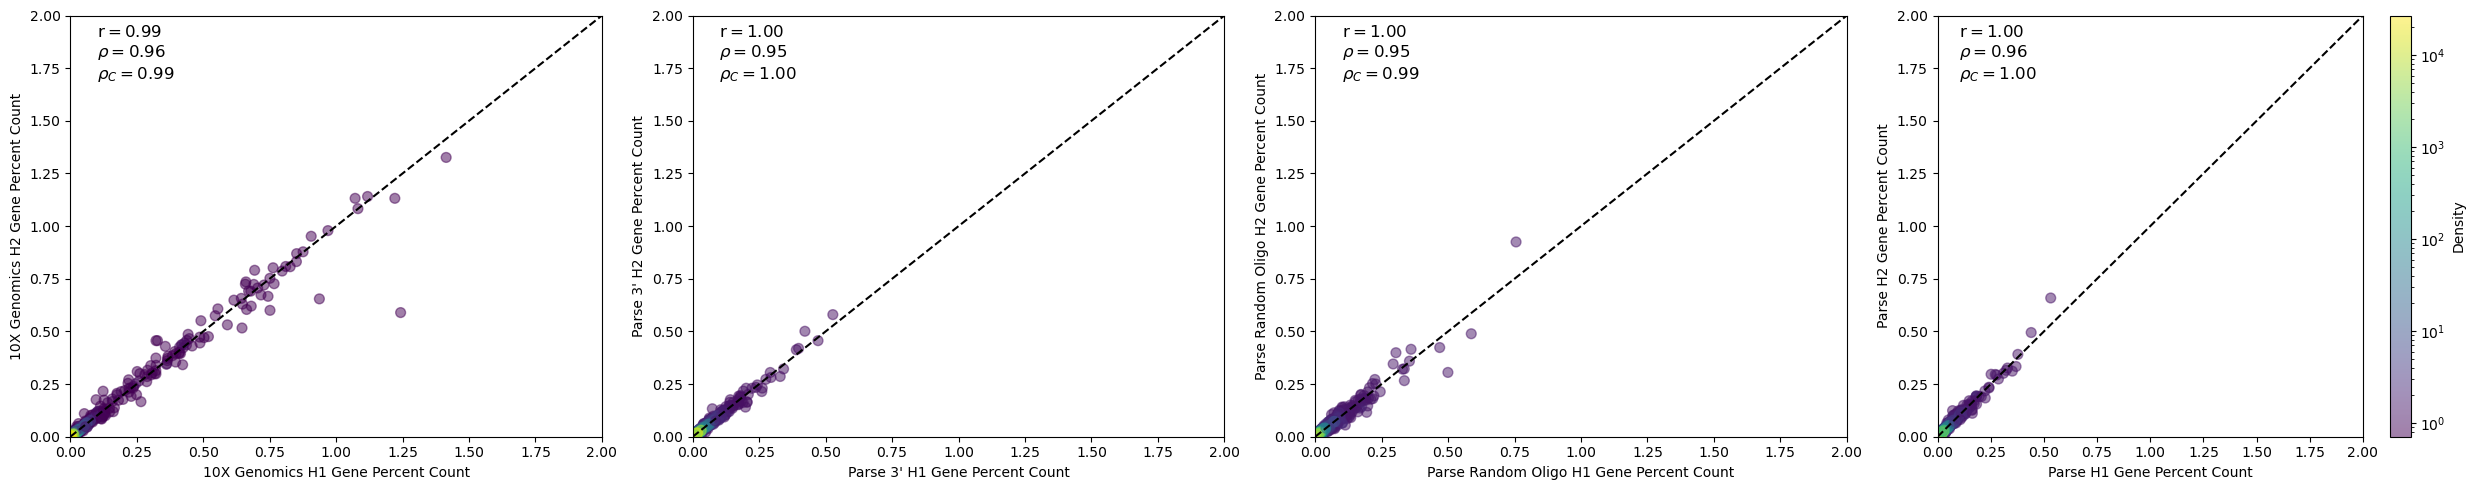

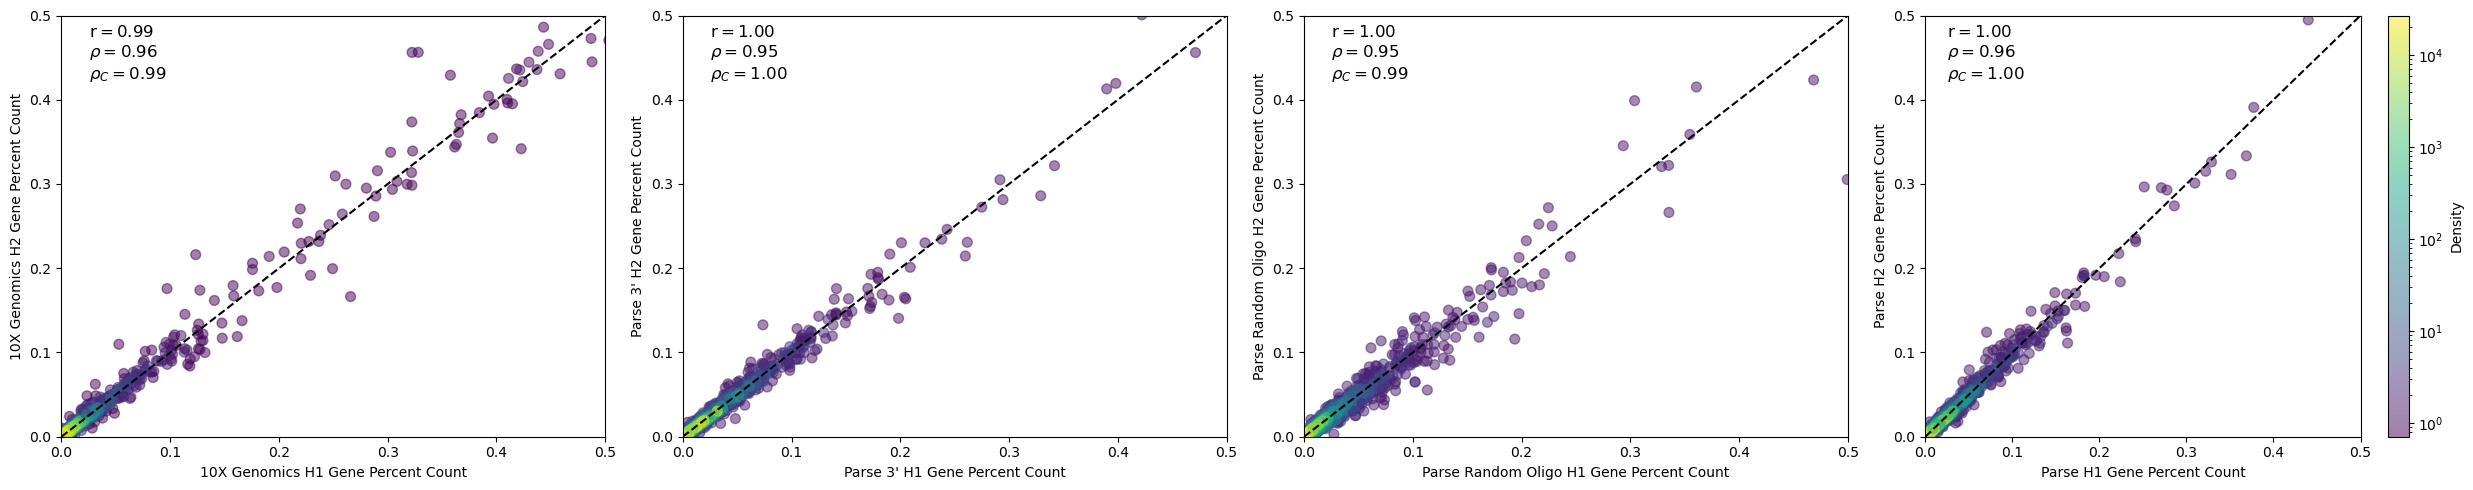

In [98]:
compareSamples(datasets, 8)
compareSamples(datasets, 2)
compareSamples(datasets, 0.5)

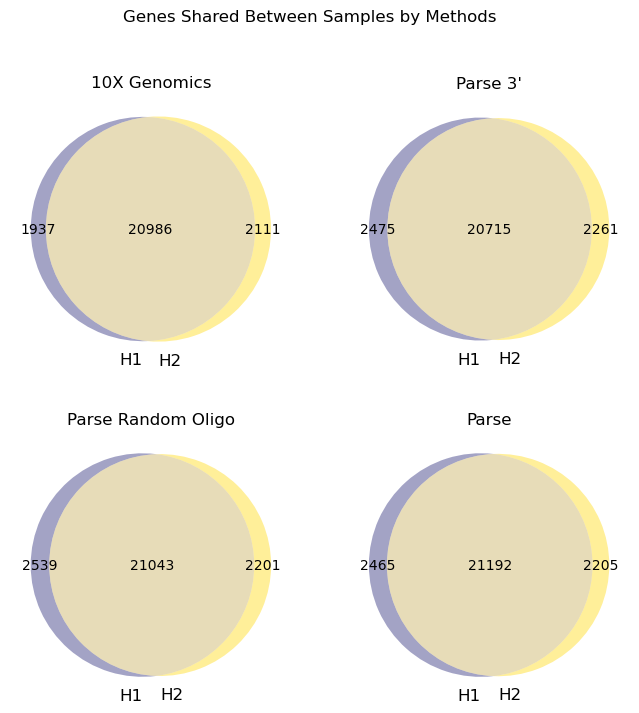

In [99]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = axs.flatten()

for ax, data in zip(axs, datasets):
    genes_by_sample = []
    for sample_name in sample_names:
        sample_genes = data.var.index[data.var[f"n_cells_{sample_name}"]>0].tolist()
        genes_by_sample.append(sample_genes)
    
    inter = len(set(genes_by_sample[0]).intersection(set(genes_by_sample[1])))
    samp1 = len(genes_by_sample[0]) - inter
    samp2 = len(genes_by_sample[1]) - inter
    
    venn2(subsets=(samp1, samp2, inter), 
          set_labels=(sample_names[0], sample_names[1]),
          ax = ax,
          set_colors = ("midnightblue", "gold"))
    
    ax.set_title(data.uns['title'])

fig.suptitle('Genes Shared Between Samples by Methods')
plt.show()

In [100]:
# Plot a scatter plot of comparing gene percent counts between methods given 
# some metric with which to color the plot
def comparisonPlotter(compare_dfs, comparisons, norm, lim, metric, metric_name):
    fig, axs = plt.subplots(1, 4, figsize = (25, 5))

    for ax, df , pair in zip(axs, compare_dfs,comparisons):
        plot = scatter_genes(ax, 
                            df, 
                            pair[0],
                            pair[1], 
                            metric, 
                            xlim=lim, 
                            ylim=lim, 
                            norm=norm)
        show_correlation(ax,df)

    fig.colorbar(plot, label = metric_name)

    plt.tight_layout()
    plt.show()

# Compare gene percent counts between methods and 
# color by density
def compareByDensity(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        c_values.extend(df['point_density'].tolist())
    norm = LogNorm(min(c_values), max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'point_density',
                      'Density')

# Compare gene percent counts between methods and 
# color by Cook's Distance
def compareByCooks(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        c_values.extend(df['cooks_distance'].tolist())
    norm = LogNorm(min(c_values), max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'cooks_distance',
                      "Cook's Distance")
    
# Compare gene percent counts between methods and 
# color by gene length
def compareByLength(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        df['gene_length'] = df['gene_length']+1
        c_values.extend(df['gene_length'].tolist())
    norm = LogNorm(1, max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'gene_length',
                      'Gene Length')

# Compare gene percent counts between methods and 
# color by GC content
def compareByGC(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        c_values.extend(df['gc_content'].tolist())
    norm = Normalize(0, max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'gc_content',
                      'Percent GC Content')

# Compare gene percent counts between methods and 
# color by biotype
def compareByType(compare_dfs, comparisons, lim):
    fig, axs = plt.subplots(1, 4, figsize = (25, 5))

    for ax, df , pair in zip(axs, compare_dfs,comparisons):
        cat_scatter_genes(ax, df[~(df['is_mito'] | df['is_ribo'] | df['is_lnc'])], 
                        pair[0], pair[1],'black', 
                        label = 'unspecified non-coding', xlim=lim, ylim=lim)
        for col, c, label in zip(['is_pc', 'is_mito','is_ribo','is_lnc'],
                                ['yellow', 'blue', 'red', 'green'],
                                ['protein coding', 'mtRNA', 'rRNA', 'lncRNA']):
            cat_scatter_genes(ax, df[df[col]], pair[0], pair[1], 
                            c, label=label,xlim=lim, ylim=lim)

        show_correlation(ax,df)
        
    axs[0].legend()

    plt.tight_layout()
    plt.show()

# Generate scatter plots to 
# (1) PolyT vs. RandO (2) 10X vs. PolyT 
# (3) 10X vs. RandO (3) 10X vs. Parse
# compare data in the range specified by lim
def compare(datasets, lim):
    data_10x = datasets[0][:,datasets[0].var['percent_counts'] < lim]
    data_polyT = datasets[1][:,datasets[1].var['percent_counts'] < lim]
    data_randO = datasets[2][:,datasets[2].var['percent_counts'] < lim]
    data_parse = datasets[3][:,datasets[3].var['percent_counts'] < lim]

    comparisons = [(data_polyT,data_randO),
                (data_10x,data_polyT),
                (data_10x,data_randO),
                (data_10x,data_parse)]
    compare_names = ['polyT_randO',
                     '10x_polyT',
                     '10x_randO',
                     '10x_parse']

    compare_dfs = []
    for pair in comparisons:
        compare_dfs.append(compare_genes(pair[0],pair[1]))
    
    compareByDensity(compare_dfs, comparisons, lim)
    compareByCooks(compare_dfs, comparisons, lim)
    compareByLength(compare_dfs, comparisons, lim)
    compareByGC(compare_dfs, comparisons, lim)
    compareByType(compare_dfs, comparisons, lim)

    return compare_names, compare_dfs

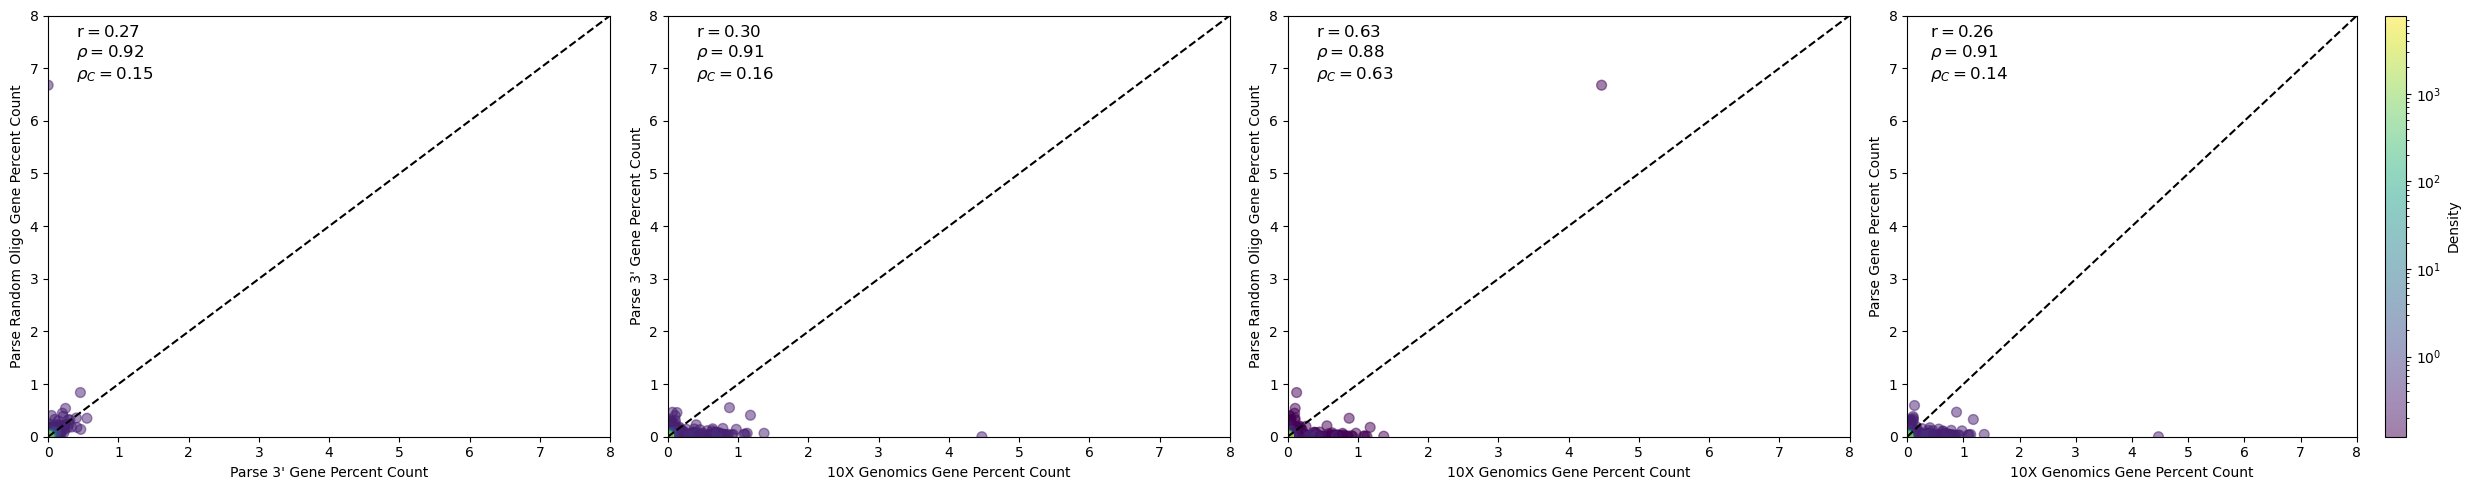

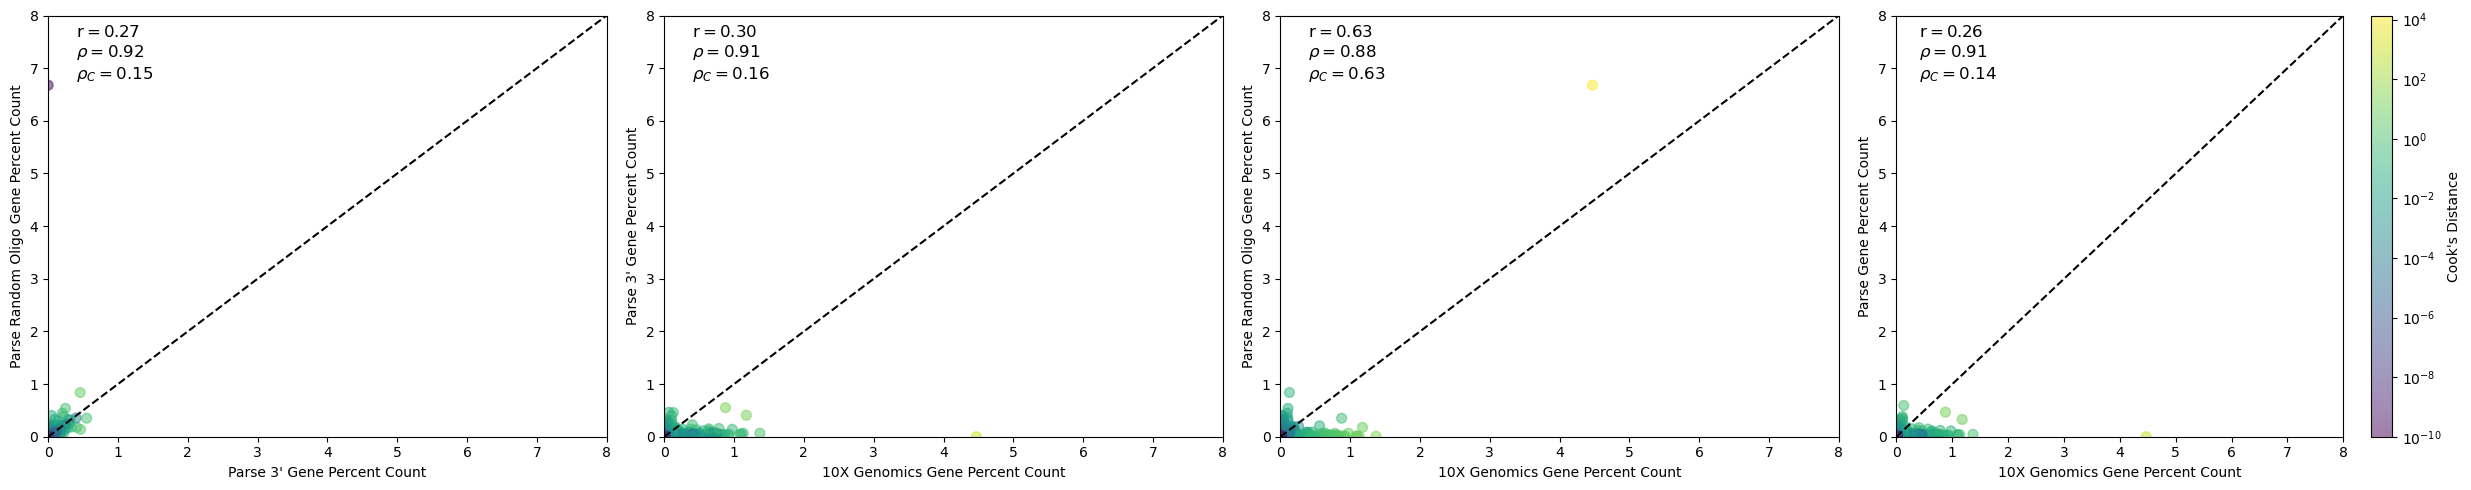

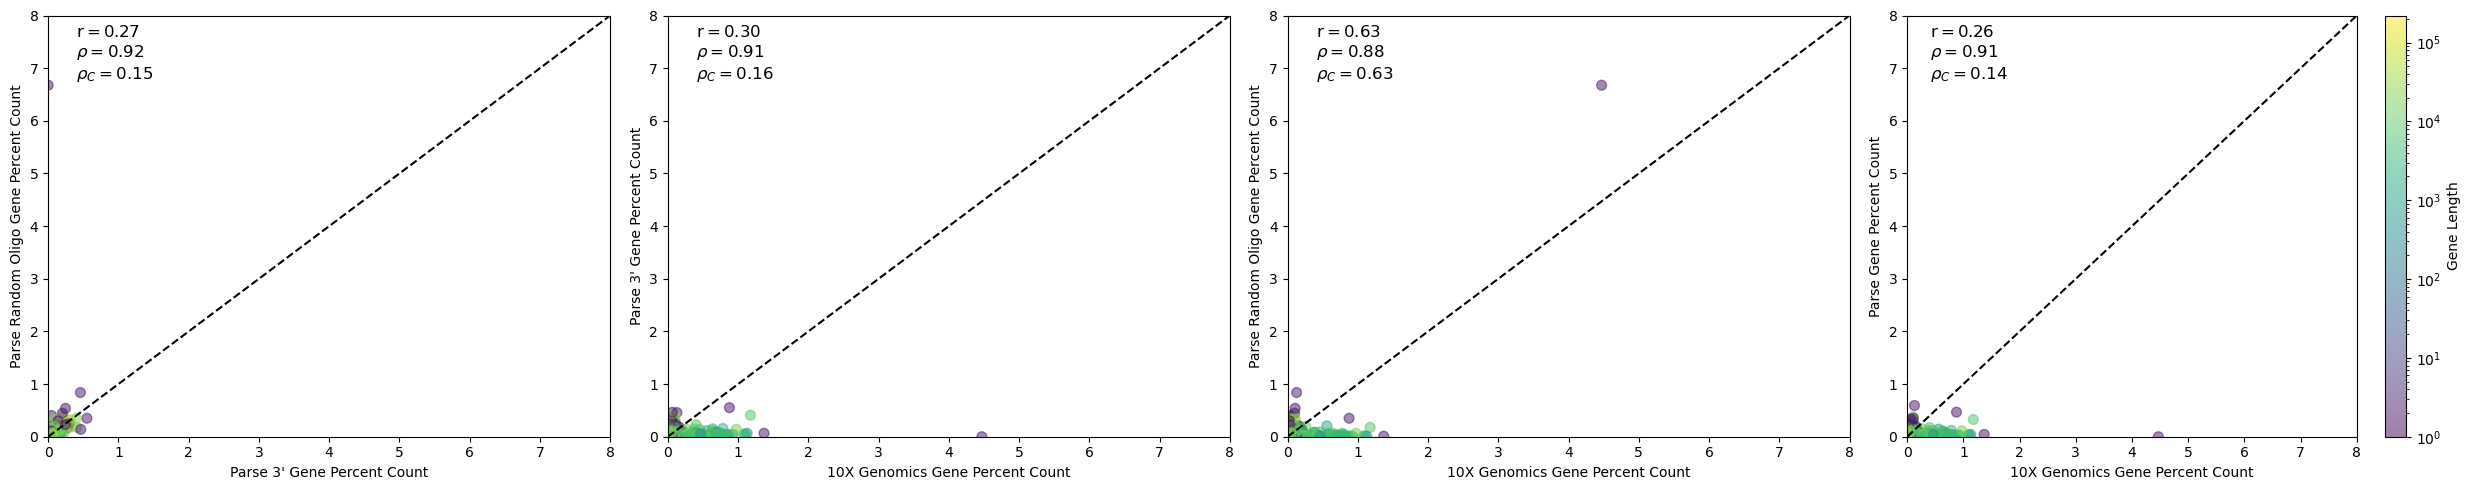

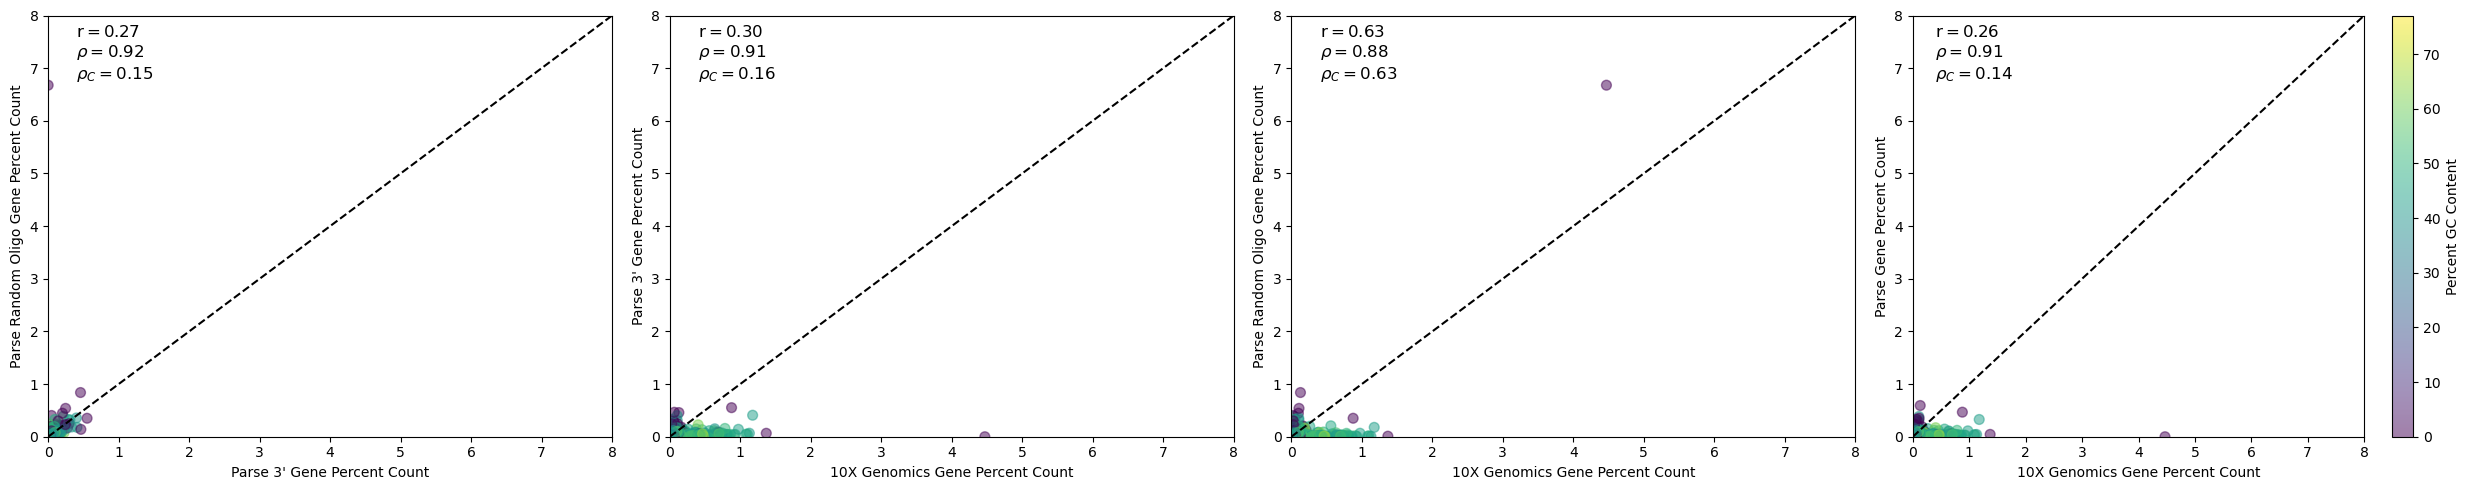

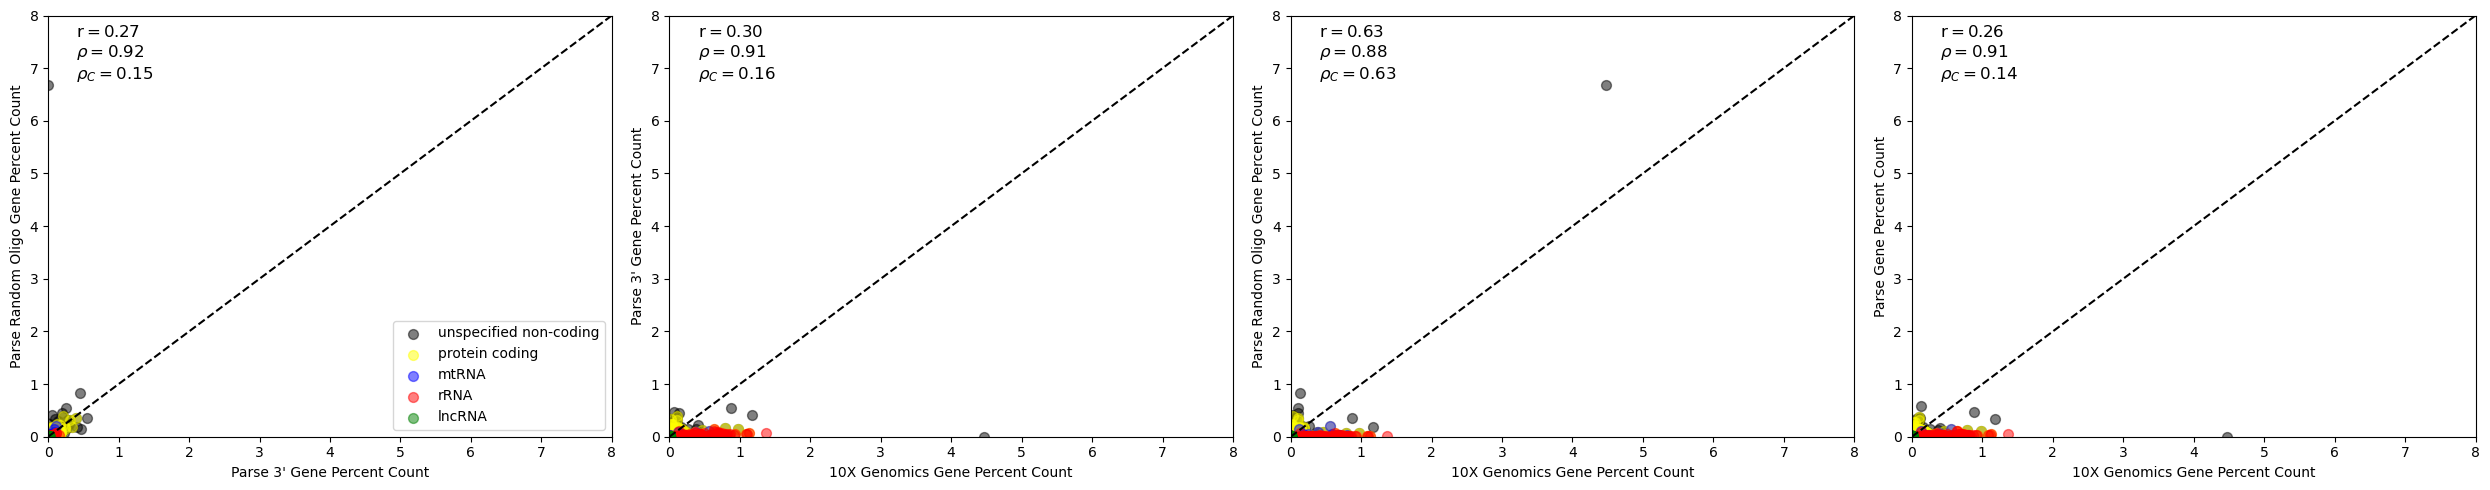

In [101]:
compare_names, compare_dfs = compare(datasets, 8)

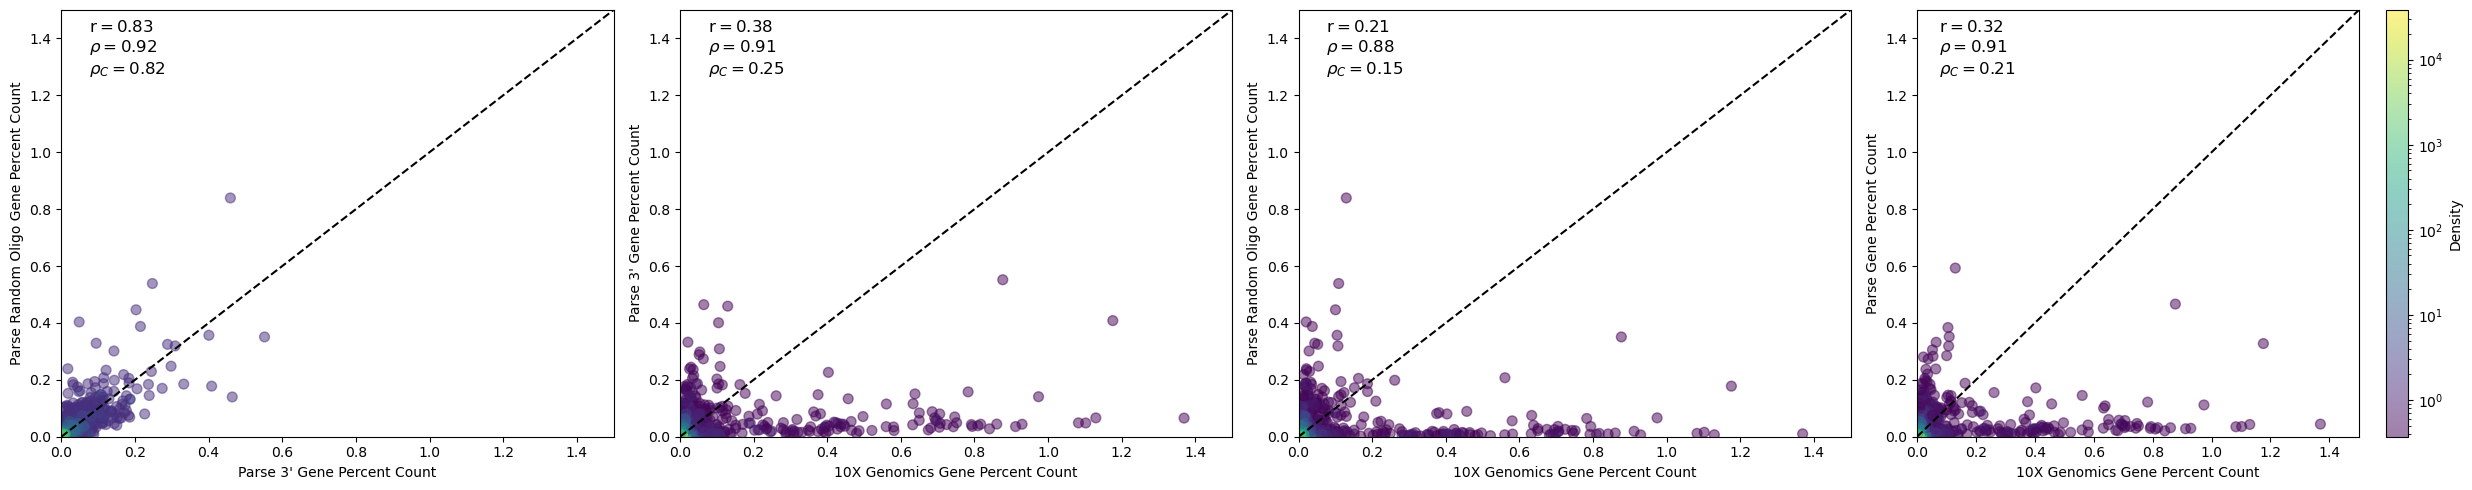

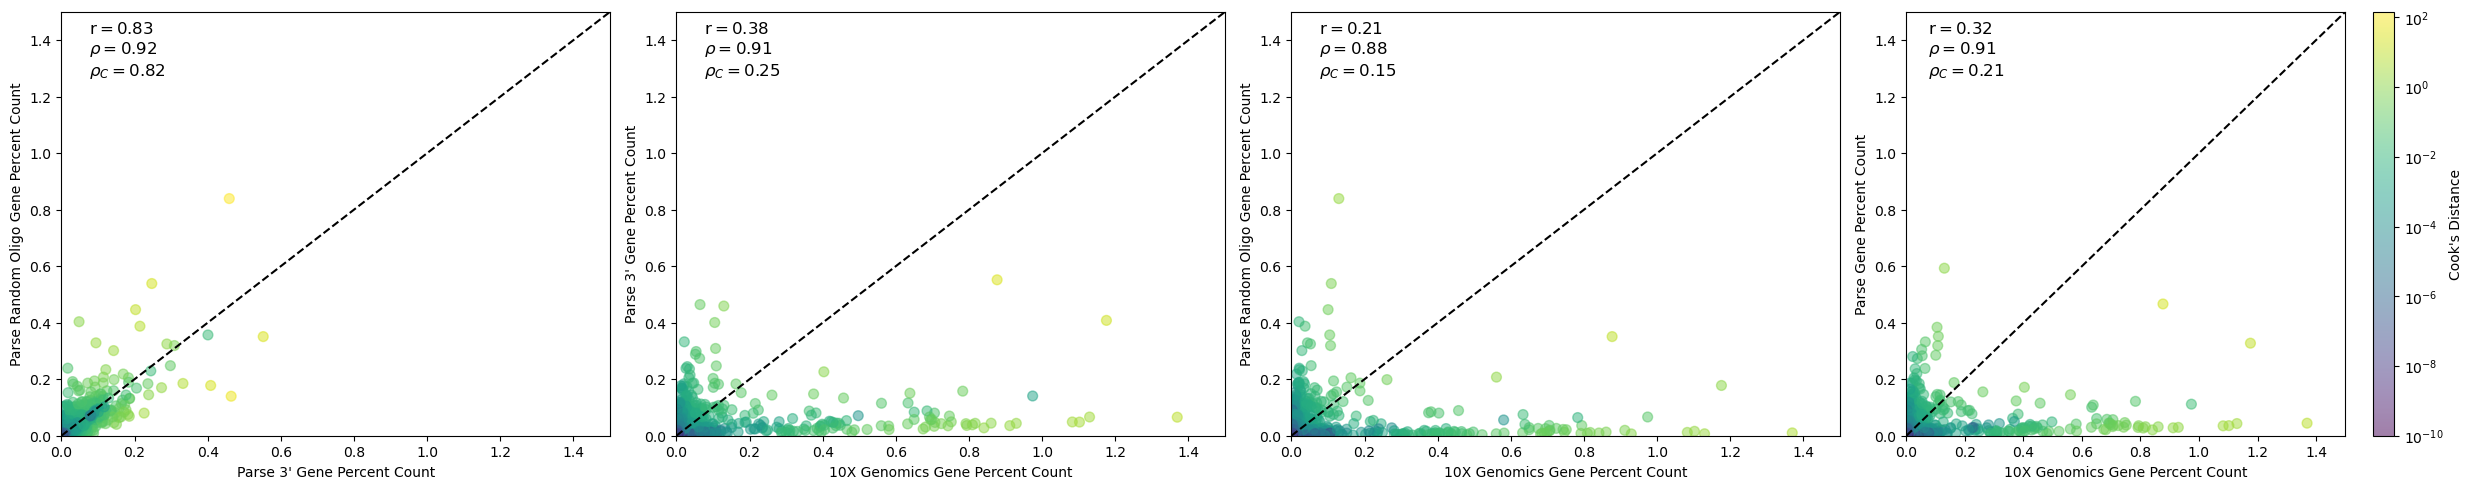

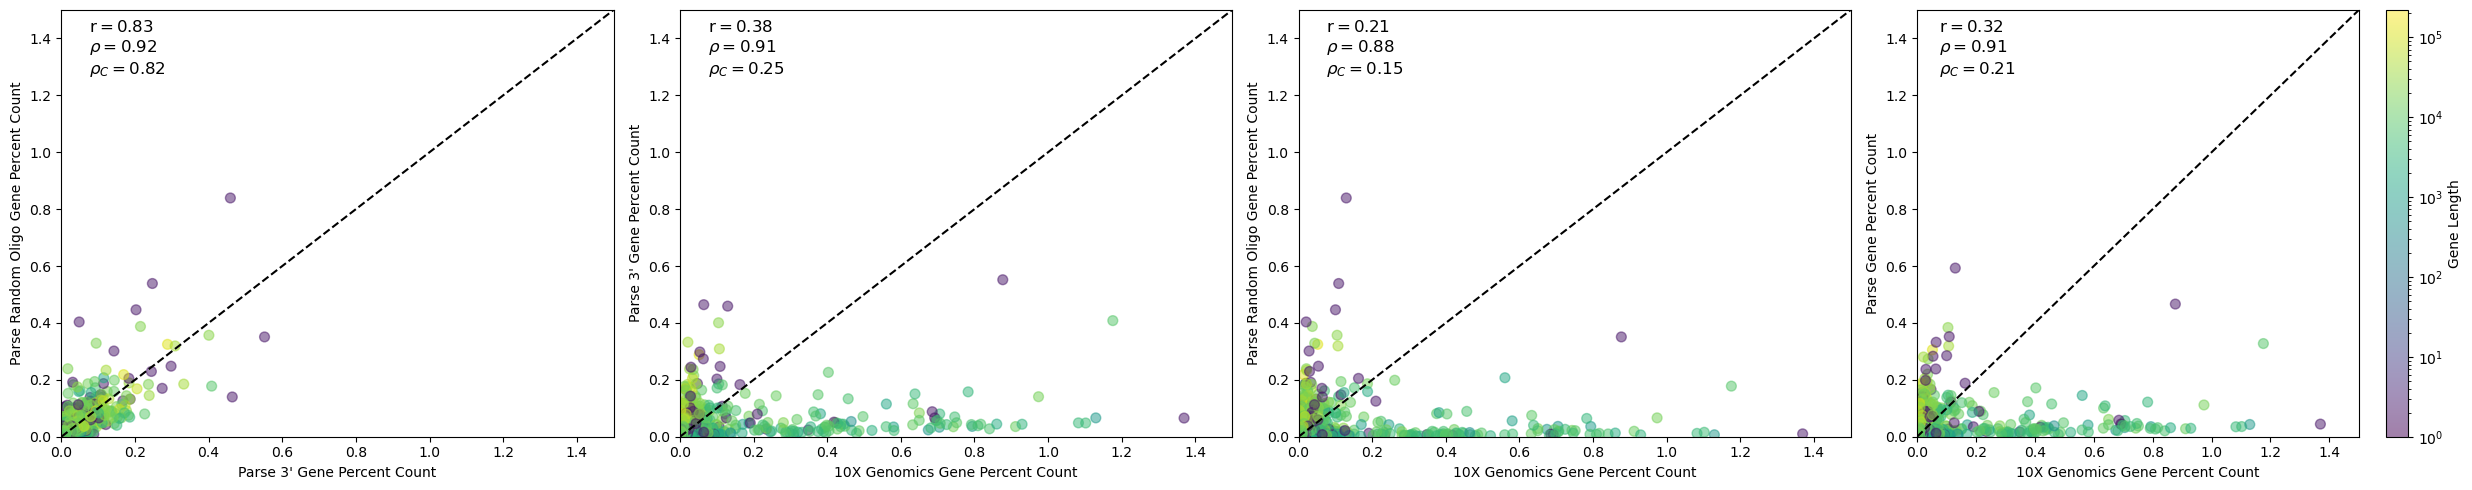

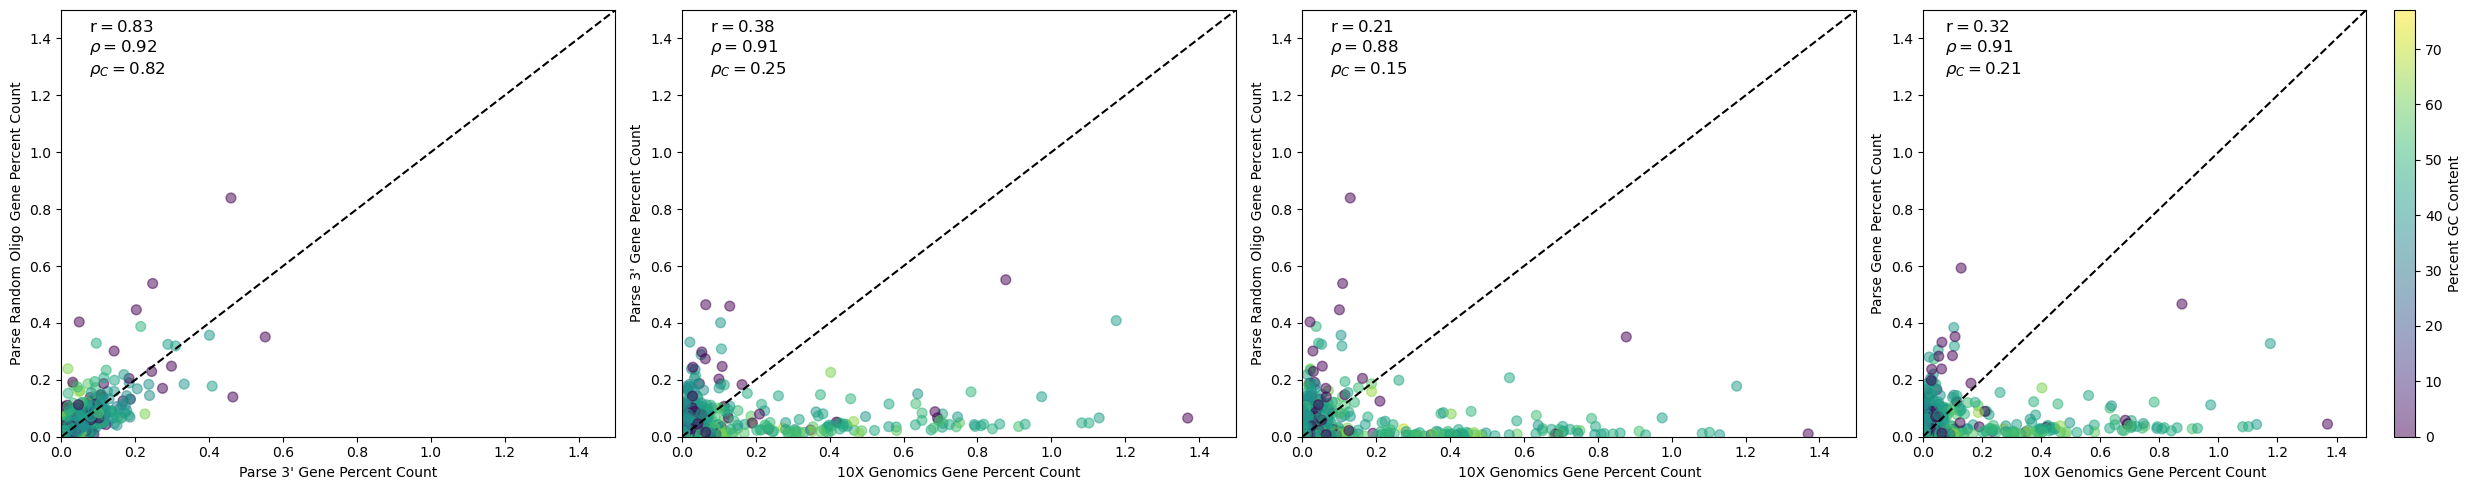

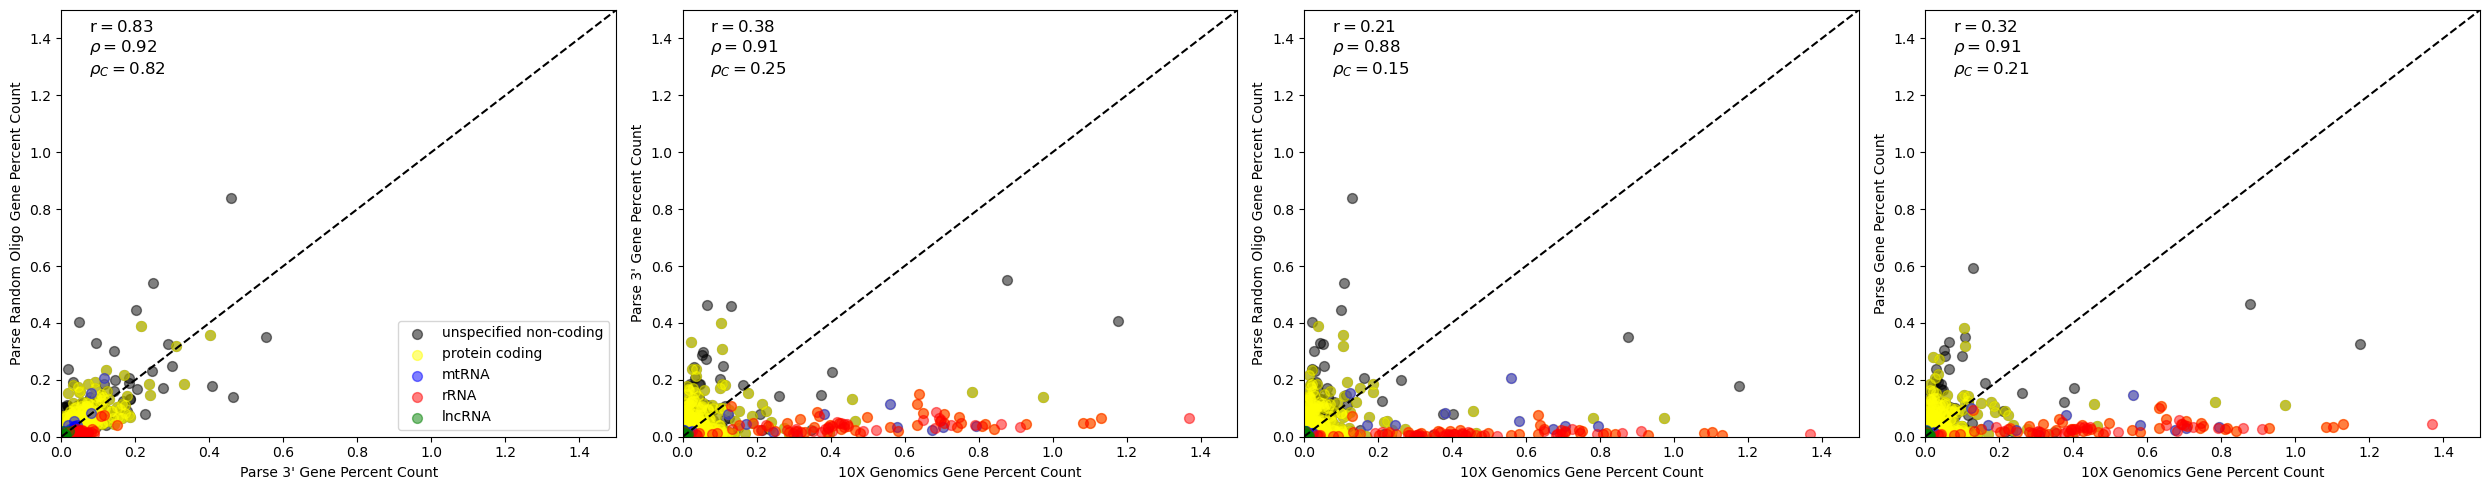

(['polyT_randO', '10x_polyT', '10x_randO', '10x_parse'],
 [      gene_name             gene_id  n_cells_H1_x  percent_counts_H1_x  \
  0          A1BG  ENSG00000121410.12           9.0             0.000072   
  1      A1BG-AS1   ENSG00000268895.6          38.0             0.000311   
  2          A1CF  ENSG00000148584.15           0.0             0.000000   
  3           A2M  ENSG00000175899.15          20.0             0.000159   
  4       A2M-AS1   ENSG00000245105.4         692.0             0.006252   
  ...         ...                 ...           ...                  ...   
  28864    ZYG11A  ENSG00000203995.10          13.0             0.000104   
  28865    ZYG11B  ENSG00000162378.13         438.0             0.003711   
  28866       ZYX  ENSG00000159840.16         272.0             0.002286   
  28867     ZZEF1  ENSG00000074755.15        1979.0             0.019226   
  28868      ZZZ3  ENSG00000036549.13         917.0             0.008307   
  
         n_cells_H2_x  perce

In [102]:
compare(datasets, 1.5)

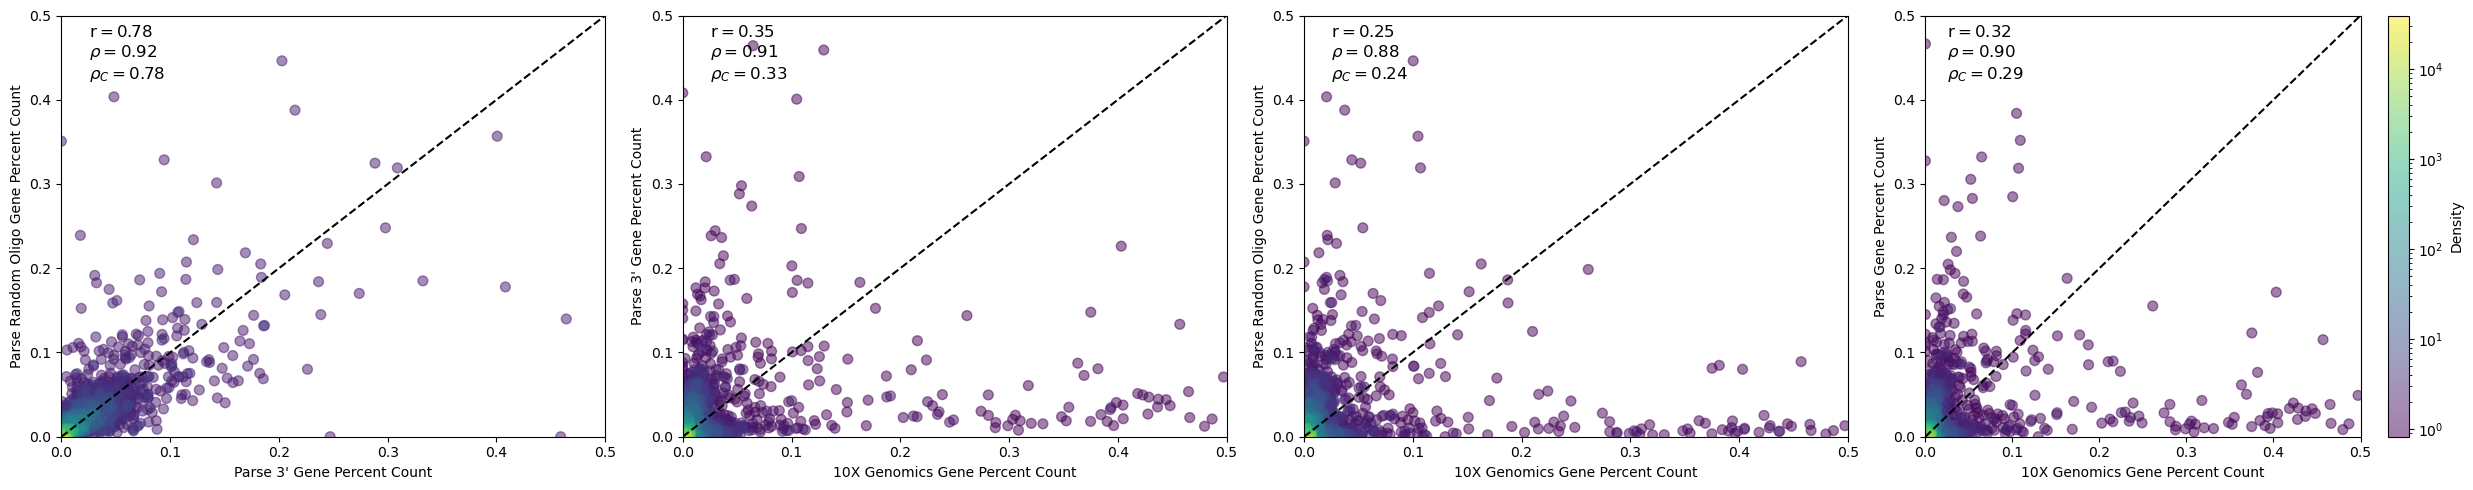

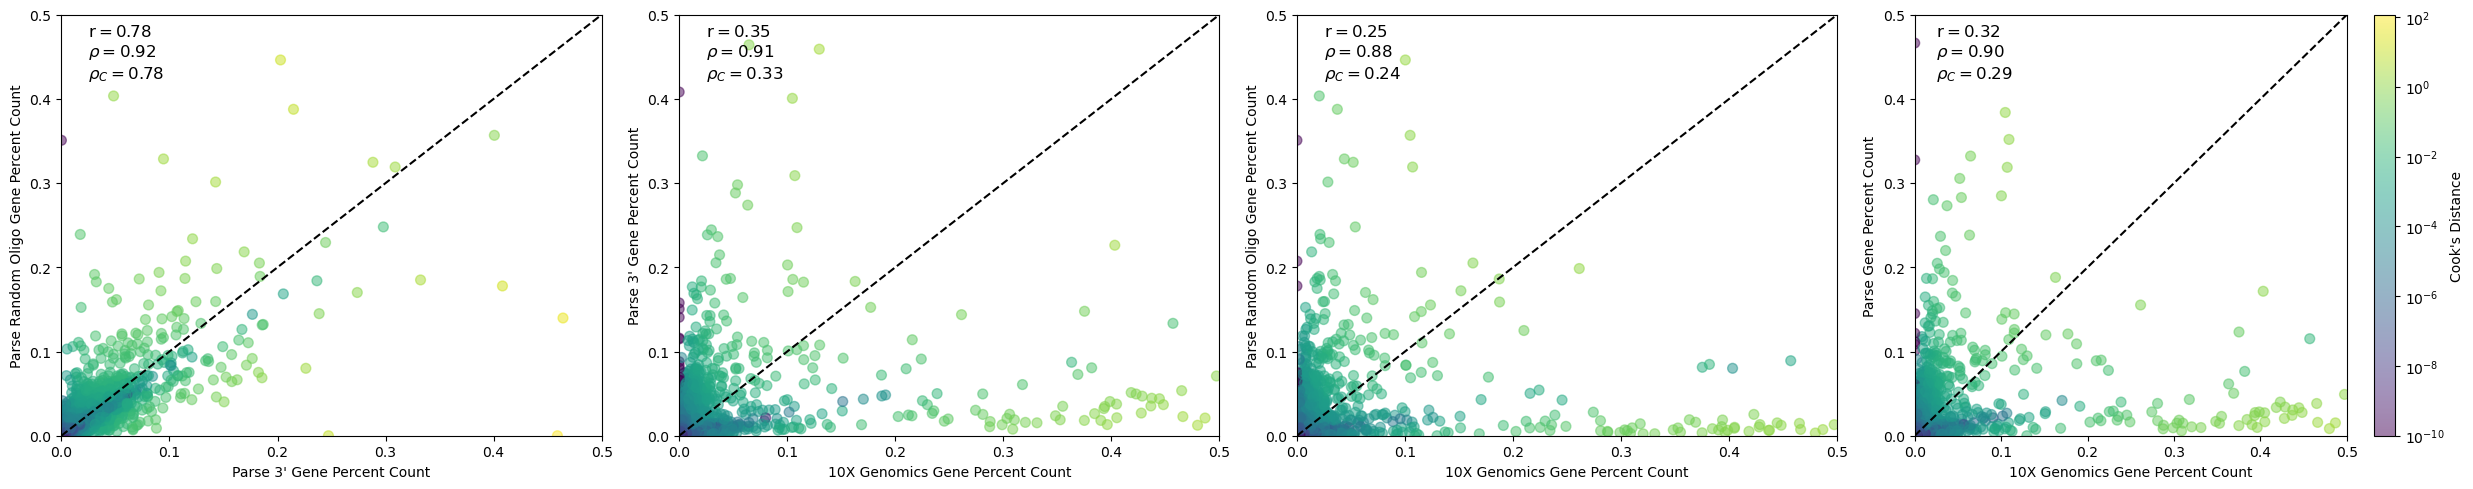

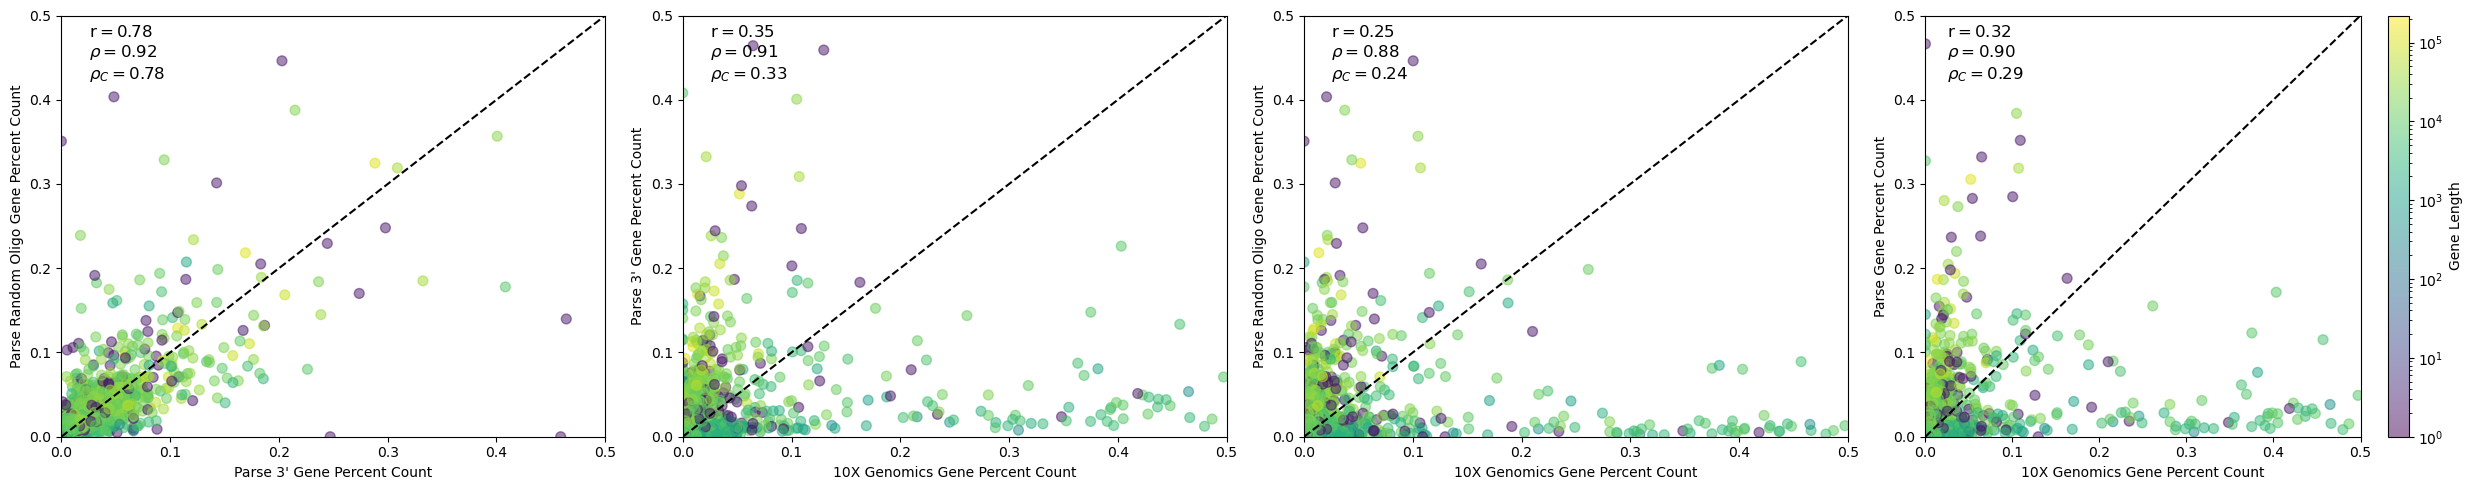

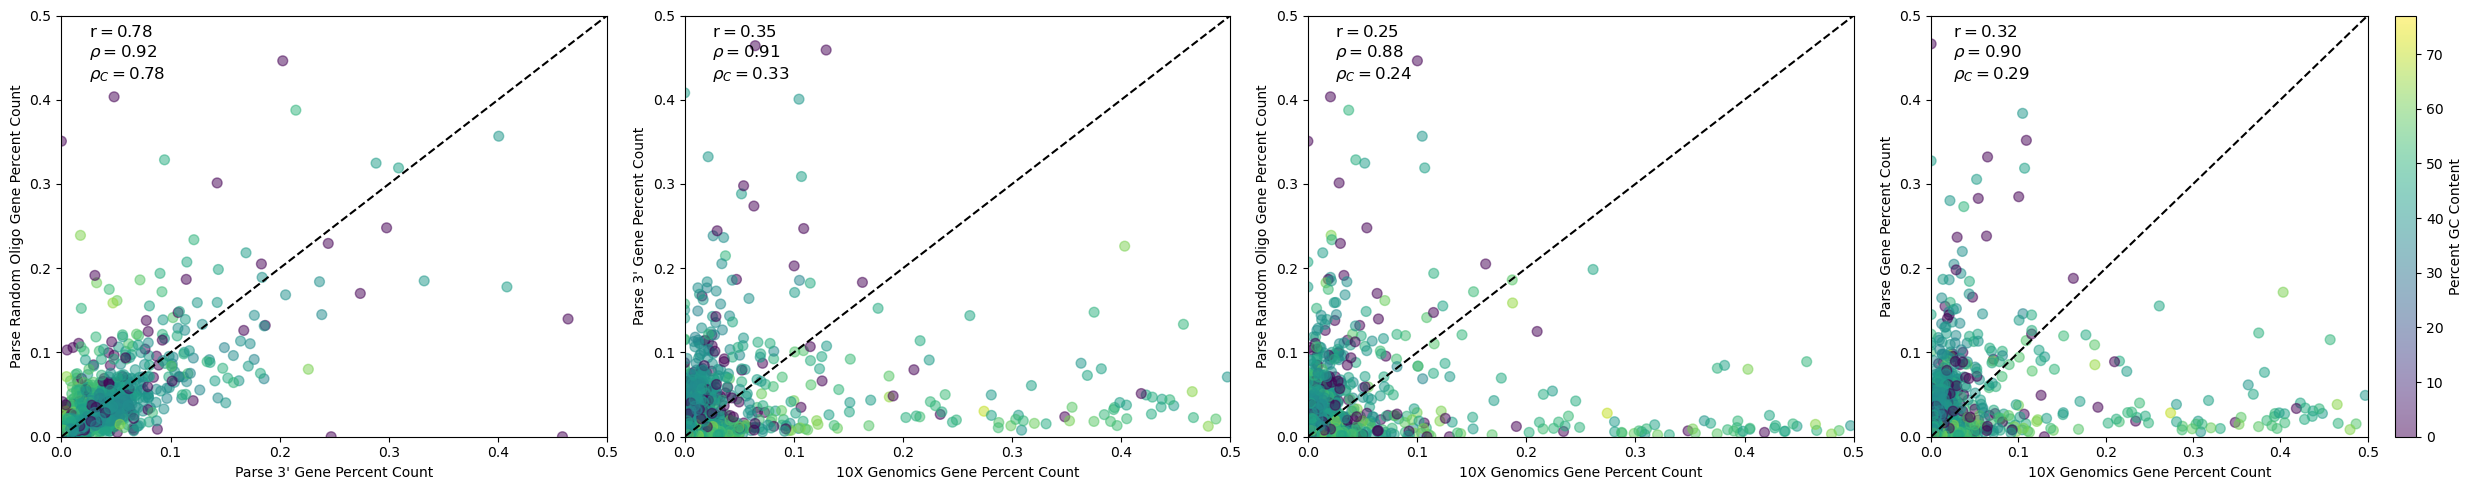

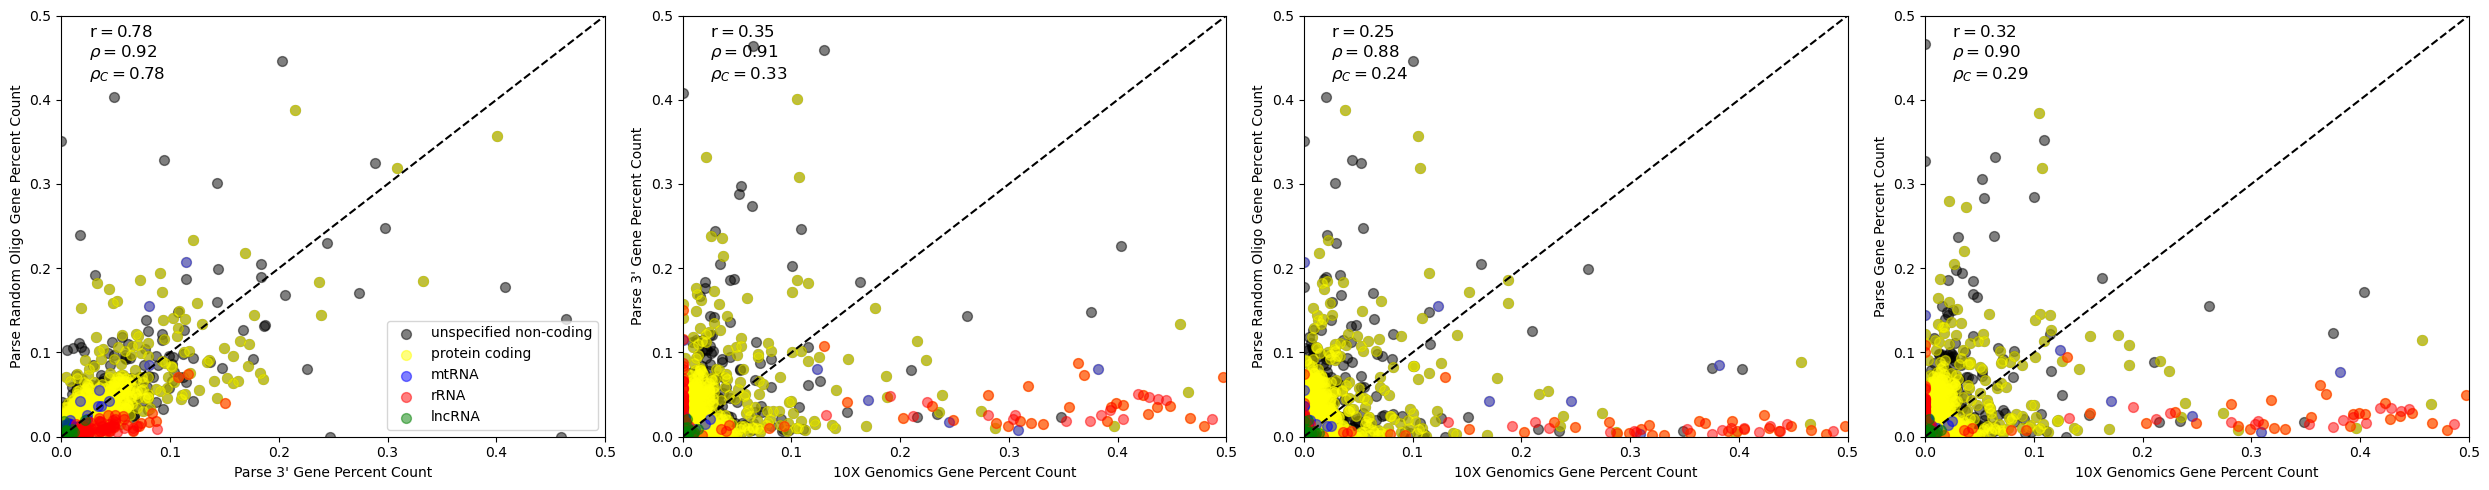

(['polyT_randO', '10x_polyT', '10x_randO', '10x_parse'],
 [      gene_name             gene_id  n_cells_H1_x  percent_counts_H1_x  \
  0          A1BG  ENSG00000121410.12           9.0             0.000072   
  1      A1BG-AS1   ENSG00000268895.6          38.0             0.000311   
  2          A1CF  ENSG00000148584.15           0.0             0.000000   
  3           A2M  ENSG00000175899.15          20.0             0.000159   
  4       A2M-AS1   ENSG00000245105.4         692.0             0.006252   
  ...         ...                 ...           ...                  ...   
  28864    ZYG11A  ENSG00000203995.10          13.0             0.000104   
  28865    ZYG11B  ENSG00000162378.13         438.0             0.003711   
  28866       ZYX  ENSG00000159840.16         272.0             0.002286   
  28867     ZZEF1  ENSG00000074755.15        1979.0             0.019226   
  28868      ZZZ3  ENSG00000036549.13         917.0             0.008307   
  
         n_cells_H2_x  perce

In [103]:
compare(datasets, 0.5)

In [104]:
def mergeByCooks(gene_info, compare_name, compare_df):
    cooks_df = compare_df[['gene_id', 'cooks_distance']]
    gene_info = gene_info.merge(cooks_df, how = 'left', on = ['gene_id'])
    gene_info = gene_info.rename(columns = {'cooks_distance': compare_name + '_distance'})
    return gene_info

In [105]:
for name, df in zip(compare_names, compare_dfs):
    gene_info = mergeByCooks(gene_info, name, df)

In [106]:
full_gene_info_path = "gene_comparisons.csv"
gene_info.to_csv(full_gene_info_path)

In [107]:
dict = {}
cell_thresh = 10
contents = pd.DataFrame()

# Generate upset plot comparing genes expressed in each method
for data in datasets:
    var = data.var[data.var['n_cells']>cell_thresh]
    mask = (gene_info['gene_id'].isin(var['gene_id'])).tolist()
    contents[str(data.uns['name'])] = mask

upset = Upset.generate_plot(contents)
contents['gene_ids'] = gene_info['gene_id']
upset.show()

In [108]:
# Extract gene subsets that were interesting in the upset plot

genes_10x = contents['gene_ids'][contents['10x']& 
                                 ~contents['polyT']&
                                 ~contents['randO']&
                                 ~contents['parse']]
genes_10x = genes_10x.tolist()

genes_parse = contents['gene_ids'][~contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_parse = genes_parse.tolist()

genes_XTP = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                ~contents['randO']&
                                contents['parse']]
genes_XTP = genes_XTP.tolist()

genes_all = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_all = genes_all.tolist()

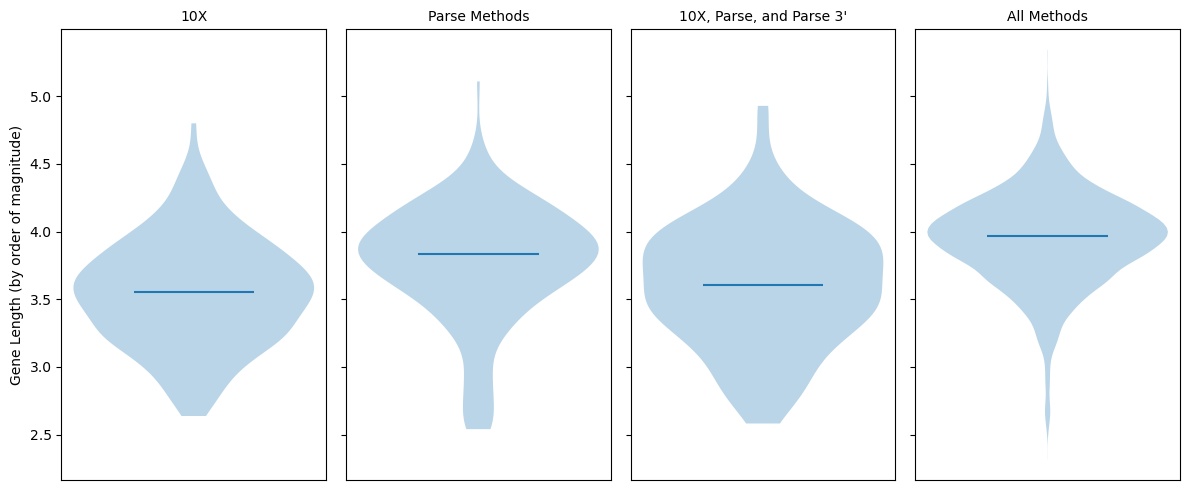

In [109]:
geneset_names = ['10X', 'Parse Methods', "10X, Parse, and Parse 3'", 'All Methods']
genesets = [genes_10x, genes_parse, genes_XTP, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    lengths = gene_info[gene_info['gene_id'].isin(data)]['gene_length'].tolist()
    ax.violinplot(np.log10(lengths),showextrema=False, showmedians=True)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])

axs[0].set_ylabel('Gene Length (by order of magnitude)')


plt.tight_layout()
plt.show()

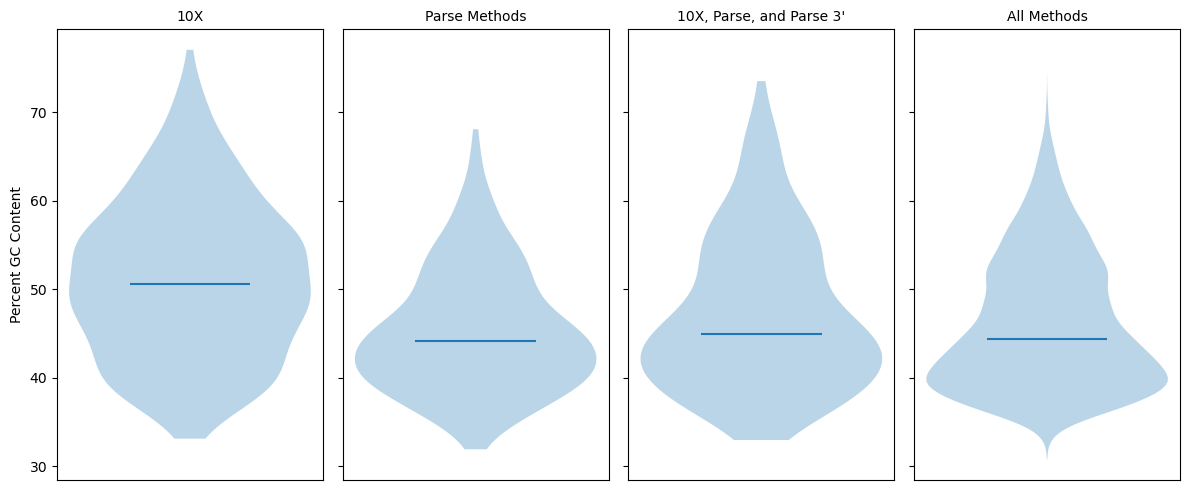

In [110]:
geneset_names = ['10X', 'Parse Methods', "10X, Parse, and Parse 3'", 'All Methods']
genesets = [genes_10x, genes_parse, genes_XTP, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    gcs = gene_info[gene_info['gene_id'].isin(data)]['gc_content'].tolist()
    ax.violinplot(gcs,showextrema=False, showmedians=True)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])

axs[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

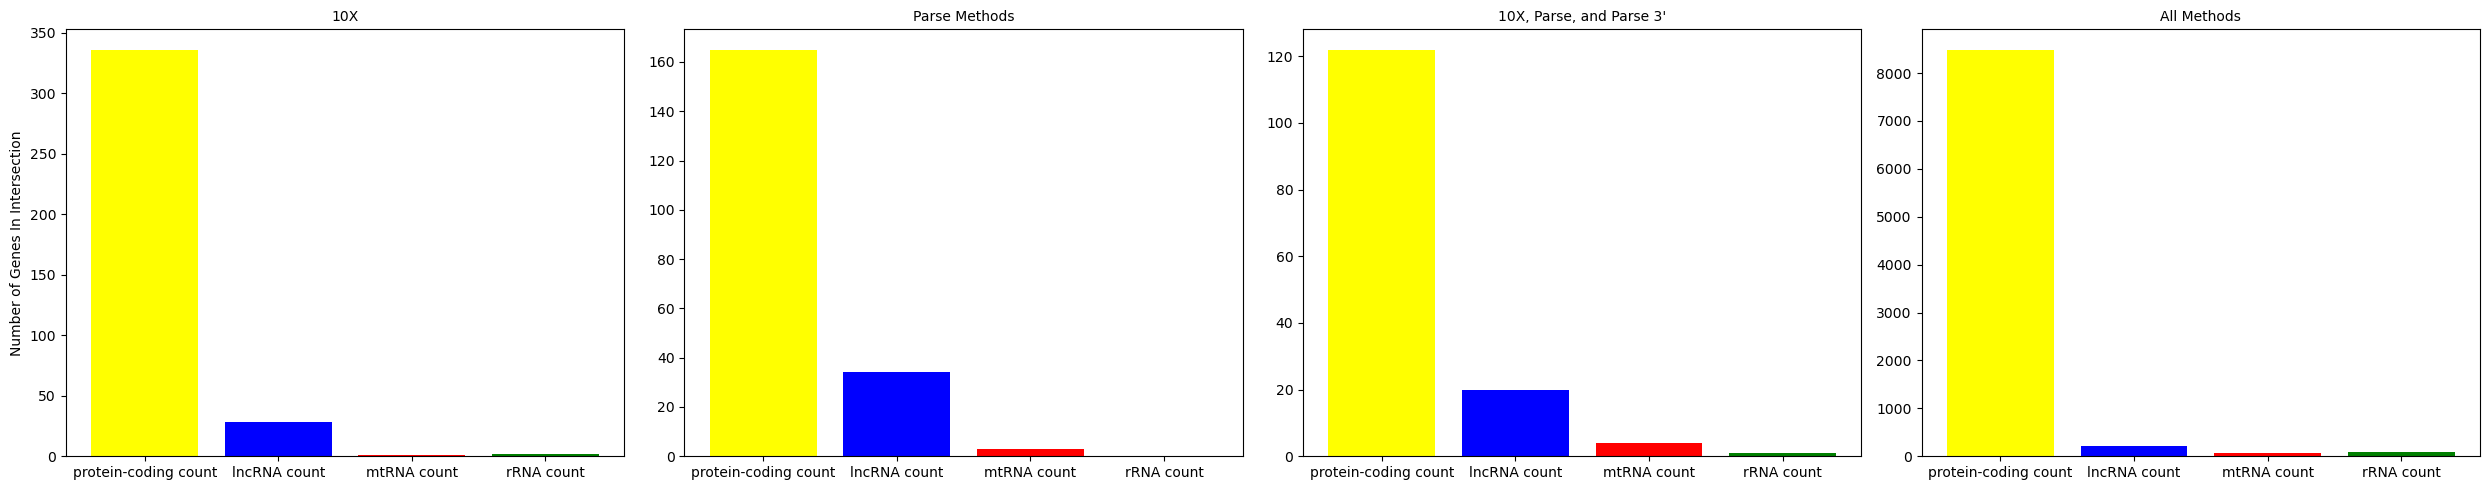

In [111]:
geneset_names = ['10X', 'Parse Methods', "10X, Parse, and Parse 3'", 'All Methods']
genesets = [genes_10x, genes_parse, genes_XTP, genes_all]
cols = ['is_pc', 'is_lnc', 'is_mito', 'is_ribo']
col_names = ['protein-coding count', 'lncRNA count', 'mtRNA count', 'rRNA count']
color = ['yellow', 'blue', 'red', 'green']

fig, axs = plt.subplots(1, len(genesets), figsize=(25,5))
for ax, data, name in zip(axs, genesets, geneset_names):
    sums = []
    for col in cols:
        sums.append(gene_info[col][gene_info['gene_id'].isin(data)].sum())
    ax.bar(col_names,sums,color=color)
    ax.set_title(name, fontsize=10)

axs[0].set_ylabel('Number of Genes In Intersection')


plt.tight_layout()
plt.show()

In [112]:
dict = {}
cell_thresh = 10

# Generate Upset plot comparing 1000 top genes expressed (by total counts) in each method
for data in datasets:
    var = data.var[data.var['n_cells']>cell_thresh]
    top_data = var.sort_values(by='percent_counts',ascending=False).head(1000)
    dict[str(data.uns['name'])] = (gene_info['gene_id'].isin(top_data['gene_id'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
contents['gene_ids'] = gene_info['gene_id']
upset.show() 

In [113]:
# Extract gene subsets that were interesting in the upset plot

genes_10x = contents['gene_ids'][contents['10x']& 
                                 ~contents['polyT']&
                                 ~contents['randO']&
                                 ~contents['parse']]
genes_10x = genes_10x.tolist()

genes_POT = contents['gene_ids'][~contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_POT = genes_POT.tolist()

genes_O = contents['gene_ids'][~contents['10x']& 
                               ~contents['polyT']&
                                contents['randO']&
                               ~contents['parse']]
genes_O = genes_O.tolist()

genes_all = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_all = genes_all.tolist()

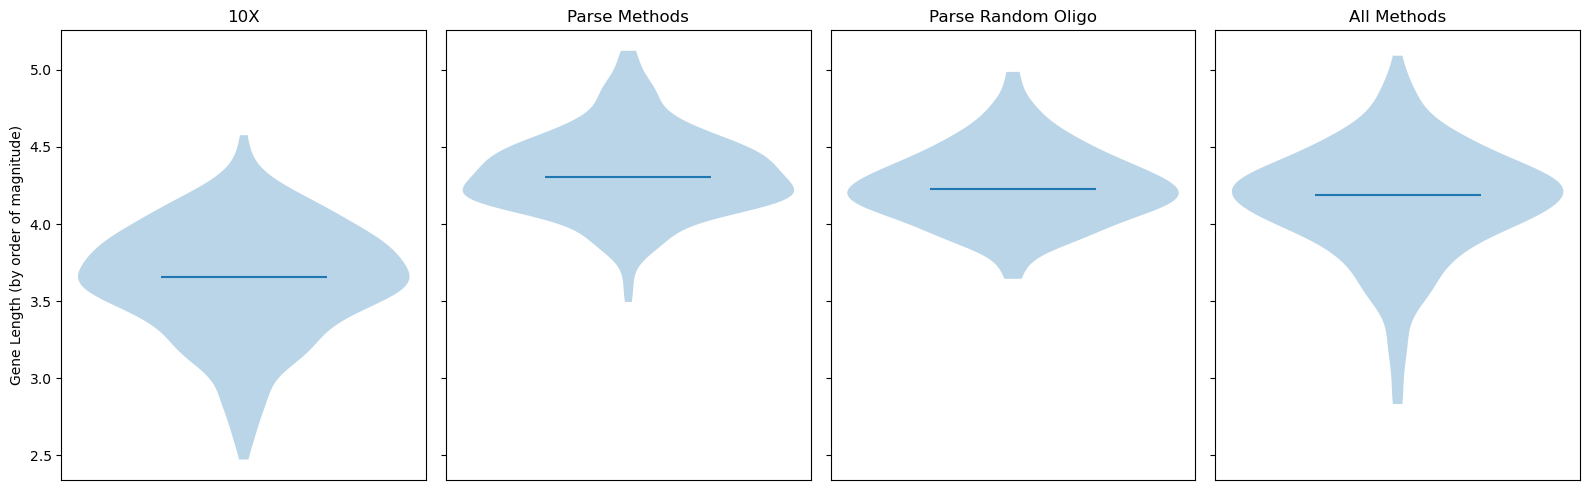

In [114]:
geneset_names = ['10X', 'Parse Methods', 'Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_POT, genes_O, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(16,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    lengths = gene_info[gene_info['gene_id'].isin(data)]['gene_length'].tolist()
    ax.violinplot(np.log10(lengths),showextrema=False, showmedians=True)
    ax.set_title(name)
    ax.set_xticks([])

axs[0].set_ylabel('Gene Length (by order of magnitude)')


plt.tight_layout()
plt.show()

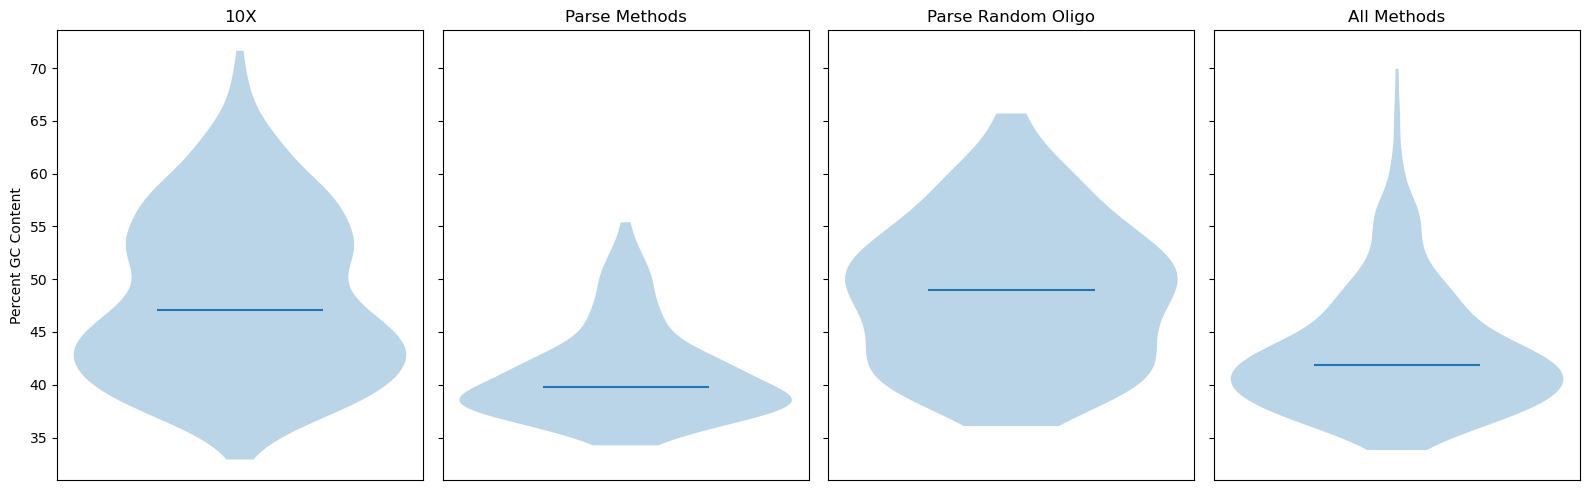

In [115]:
geneset_names = ['10X', 'Parse Methods', 'Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_POT, genes_O, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(16,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    gcs = gene_info[gene_info['gene_id'].isin(data)]['gc_content'].tolist()
    ax.violinplot(gcs,showextrema=False, showmedians=True)
    ax.set_title(name)
    ax.set_xticks([])

axs[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

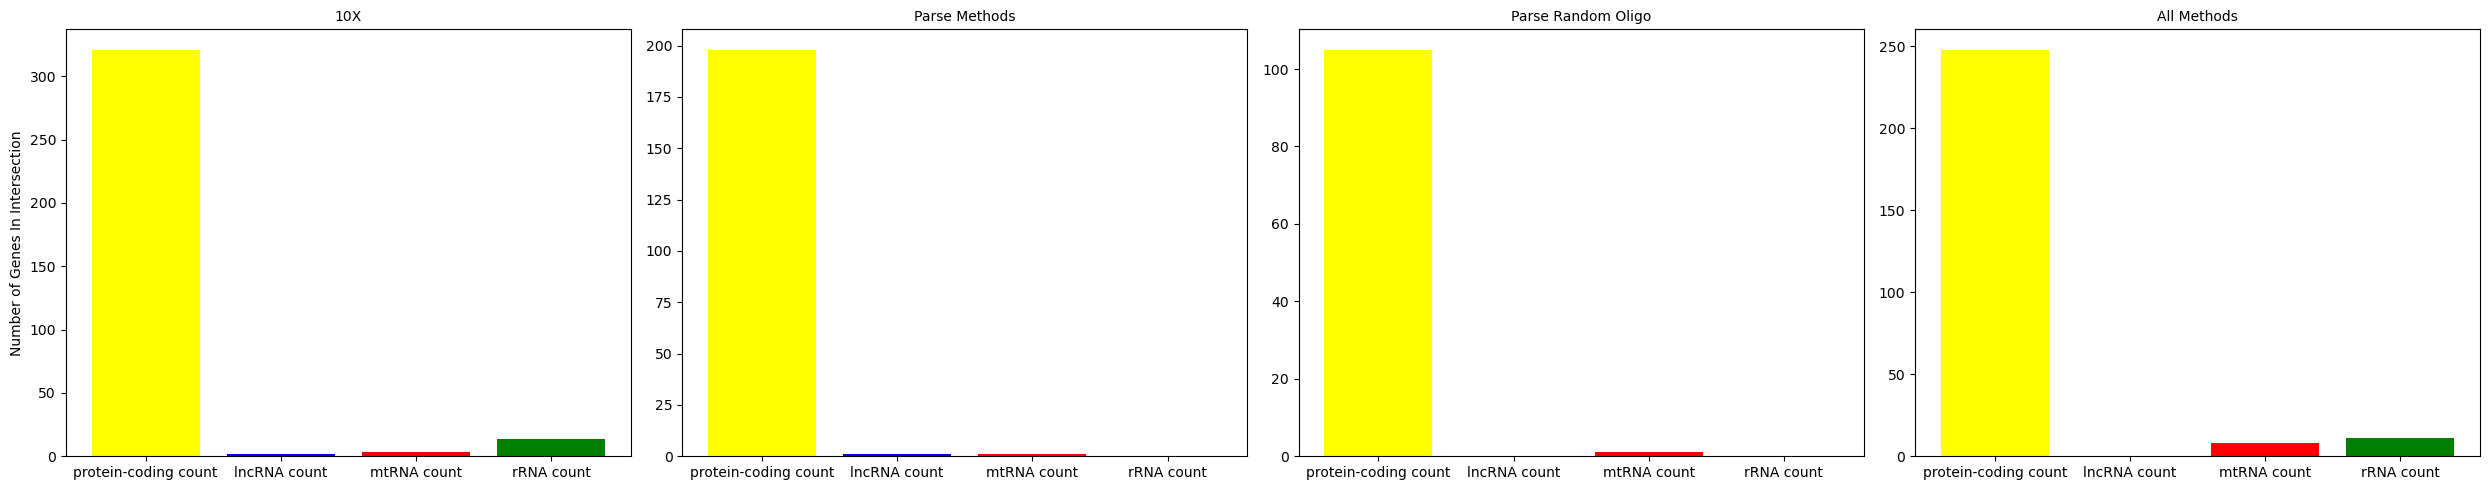

In [116]:
geneset_names = ['10X', 'Parse Methods', 'Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_POT, genes_O, genes_all]
cols = ['is_pc', 'is_lnc', 'is_mito', 'is_ribo']
col_names = ['protein-coding count', 'lncRNA count', 'mtRNA count', 'rRNA count']
color = ['yellow', 'blue', 'red', 'green']

fig, axs = plt.subplots(1, len(genesets), figsize=(25,5))
for ax, data, name in zip(axs, genesets, geneset_names):
    sums = []
    for col in cols:
        sums.append(gene_info[col][gene_info['gene_id'].isin(data)].sum())
    ax.bar(col_names,sums,color=color)
    ax.set_title(name, fontsize=10)
axs[0].set_ylabel('Number of Genes In Intersection')


plt.tight_layout()
plt.show()

In [117]:
gene_info[gene_info['gene_id'].isin(genes_10x)].sort_values(by='10x_percent_counts', ascending=False).head(20)

gene_id gene_name  gene_length  is_lnc  is_pc  is_mito  \
3817   ENSG00000115268.10     RPS15         5404   False   True    False   
7887   ENSG00000149806.11       FAU         4634   False   True    False   
9067   ENSG00000162244.12     RPL29         4569   False   True    False   
15554   ENSG00000233927.5     RPS28         3960   False  False    False   
4805   ENSG00000124614.17     RPS10         3468   False   True    False   
11030  ENSG00000171858.18     RPS21         1993   False   True    False   
14166   ENSG00000198840.2    MT-ND3          346   False   True     True   
5353   ENSG00000130255.13     RPL36         3353   False   True    False   
6309   ENSG00000136942.15     RPL35         2302   False   True    False   
15117   ENSG00000221983.8     UBA52         7594   False   True    False   
13541  ENSG00000196154.12    S100A4         1872   False   True    False   
2703   ENSG00000105374.10      NKG7         2089   False   True    False   
9278   ENSG00000163220.11    S100A9          573   False   True    False   
13944  ENSG00000197956.10    S100A6         1745   False   True    False   
10602   ENSG00000169442.9      CD52         1201   False  False    False   
16868   ENSG00000275302.2      CCL4         2831   False   True    False   
7064   ENSG00000142669.15  SH3BGRL3         1519   False   True    False   
4730   ENSG00000124172.10   ATP5F1E         6058   False   True    False   
15301   ENSG00000227507.3       LTB         3728   False  False    False   
7461   ENSG00000145741.17      BTF3        12260   False   True    False   

       is_ribo  gc_content  10x_n_cells  10x_percent_counts  polyT_n_cells  \
3817      True       62.72      16630.0            0.479714         2585.0   
7887     False       53.42      16554.0            0.396165         2746.0   
9067      True       53.83      16518.0            0.390209         3599.0   
15554     True       57.12      16463.0            0.374958         3641.0   
4805      True       47.38      16419.0            0.331130         3159.0   
11030     True       59.45      16384.0            0.320390         3190.0   
14166    False       40.17      16461.0            0.308676         1699.0   
5353      True       58.81      16289.0            0.298883         2736.0   
6309      True       56.22      16398.0            0.287806         3359.0   
15117    False       53.24      16427.0            0.287355         2260.0   
13541    False       56.30      12294.0            0.168774         2416.0   
2703     False       59.03       6221.0            0.139983         1845.0   
9278     False       52.56       1934.0            0.137009         1077.0   
13944    False       58.51      13221.0            0.112692         1618.0   
10602    False       54.56      13657.0            0.110662         1900.0   
16868    False       48.52       4675.0            0.108507         2138.0   
7064     False       61.93      13962.0            0.105846         2116.0   
4730     False       39.32      14921.0            0.104195         2050.0   
15301    False       61.61      10951.0            0.097494         1594.0   
7461     False       38.61      14801.0            0.096523         3220.0   

       polyT_percent_counts  randO_n_cells  randO_percent_counts  \
3817               0.012434          573.0              0.003230   
7887               0.013240          707.0              0.004025   
9067               0.018178         1176.0              0.006763   
15554              0.018178          618.0              0.003490   
4805               0.015342          422.0              0.002354   
11030              0.015857          394.0              0.002229   
14166              0.007796          486.0              0.002700   
5353               0.013029          677.0              0.003852   
6309               0.016857          748.0              0.004307   
15117              0.010699          884.0              0.005135   
13541              0.013105       